# basic set up

In [1]:
#basic set up
%matplotlib inline
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import os
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from IPython.display import clear_output
from matplotlib.path import Path
import pandas as pd
import pdb
from utils.common_imports import *


#netflow 
import ets_fiber_assigner.netflow as nf
import ets_fiber_assigner.io_helpers as io_helpers
from ics.cobraOps.Bench import Bench
from ics.cobraOps.TargetGroup import TargetGroup
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.BlackDotsCalibrationProduct import BlackDotsCalibrationProduct
from pfs.utils.fiberids import FiberIds

from ics.cobraCharmer.pfiDesign import PFIDesign
from ics.cobraCharmer.cobraCoach.cobraCoach import CobraCoach
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector

from ics.cobraOps.CollisionSimulator2 import CollisionSimulator2
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.cobraConstants import NULL_TARGET_POSITION, NULL_TARGET_ID
from ics.cobraOps import plotUtils
from collections import defaultdict

# key functions

In [2]:

# read the pointing centers from the file
def read_pointings(file):
    """
    Read pre-defined pointings from a file
    """
    try:
        # first try reading as ecsv format
        t = Table.read(file, format="ascii.ecsv")
        return t["R.A."], t['Dec.']
    except:
        pass

    with open(file) as f:
        ras = []
        decs = []
        ll = f.readlines()
        for l in ll[1:]:
            if not l.startswith("#"):
                tt = l.split()
                ra, dec = (float(tt[0]), float(tt[1]))
                ras.append(ra)
                decs.append(dec)
    return np.array(ras), np.array(decs)

# TODO: try a more efficient way to contruct the target list, add alreadyObserved to the target list either in netflow Targets or in this function
def construct_tgt_list(catalog_path = "../proc_data/", \
                       fn_list = ["cos_select.ecsv", "star_select.ecsv", "sky_select.ecsv"], \
                       prefix_list = ["sci", "cal", "sky"], calibration_list = [False, True, True]):
    '''
    Construct target list
    '''
    print("construct target list:")
    for i, fn_i in enumerate(fn_list):
        fn = catalog_path + fn_i
        print(fn)
        
        # read all targets into a single list, giving them their proper types
        if(i<1):
            if(not calibration_list[i]): tgt = nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt = nf.readCalibrationFromFile(fn, prefix_list[i])
        else:
            if(not calibration_list[i]): tgt += nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt += nf.readCalibrationFromFile(fn, prefix_list[i])

    print("In total, there are %d targets." % len(tgt))

    # sample of sci targets
    sample_sci = []
    for t in tgt:
        if(t.targetclass[:3] == 'sci'): sample_sci.append([t.ID,t.ra,t.dec])  

    sample_sci = np.array(sample_sci)
    
    return tgt, sample_sci

# TODO: play with the cost value for different classes
def def_classdict():
    '''define classdict for netflow run
    
    Parameters
    ==========
    None
    
    Returns
    =======
    classdict
    '''
    # create the dictionary containing the costs and constraints for all classes
    # of targets
    classdict = {}
    classdict["sci_P1"] = {"nonObservationCost": 200,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P2"] = {"nonObservationCost": 100,
                           "partialObservationCost": 1e6, "calib": False}
    
    #for ancillary targets
    classdict["anc_P1"] = {"nonObservationCost": 50,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["anc_P2"] = {"nonObservationCost": 10,
                           "partialObservationCost": 1e6, "calib": False}

    #need to ask PFS project office to get the "numRequired"
    classdict["sky"] = {"numRequired": 400,
                        "nonObservationCost": 1e6, "calib": True}
    #100-200 stars - Masayuki
    classdict["cal"] = {"numRequired": 200,
                        "nonObservationCost": 1e6, "calib": True}

    return classdict



def write_output(tgt, res, tpos, telescopes, fdir_out, fn_out, t_obs=900):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
    '''
    
    with open(fdir_out + fn_out, "w") as f:
        for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
            print("exposure {}:".format(i))
            print("  assigned Cobras: {}".format(len(vis)))
            tdict = defaultdict(int)
            f.write("# Exposure {}: duration {}s, RA: {}, Dec: {}, PA: {}\n".
                    format(i+1, t_obs, tel._ra, tel._dec, tel._posang))
            f.write("# Target    Fiber          X          Y         "
                    "RA        DEC\n")
            for tidx, cidx in vis.items():
                tdict[tgt[tidx].targetclass] += 1 #tgt[].targetclass = 'sci_Px'
                f.write("{:} {:6d} {:10.5f} {:10.5f} {:10.5f} {:10.5f}\n"
                        .format(tgt[tidx].ID, cidx+1, tp[tidx].real, tp[tidx].imag,
                                tgt[tidx].ra, tgt[tidx].dec))
            for cls, num in tdict.items():
                print("   {}: {}".format(cls, num))
                
                
def cal_completeness(tgt, res, tpos, telescopes, Plot=False, fn_fig='', Save=False, fn_fibeff=''):
    '''calculate the completeness of the targets and fiber assignment fraction
    Parameters
    ==========
    fdir_out: string
        output folder directory
    Plot: boolean
        plot the results if True 
    '''
    
    #fiber assignment fraction of each pointing
    fib_eff = [] 
    #fiber assignment fraction of pointing which observed galaxies
    fib_eff_gal = []
    fib_eff_anc = []
    #calibration targets
    fib_eff_star = []
    fib_eff_sky = []

    #objects that got allocated a fiber
    obj_allo = []
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        fib_eff_t = len(vis)/2394.*100 #2394 fibers available
        fib_eff.append(fib_eff_t)

        n_fib_gal = 0
        n_fib_anc = 0
        n_fib_star = 0
        n_fib_sky = 0
        #tidx is the id in tgt list; cidx is the fiber id, starting from 0
        for tidx, cidx in vis.items():
            obj_allo.append(["Point_"+str(i+1), tel._ra, tel._dec, tel._posang, tgt[tidx].ID,
                            cidx+1, tp[tidx].real, tgt[tidx].ra, tgt[tidx].dec,
                            tgt[tidx].targetclass])

            if tgt[tidx].targetclass[:3]=='sci': n_fib_gal+=1
            if tgt[tidx].targetclass[:3]=='anc': n_fib_anc+=1
            if tgt[tidx].targetclass[:3]=='sky': n_fib_sky+=1
            if tgt[tidx].targetclass[:3]=='cal': n_fib_star+=1

        fib_eff_gal.append(n_fib_gal/2394.*100)
        fib_eff_anc.append(n_fib_anc/2394.*100)
        fib_eff_star.append(n_fib_star/2394.*100)
        fib_eff_sky.append(n_fib_sky/2394.*100)

        print("exposure {}:".format(i))
        print("assigned Cobras(%): {:.2f}%; gal--{:.2f}%, anc--{:.2f}%, sky--{:.2f}%, star--{:.2f}%". format(fib_eff[i], fib_eff_gal[i], fib_eff_anc[i], fib_eff_sky[i], fib_eff_star[i]))
    
    if(Save==True):
        np.savetxt(fn_fibeff, np.c_[fib_eff, fib_eff_gal, fib_eff_anc, fib_eff_sky, fib_eff_star])
    
    #unique tgt_class
    tgt_class = []
    for tgt_i in tgt:
        tgt_class.append(tgt_i.targetclass)
    tgt_class = np.array(tgt_class)
    uniq_tgt_class = np.unique(tgt_class)

    #completeness fraction
    tgt_class_allo = np.array([obj_allo_i[-1] for obj_allo_i in obj_allo])
    comp_out = {}
    for ii, uniq_tgt_i in enumerate(uniq_tgt_class):
        mask_i = tgt_class == uniq_tgt_i
        tot = len(tgt_class[mask_i])

        mask_ii = tgt_class_allo == uniq_tgt_i
        done = len(tgt_class_allo[mask_ii])

        comp_out[uniq_tgt_i] = done/tot
        
    print("comp_out=", comp_out)
    
    #plot
    if(Plot==True):  
        npoint_used = len(tpos)
        msk_sci_class =  [uniq_tgt_class_i[:3]=='sci' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = uniq_tgt_class[msk_sci_class]
        msk_anc_class =  [uniq_tgt_class_i[:3]=='anc' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = np.append(sci_class, uniq_tgt_class[msk_anc_class])
        print(sci_class)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        for ii, sci_class_ii in enumerate(sci_class):
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., fc='tomato', ec='none', alpha=0.8, zorder=10)
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., ec='tomato', fc='none', lw=1)

        plt.plot([0,10], [0.8,0.8], 'k--', lw=2, zorder=11)
        plt.xticks(np.arange(len(sci_class))+1, sci_class, fontsize=15)
        plt.ylabel('completeness fraction', fontsize=15)
        plt.xlim(0, len(sci_class)+2)
        plt.ylim(0, 1.)

        plt.subplot(122)
        plt.bar(np.arange(0,len(fib_eff_gal),1), fib_eff_gal, width=0.8, fc='tomato', ec='none', alpha=0.6, zorder=10)
        plt.bar(np.arange(0,len(fib_eff_anc),1), fib_eff_anc, width=0.8, fc='purple', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_sky),1), fib_eff_sky, width=0.8, fc='blue', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_star),1), fib_eff_star, width=0.8, fc='gray', ec='none', alpha=0.5)

        plt.plot([0,npoint_used+1.], [80,80], 'k--', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_gal), np.mean(fib_eff_gal)], '--', color='tomato', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_anc), np.mean(fib_eff_anc)], '--', color='purple', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_sky), np.mean(fib_eff_sky)], '--', color='blue', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_star), np.mean(fib_eff_star)], '--', color='gray', lw=2, zorder=11)

        plt.text(npoint_used*0.8, 100, "{:2.2f}%".format(np.mean(fib_eff_gal)), color='tomato', fontsize=12)
        plt.text(npoint_used*0.8, 92, "{:2.2f}%".format(np.mean(fib_eff_anc)), color='purple', fontsize=12)
        plt.text(npoint_used*0.8, 84, "{:2.2f}%".format(np.mean(fib_eff_sky)), color='blue', fontsize=12)
        plt.text(npoint_used*0.8, 76, "{:2.2f}%".format(np.mean(fib_eff_star)), color='gray', fontsize=12)
        plt.xlim(0, npoint_used+1.)
        plt.ylim(0, 110.)
        plt.xlabel('Pointing', fontsize=15)
        plt.ylabel('fiber alloc fraction', fontsize=15)

        plt.savefig(fn_fig, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    return comp_out

    

## execute function

In [19]:
# (DONE)TODO-0: plot the distribution of the cosmology, star, and sky
# (DONE)TODO-1: make posang and otime as input parameters
# (DONE)TODO-2: test different otime outputs of tpos and netflow
# (DONE)TODO-3: make bench, Gurobi options as input parameters
# TODO-4: test different Gurobi options, vis_cost, cobraMoveCost
# TODO-5: check blackDotPenalty, collision_distance, and minSkyTargetsPerInstrumentRegion
# TODO-6: write code to get longer exposure in the 2nd visit for some targets
# TODO-7: test which part of the code is the bottleneck
def execute(peaks, tgt, classdict, alreadyObserved, t_obs = 900., two_stage = False, collision_sim_version = 2, tele_params={"otime":"2025-08-20T11:00:00Z", "posang":0.}, bench = None, cobracoach = None, gurobiOptions = None):
    '''
    Parameters
    ==========
    two_stage (boolean): whether to do two stage assignment or not
    
    Returns
    =======
    '''
    # get a complete, idealized focal plane configuration
    if bench is None:
        Exception("bench is not defined")
    if cobracoach is None:
        Exception("cobracoach is not defined")
        
    # test_a 
    # otime = "2025-08-20T10:00:00Z"
    # test_b
    # otime = "2025-08-20T12:00:00Z"
    # test_c
    # otime = "2025-08-20T11:00:00Z"

    raTel, decTel = peaks[:, 0], peaks[:, 1]
    posang = tele_params["posang"]
    otime = tele_params["otime"]
    telescopes = []

    # number of distinct observations
    nvisit = len(raTel)

    # generate telescope pointings for every observation
    for ii in range(nvisit):
        telescopes.append(nf.Telescope(raTel[ii], decTel[ii], posang, otime))

    # get focal plane positions for all targets and all visits
    tpos = [tele.get_fp_positions(tgt) for tele in telescopes]
    
    # optional: slightly increase the cost for later observations,
    # to observe as early as possible
    # test_defualt 
    vis_cost = [0.1*i for i in range(nvisit)]
    # test_vis_cost -- no difference in the output
    # vis_cost = [0.*i for i in range(nvisit)]

    # optional: penalize assignments where the cobra has to move far out
    def cobraMoveCost(dist):
        # test_default
        return 0.01*dist 
        # test_cobraMoveCost, fiber efficency is slightly lower (75.40 versus 75.44) in one of the two pointings 
        # return 0.0001*dist
    
    # test_default
    # blackDotPenalty = None
    # optional: penalize assignments near the black dots
    # test_blackDotPenalty, note distance is in mm, same as in cobraMoveCost
    # --- fiber efficency is different, but not in a consistent way in the two pointings
    def blackDotPenalty(dist):
        return 0.1*dist

    # refer to gurobi website for information on these parameters, LogToConsole=1 will display the running process
    if gurobiOptions is None:
        gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0,
                            heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)
    
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])

    print("solving the problem for stage=0 targets.")
    done = False
    while not done:
        # compute observation strategy for stage=0 targets (default: stage=0, preassigned=None)
        prob0 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                               vis_cost, cobraMoveCost=cobraMoveCost,
                               collision_distance=2., elbow_collisions=True,
                               gurobi=True, gurobiOptions=gurobiOptions,
                               alreadyObserved=alreadyObserved,
                               forbiddenPairs=forbiddenPairs, 
                               blackDotPenalty=blackDotPenalty)

        prob0.solve()
        Obj0 = prob0._prob.objVal
        
        # extract solution for stage=0
        res0 = [{} for _ in range(nvisit)]
        for k1, v1 in prob0._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob0.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res0[int(ivis)][int(tidx)] = int(cidx)
        #    
        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res0, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])

            if collision_sim_version == 2:
                # Select the targets
                selector = DistanceTargetSelector(bench, TargetGroup(selectedTargets, ids))
                selector.run()
                selectedTargets = selector.getSelectedTargets()
                simulator = CollisionSimulator2(bench, cobracoach, selectedTargets)
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=0 targets.")
    
    if((two_stage==False)):
        return res0, tpos, telescopes
    
    ####################################
    print("solving the problem for stage=1 targets.")
    #reset forbiddenPairs here again
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])
    
    # get preassigned_list
    preassigned_list = [{} for _ in range(nvisit)] #list (dict(TargetID: Cobra index))
    for i, vis in enumerate(res0):
        for tidx, cidx in vis.items():
            preassigned_list[i][tgt[tidx].ID] = cidx
          
    done = False
    while not done:
        #note adding stage=1 in nf.buildProblem() does not make too much difference
        prob1 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                                vis_cost, cobraMoveCost=cobraMoveCost,
                                collision_distance=2., elbow_collisions=True,
                                gurobi=True, gurobiOptions=gurobiOptions,
                                alreadyObserved=alreadyObserved,
                                forbiddenPairs=forbiddenPairs,
                                blackDotPenalty=blackDotPenalty,
                                stage=1, preassigned=preassigned_list)
        
        
        prob1.solve()
        Obj1 = prob1._prob.objVal
            
        # extract solution for stage=1
        res = [{} for _ in range(nvisit)]
        for k1, v1 in prob1._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob1.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res[int(ivis)][int(tidx)] = int(cidx)
        

        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])

            if collision_sim_version == 2:
                selector = DistanceTargetSelector(bench, TargetGroup(selectedTargets, ids))
                selector.run()
                selectedTargets = selector.getSelectedTargets()
                simulator = CollisionSimulator2(bench, cobracoach, selectedTargets)
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected end point collision, which should be impossible")
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=1 targets.")
    ####################################
    
    #clear_output()
    
    if((two_stage == True)):
        print("objVal0 = %f, objVal1=%f" % (Obj0, Obj1))   
    else:
        print("objVal0 = %f" % (Obj0)) 
    
    return res, tpos, telescopes

## write pfsDesign file

In [3]:
# TODO: this function is not working and can be removed later
def write_pfsDesign(fdir_out, fn_out, res, tpos, telescopes, tgt, classdict):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
        
    '''
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        io_helpers.writePfsDesign(pfsDesignDirectory=fdir_out, vis=vis, tp=tp, tel=tel, tgt=tgt, classdict=classdict)

## plot_filter_fov function

In [4]:

# TODO: same function as in pointings.ipynb
def plot_filter_fov(raP, decP, raSci, decSci, PA=0, n_sci_fov_least=3000, filter_fov=True):
    '''plot one PFS FoV (hexagon) centered at the pointing center
    
    NOTE
    ==========
    flag_fov_reserved is obtained by using a threshold of targets in the FoV

    Parameters
    ==========
    raP, decP, PA : float
        ra, dec, PA of the pointing center

    raSci, decSci: numpy array, float
        ra, dec of the scientific targets
        only used to check the number of scientific targets in the FoV
    
    n_sci_fov_least: int
        the least number of scientific targets in the FoV

    filter_fov: Boolean
        if True, plot/select the FoV only when there are enough scientific targets in the FoV

        
    Returns
    =======
    plot a hexagon at the pointing center with diameter=1.38 deg
    
    flag_fov_reserved: Boolean, used to remove the pointing w/o enough scientific targets 
    '''
    
    center = SkyCoord(raP*u.deg, decP*u.deg)
    # PA=0 along y-axis, PA=90 along x-axis, PA=180 along -y-axis...
    hexagon = center.directional_offset_by([0+PA, 60+PA, 120+PA, 180+PA, 240+PA, 300+PA, 360+PA]*u.deg, 1.38/2.*u.deg)
    ra_h = hexagon.ra.deg
    dec_h = hexagon.dec.deg

    ra_h_in = np.where(np.fabs(ra_h-center.ra.deg)>180)
    if len(ra_h_in[0])>0:
        if ra_h[ra_h_in[0][0]]>180:ra_h[ra_h_in[0]]-=360
        elif ra_h[ra_h_in[0][0]]<180:ra_h[ra_h_in[0]]+=360
        #pdb.set_trace()

    # scientific targets
    point = np.vstack((raSci, decSci)).T
    
    # TODO: revise the polygon.contains_points for the ra near 0 and 360 cases
    if filter_fov:
        polygon = Path([(ra_h[t],dec_h[t]) for t in range(len(ra_h))])
        index_ = np.where(polygon.contains_points(point)==True)[0]

        if(len(index_)<n_sci_fov_least):
            flag_fov_reserved = False
        else:
            flag_fov_reserved = True
            plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    else:
        flag_fov_reserved = True
        plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    
    return flag_fov_reserved

## check_output function

In [24]:
# TODO: make this function useful for one/multiple pointings, plot the cosmology, star, sky and ancillary targets using different colors
def plot_tgt_done(outfn_list, figname, figsize=(8, 8), plot_diffcolor=True):
    '''
    plot the targets that have been assigned to the fibers
    '''
    for i, fn_i in enumerate(outfn_list):
        tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')
        tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

        mask_cos = [tgt_id_done[i][1:4] == 'Cos' for i in range(len(tgt_id_done))]
        mask_star = [tgt_id_done[i][1:4] == 'Sta' for i in range(len(tgt_id_done))]
        mask_sky = [tgt_id_done[i][1:4] == 'Sky' for i in range(len(tgt_id_done))]
        mask_anc = [tgt_id_done[i][1:4] == 'Anc' for i in range(len(tgt_id_done))]

        if(plot_diffcolor):
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5, label='cosmology')
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1., label='star')
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1., label='sky')
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1., label='ancillary')
            else:
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5)
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1.)
        else:
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5, label='targets done')
            else:
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5)

    plt.legend(loc='upper right', fontsize=15, frameon=True)
    plt.xlabel('RA', fontsize=15)
    plt.ylabel('DEC', fontsize=15)
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## set bench

In [34]:
# TODO: check with project office if the following function is correct
from pathlib import Path
def create_bench(layout="full"):
    '''
    set bench using different methods

    using CollisionSimulator2 for trajectory collision check when layout is not "full"
    '''
    cobra_coach_dir = "./cobra_coach_temp/"
    fiberids_path = "./pfs_utils-w.2024.45/data/fiberids/"
    pfs_black_dots_path = "./pfs_instdata-1.8.14/data/pfi/dot/black_dots_mm.csv"
    
    pfs_pfi_module_path = Path("./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL_final.xml")

    spectrograph_modules = [1, 2, 3, 4]

    # Create the cobra coach temp directory if it does not exist
    if not os.path.isdir(cobra_coach_dir):
        os.makedirs(cobra_coach_dir, exist_ok=True)
    print(f"Created cobra coach temp directory: {cobra_coach_dir}")

    pfs_instdata_path = "./pfs_instdata-1.8.14/"
    os.environ["PFS_INSTDATA_DIR"] = pfs_instdata_path

    # create the grand fiber map
    def create_grand_fiber_map(fiberids_path):
        fibermap = FiberIds(path=fiberids_path)
        return fibermap

    if layout == "full":
        '''
        use CollisionSimulator (not CollisionSimulator2) when layout is "full"
        '''
        bench = Bench(layout="full")
        cobracoach = None
    elif layout == "calibration_ga":
        '''
        use the same code as in GA github repository, i.e.,
        _create_configured_bench() https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/python/pfs/ga/targeting/instrument/subarupfi.py
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(version="ALL", moduleVersion=None)
        calibrationProduct = cobracoach.calibModel

        # Set some dummy center positions and phi angles for those cobras that have
        # zero centers
        zeroCenters = calibrationProduct.centers == 0
        calibrationProduct.centers[zeroCenters] = np.arange(np.sum(zeroCenters)) * 300j
        calibrationProduct.phiIn[zeroCenters] = -np.pi
        calibrationProduct.phiOut[zeroCenters] = 0
        print("Cobras with zero centers: %i" % np.sum(zeroCenters))

        # Use the median value link lengths in those cobras with zero link lengths
        zeroLinkLengths = (calibrationProduct.L1 == 0) | (calibrationProduct.L2 == 0)
        calibrationProduct.L1[zeroLinkLengths] = np.median(calibrationProduct.L1[~zeroLinkLengths])
        calibrationProduct.L2[zeroLinkLengths] = np.median(calibrationProduct.L2[~zeroLinkLengths])
        print("Cobras with zero link lengths: %i" % np.sum(zeroLinkLengths))

        # Limit spectral modules
        gfm = create_grand_fiber_map(fiberids_path)
        cobra_ids_use = np.array([], dtype=np.uint16)
        for sm in spectrograph_modules:
            cobra_ids_use = np.append(cobra_ids_use, gfm.cobrasForSpectrograph(sm))

        # Set Bad Cobra status for unused spectral modules
        for cobra_id in range(calibrationProduct.nCobras):
            if cobra_id not in cobra_ids_use:
                calibrationProduct.status[cobra_id] = ~PFIDesign.COBRA_OK_MASK
            
        bench = Bench(
                layout="calibration",                       
                calibrationProduct=calibrationProduct,
                blackDotsCalibrationProduct=BlackDotsCalibrationProduct(pfs_black_dots_path)
                )
        
    elif layout == "calibration_cobrascalibrationproduct":
        '''
        use CobrasCalibrationProduct(
            "./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL.xml") 
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(version="ALL", moduleVersion=None)

        bench = Bench(
            layout="calibration", 
            calibrationProduct=CobrasCalibrationProduct(
            "./pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL.xml"),
            blackDotsCalibrationProduct=BlackDotsCalibrationProduct(
            "./pfs_instdata-1.8.14/data/pfi/dot/black_dots_mm.csv")
        )

    elif layout == "calibration_pfi_module":
        '''
        use ALL_final.xml 
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(file=pfs_pfi_module_path)
        calibrationProduct = cobracoach.calibModel

        '''
        # Limit spectral modules
        gfm = create_grand_fiber_map(fiberids_path)
        cobra_ids_use = np.array([], dtype=np.uint16)
        for sm in spectrograph_modules:
            cobra_ids_use = np.append(cobra_ids_use, gfm.cobrasForSpectrograph(sm))

        # Set Bad Cobra status for unused spectral modules
        for cobra_id in range(calibrationProduct.nCobras):
            if cobra_id not in cobra_ids_use:
                calibrationProduct.status[cobra_id] = ~PFIDesign.COBRA_OK_MASK
        '''
        bench = Bench(
                layout="calibration",                       
                calibrationProduct=calibrationProduct,
                blackDotsCalibrationProduct=BlackDotsCalibrationProduct(pfs_black_dots_path)
                )
        

    return bench, cobracoach

# main function

## construct tgt list and read pointing centers

construct target list:
../data_proc/test/cosmology_region3_3h_targets.ecsv
../data_proc/test/star_region3_3h_targets.ecsv
../data_proc/test/sky_region3_3h_targets.ecsv
In total, there are 1656943 targets.


2025-01-13 12:04:54.094Z matplotlib.font_manager 10 font_manager.py:1378 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2025-01-13 12:04:54.095Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/Users/jing/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-01-13 12:04:54.095Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/Users/jing/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-01-13 12:04:54.096Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/Users/jing/anaconda3/lib/python3.10/site-packages/matplotlib

Time passed - construct target list: 35.91 secs
There are 12 pointings.
  Your sample (gray), with the pointings (red):


2025-01-13 12:04:54.356Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Thuluth.ttf', name='Diwan Thuluth', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-13 12:04:54.359Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSundanese-Regular.ttf', name='Noto Sans Sundanese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-13 12:04:54.360Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/opt/X11/share/fonts/OTF/SyrCOMNisibinOutline.otf', name='Estrangelo Nisibin Outline', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-13 12:04:54.361Z matplotlib.font_manager 10 font_manager.py:1390 findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntSmBol

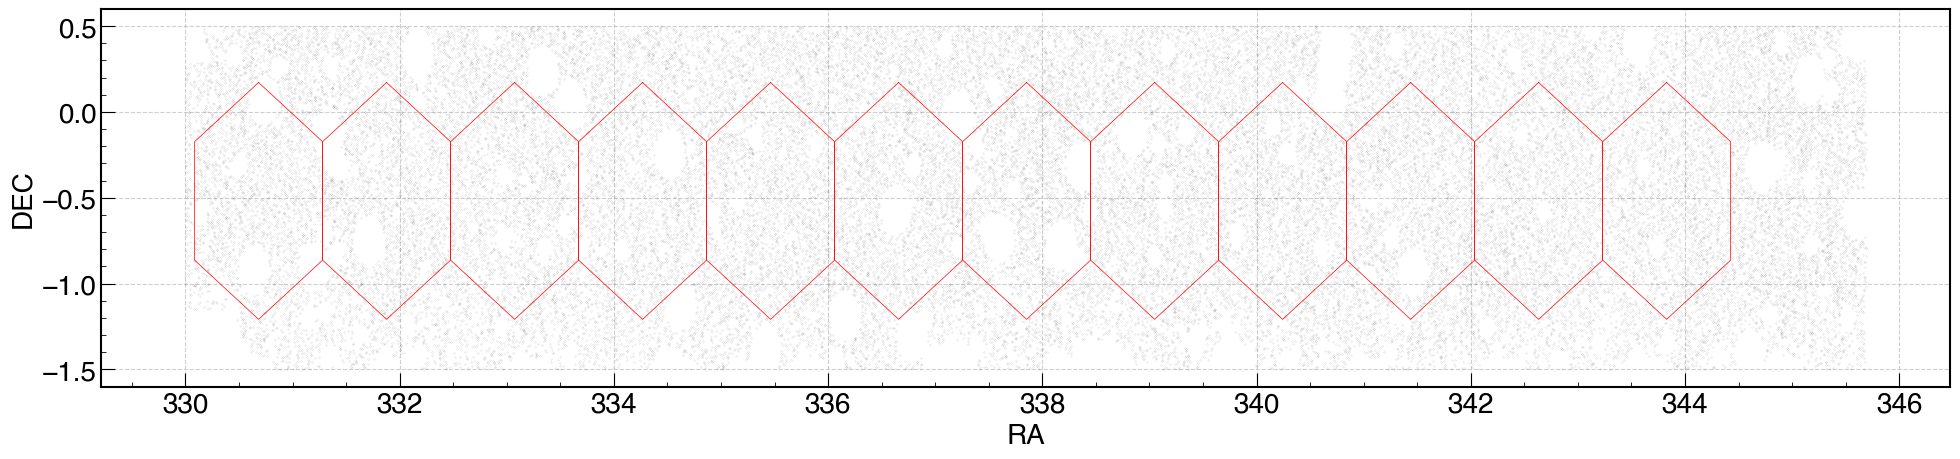

Time passed - read pointings and plot for a small region: 2.52 secs


In [7]:
# TODO: revise the two-stage code structure
two_stage = True
outdir = "../output/test/"
    
t0 = time.time()
########################
#cosmology + sky + star targets
fn_list = ["cosmology_region3_3h_targets.ecsv", "star_region3_3h_targets.ecsv", "sky_region3_3h_targets.ecsv"]
prefix_list = ["sci", "cal", "sky"]
calibration_list = [False, True, True]
    
tgt_s0, sample_sci = construct_tgt_list(catalog_path = "../data_proc/test/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
    
'''
# TODO: prepare ancillary science targets (smaller size sample)
#anxillary science targets
fn_list = ["anc_select.ecsv", ]
prefix_list = ["anc", ]
calibration_list = [False, ]
    
tgt_s1, sample_sci_s1 = construct_tgt_list(catalog_path = "../data_proc/", fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
'''

#total targets
#tgt = tgt_s0 + tgt_s1
tgt = tgt_s0
    
n_sci = sample_sci.shape[0]
ra_sci = sample_sci[:, 1].astype('float')
dec_sci = sample_sci[:, 2].astype('float')

t1 = time.time()
print("Time passed - construct target list: %.2f secs" % (t1-t0))

#set the range for getting pointing centers
ra_min, ra_max, dec_min, dec_max = 330, 345, -1.5, 0.5

# read the pointing centers from the file
ra_peaks, dec_peaks = read_pointings("../output/cosmology_region3_pointings.txt")

# select peaks within the range
mask_peaks = (ra_peaks>ra_min) & (ra_peaks<ra_max) & (dec_peaks>dec_min) & (dec_peaks<dec_max)
peaks = np.array([ra_peaks[mask_peaks], dec_peaks[mask_peaks]]).T
npoint = peaks.shape[0]
print("There are %d pointings." % npoint)
    
# plot the pointing and samples
plt.figure(figsize=(20, 5))
print("  Your sample (gray), with the pointings (red):")
fov_diag = 1.38/2. # deg, here it's radius
mask_sci = (ra_sci>ra_min-fov_diag) & (ra_sci<ra_max+fov_diag) & (dec_sci>dec_min-fov_diag) & (dec_sci<dec_max+fov_diag)
plt.plot(ra_sci[mask_sci][::10], dec_sci[mask_sci][::10], 'k.', ms=0.2, alpha=0.5)

for raP, decP in zip(peaks[:, 0], peaks[:, 1]):
    flag_fov_reserved = plot_filter_fov(raP, decP, ra_sci[mask_sci], dec_sci[mask_sci], PA=0, n_sci_fov_least=4000, filter_fov=True)

plt.xlabel('RA', fontsize=20)
plt.ylabel('DEC', fontsize=20)
plt.savefig(outdir + 'cosmology_region3_test_fov_plot.png')
plt.show()
plt.close()
    
t2 = time.time()
print("Time passed - read pointings and plot for a small region: %.2f secs" % (t2-t1))

## other setting

In [17]:
tele_params = {"otime":"2025-08-20T11:00:00Z", "posang":0.}
gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0, heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)


########################
classdict = def_classdict()

########################
# one visit -- can be 1st or 2nd visit
# TODO: set the alreadyObserved dictionary using the alreadyObserved column in the target list
alreadyObserved={}
for t in tgt:
    alreadyObserved[t.ID] = 0

# set the stage of cosmology targets to be 1 (i.e. stage=0 for calibration targets to get a uniform distribution for calibration targets)
# TODO: use CobraGroup to get a uniform distribution for calibration targets
for t in tgt:
    if t.targetclass[:3] == 'sci': t.stage = 1

## run_main function

In [25]:
#if __name__ == "__main__":
# main run
def run_main(peaks, tgt, classdict, alreadyObserved, two_stage=True, collision_sim_version=2, bench=None, cobracoach=None, gurobiOptions=None, tele_params=None):
    '''
    test for one pointing
    '''
    outfn_list = []
    for peak in peaks[:1]:
        # select the tgt list for the pointing
        tgt_ra = [tgt[i].ra for i in range(len(tgt))]
        tgt_dec = [tgt[i].dec for i in range(len(tgt))]
        # TO-DO: deal with the case when the ra is near 0 and 360
        mask_tgt = (tgt_ra>peak[0]-fov_diag) & (tgt_ra<peak[0]+fov_diag) & (tgt_dec>peak[1]-fov_diag) & (tgt_dec<peak[1]+fov_diag)
        tgt_peak = np.array(tgt)[mask_tgt].tolist()

        # (Done) TODO: update the alreadyObserved dictionary
        # TODO: rewrite the write_output and cal_completeness part

        # excute the fiber assignment
        res, tpos, telescopes = execute(np.array([peak]), tgt_peak, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

        outfn = 'cosmology_region3_3h_output_v1_ra%.2f_dec%.2f.txt'%(peak[0], peak[1])
        write_output(tgt_peak, res, tpos, telescopes, outdir, outfn)

        outfn_list.append(outdir + outfn)
        
        # calculate the completeness and fiber assignment fraction
        comp_out_tmp1 = cal_completeness(tgt_peak, res, tpos, telescopes, Plot=True, fn_fig=outdir+'cosmology_region3_3h_v1_ra%.2f_dec%.2f.jpg'%(peak[0], peak[1]), Save=True, fn_fibeff=outdir+'cosmology_region3_3h_fibeff_v1.txt')
        
        # output the completeness and fiber assignment fraction
        data_dict = {key: [value] for key, value in comp_out_tmp1.items()}
        df = pd.DataFrame(data_dict)
        df.to_csv(outdir + 'cosmology_region3_3h_v1_ra%.2f_dec%.2f.csv'%(peak[0], peak[1]), index=False)
        print("comp_out_tmp1 = ", comp_out_tmp1)

        # update alreadyObserved
        # TODO: revise the code for a more general case
        tgt_id_done = np.loadtxt(outdir + outfn, usecols=(0, ), unpack=True, dtype='str')
        for t in tgt_id_done:
            if(t[:3]=='sci'): alreadyObserved[str(t)] = 1

    print("%f secs passed after the visits done." % (time.time()-t0))

    plot_tgt_done(outfn_list, outdir+'tgt_done_region3_3h_v1.jpg', figsize=(6, 5))
    plot_tgt_done(outfn_list, outdir+'tgt_done_region3_3h_v1_gray.jpg', figsize=(6, 5), plot_diffcolor=False)

# test bench setting

+ pfs_instdata tagged 1.8.14 ? This contains the latest xml file. 
https://github.com/Subaru-PFS/pfs_instdata/releases/tag/1.8.14
+ for pfs_utils, could we use the latest tagged version, w.2024.45
https://github.com/Subaru-PFS/pfs_utils/releases/tag/w.2024.45

## full + CollisionSimulator

Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-13 12:32:21.228Z root             10 CoordTransp.py:306 0.0
2025-01-13 12:32:21.232Z root             20 DistortionCoefficients.py:688 2016.0
2025-01-13 12:32:21.234Z root             10 DistortionCoefficients.py:690 9.635751768195725 yr
2025-01-13 12:32:21.235Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-01-13 12:32:21.449Z root             20 DistortionCoefficients.py:709 Ra Dec = (330.682912 -0.518103) : original
2025-01-13 12:32:21.457Z root             20 DistortionCoefficients.py:711 PM = (0.0 mas / yr 0.0 mas / yr)
2025-01-13 12:32:21.459Z root             20 DistortionCoefficients.py:713 Ra Dec = (330.68291199999993 -0.518103) : applied proper motion
2025-01-13 12:32:21.461Z root             20 DistortionCoefficients.py:715 Ra Dec 

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-13 12:32:22.192Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:32:22.196Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:32:22.199Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:32:22.202Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:32:22.205Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:32:33.068Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:32:33.073Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:32:33.078Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:32:33.087Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:32:33.090Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:32:33.098Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 128835 rows, 67221 columns and 333358 nonzeros


2025-01-13 12:32:33.101Z gurobipy         20 netflow.py:149 Optimize a model with 128835 rows, 67221 columns and 333358 nonzeros


Model fingerprint: 0x88f24c33


2025-01-13 12:32:33.111Z gurobipy         20 netflow.py:149 Model fingerprint: 0x88f24c33


Variable types: 1 continuous, 67220 integer (67218 binary)


2025-01-13 12:32:33.115Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 67220 integer (67218 binary)


Coefficient statistics:


2025-01-13 12:32:33.124Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:32:33.127Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-01, 1e+06]


2025-01-13 12:32:33.129Z gurobipy         20 netflow.py:149   Objective range  [2e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:32:33.133Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:32:33.137Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:32:33.156Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 127927 rows and 64113 columns


2025-01-13 12:32:33.984Z gurobipy         20 netflow.py:149 Presolve removed 127927 rows and 64113 columns


Presolve time: 0.81s


2025-01-13 12:32:33.989Z gurobipy         20 netflow.py:149 Presolve time: 0.81s


Presolved: 908 rows, 3108 columns, 5177 nonzeros


2025-01-13 12:32:34.002Z gurobipy         20 netflow.py:149 Presolved: 908 rows, 3108 columns, 5177 nonzeros


Variable types: 0 continuous, 3108 integer (3106 binary)


2025-01-13 12:32:34.017Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3108 integer (3106 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:32:34.025Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:32:34.037Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:32:34.040Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:32:34.045Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:32:34.051Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:32:34.056Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:32:34.060Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:32:34.064Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:32:34.067Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.955e+03


2025-01-13 12:32:34.122Z gurobipy         20 netflow.py:149  AA' NZ     : 1.955e+03


 Factor NZ  : 4.512e+03 (roughly 2 MB of memory)


2025-01-13 12:32:34.126Z gurobipy         20 netflow.py:149  Factor NZ  : 4.512e+03 (roughly 2 MB of memory)


 Factor Ops : 3.367e+04 (less than 1 second per iteration)


2025-01-13 12:32:34.129Z gurobipy         20 netflow.py:149  Factor Ops : 3.367e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:32:34.133Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:32:34.137Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:32:34.141Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:32:34.144Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.65859257e+08 -2.35641474e+09  2.97e+01 2.74e+04  2.88e+07     1s


2025-01-13 12:32:34.147Z gurobipy         20 netflow.py:149    0   3.65859257e+08 -2.35641474e+09  2.97e+01 2.74e+04  2.88e+07     1s


2025-01-13 12:32:34.153Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.06 seconds (0.34 work units)


2025-01-13 12:32:34.157Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.06 seconds (0.34 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:32:34.161Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:32:34.164Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:32:34.168Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:32:34.172Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:32:34.176Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:32:34.183Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.310828e+02, 86 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:32:34.189Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.310828e+02, 86 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:32:34.255Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:32:34.259Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:32:34.263Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:32:34.266Z gurobipy         20 netflow.py:149 


*    0     0               0     131.0828273  131.08283  0.00%     -    1s


2025-01-13 12:32:34.268Z gurobipy         20 netflow.py:149 *    0     0               0     131.0828273  131.08283  0.00%     -    1s


2025-01-13 12:32:34.292Z gurobipy         20 netflow.py:149 


Explored 1 nodes (86 simplex iterations) in 1.20 seconds (0.34 work units)


2025-01-13 12:32:34.294Z gurobipy         20 netflow.py:149 Explored 1 nodes (86 simplex iterations) in 1.20 seconds (0.34 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:32:34.296Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:32:34.299Z gurobipy         20 netflow.py:149 


Solution count 3: 131.083 5.98e+08 6e+08 


2025-01-13 12:32:34.301Z gurobipy         20 netflow.py:149 Solution count 3: 131.083 5.98e+08 6e+08 


2025-01-13 12:32:34.304Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:32:34.307Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.310828273431e+02, best bound 1.310828273431e+02, gap 0.0000%


2025-01-13 12:32:34.312Z gurobipy         20 netflow.py:149 Best objective 1.310828273431e+02, best bound 1.310828273431e+02, gap 0.0000%


Checking for trajectory collisions
trajectory collisions found: 0
Done: solving the problem for stage=0 targets.
solving the problem for stage=1 targets.
Set parameter Presolve to value 1


2025-01-13 12:32:36.471Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:32:36.475Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:32:36.479Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:32:36.483Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:32:36.492Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:32:49.166Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:32:49.169Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:32:49.173Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:32:49.176Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:32:49.180Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:32:49.217Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 63222 rows, 62985 columns and 175951 nonzeros


2025-01-13 12:32:49.221Z gurobipy         20 netflow.py:149 Optimize a model with 63222 rows, 62985 columns and 175951 nonzeros


Model fingerprint: 0x7926910d


2025-01-13 12:32:49.230Z gurobipy         20 netflow.py:149 Model fingerprint: 0x7926910d


Variable types: 1 continuous, 62984 integer (48631 binary)


2025-01-13 12:32:49.291Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 62984 integer (48631 binary)


Coefficient statistics:


2025-01-13 12:32:49.302Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:32:49.311Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [2e-01, 1e+06]


2025-01-13 12:32:49.332Z gurobipy         20 netflow.py:149   Objective range  [2e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:32:49.339Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+04]


2025-01-13 12:32:49.342Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 1e+04]


Found heuristic solution: objective 2870131.0828


2025-01-13 12:32:49.371Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 2870131.0828


Presolve removed 63222 rows and 62985 columns


2025-01-13 12:32:49.680Z gurobipy         20 netflow.py:149 Presolve removed 63222 rows and 62985 columns


Presolve time: 0.30s


2025-01-13 12:32:49.697Z gurobipy         20 netflow.py:149 Presolve time: 0.30s


Presolve: All rows and columns removed


2025-01-13 12:32:49.722Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-13 12:32:49.754Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.57 seconds (0.09 work units)


2025-01-13 12:32:49.790Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.57 seconds (0.09 work units)


Thread count was 1 (of 8 available processors)


2025-01-13 12:32:49.885Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-13 12:32:49.902Z gurobipy         20 netflow.py:149 


Solution count 2: 2.56611e+06 2.87013e+06 


2025-01-13 12:32:49.906Z gurobipy         20 netflow.py:149 Solution count 2: 2.56611e+06 2.87013e+06 


2025-01-13 12:32:49.909Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:32:49.913Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 2.566114003385e+06, best bound 2.566114003385e+06, gap 0.0000%


2025-01-13 12:32:49.917Z gurobipy         20 netflow.py:149 Best objective 2.566114003385e+06, best bound 2.566114003385e+06, gap 0.0000%


Checking for trajectory collisions
trajectory collisions found: 0
Done: solving the problem for stage=1 targets.
objVal0 = 131.082827, objVal1=2566114.003385
exposure 0:
  assigned Cobras: 2122
   sci_P1: 1522
   cal: 200
   sky: 400
exposure 0:
assigned Cobras(%): 88.64%; gal--63.58%, anc--0.00%, sky--16.71%, star--8.35%
comp_out= {'cal': 0.34305317324185247, 'sci_P1': 0.0683860531991373, 'sky': 0.008197897239358105}
['sci_P1']


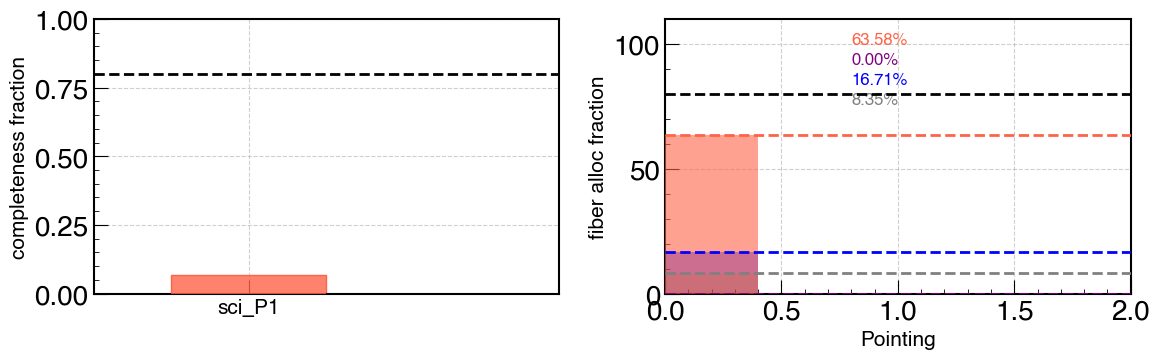

comp_out_tmp1 =  {'cal': 0.34305317324185247, 'sci_P1': 0.0683860531991373, 'sky': 0.008197897239358105}
1718.195299 secs passed after the visits done.


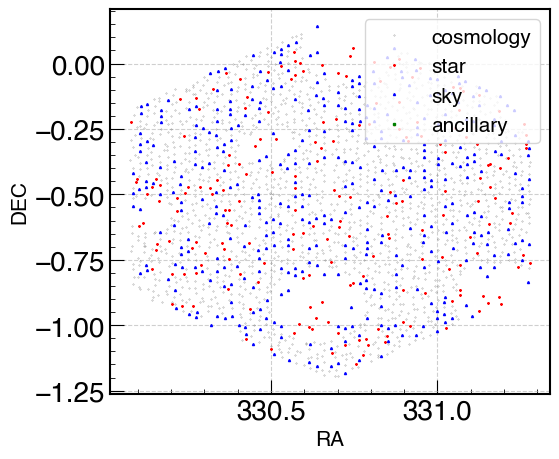

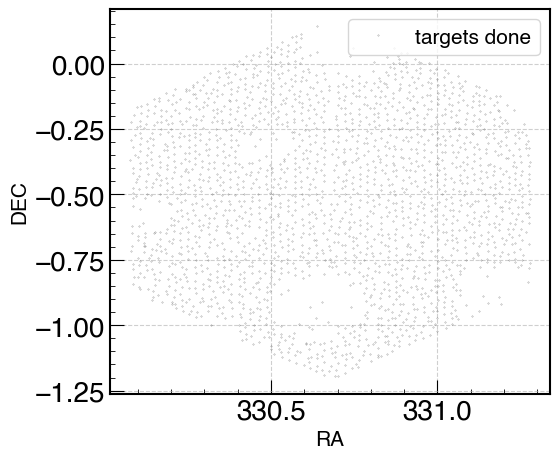

In [ ]:
'''
Comment: successfully tested for one pointing within 43 seconds
'''
bench, cobracoach = create_bench(layout="full")
collision_sim_version = 0
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

## calibration_ga + CollisionSimulator2

In [37]:
'''
Comment: can not get results without trajectory collision even if I run the code for more than 10 minutes
---------------------------------------------------------------------------
ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
'''
bench, cobracoach = create_bench(layout="calibration_ga")
collision_sim_version = 2
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-13 12:55:50.429Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-13 12:55:50.509Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 50, 173, 193, 347, 361, 648, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1520, 1580, 1653, 1724, 1791, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-13 12:55:50.526Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-01-13 12:55:50.529Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250113_005


Cobras with zero centers: 0
Cobras with zero link lengths: 0


2025-01-13 12:55:55.810Z root             10 CoordTransp.py:306 0.0
2025-01-13 12:55:55.814Z root             20 DistortionCoefficients.py:688 2016.0
2025-01-13 12:55:55.815Z root             10 DistortionCoefficients.py:690 9.635751768195725 yr
2025-01-13 12:55:55.817Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-01-13 12:55:55.964Z root             20 DistortionCoefficients.py:709 Ra Dec = (330.682912 -0.518103) : original
2025-01-13 12:55:55.970Z root             20 DistortionCoefficients.py:711 PM = (0.0 mas / yr 0.0 mas / yr)
2025-01-13 12:55:55.972Z root             20 DistortionCoefficients.py:713 Ra Dec = (330.68291199999993 -0.518103) : applied proper motion
2025-01-13 12:55:55.974Z root             20 DistortionCoefficients.py:715 Ra Dec 

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-13 12:55:56.633Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:55:56.635Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:55:56.646Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:55:56.649Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:55:56.650Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:06.674Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:06.676Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:56:06.679Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:06.680Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:06.682Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:56:06.687Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:56:06.689Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:56:06.698Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:56:06.701Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:56:06.705Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:56:06.707Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:56:06.712Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:56:06.724Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:56:06.736Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:56:06.774Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:56:07.515Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.71s


2025-01-13 12:56:07.517Z gurobipy         20 netflow.py:149 Presolve time: 0.71s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:56:07.524Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:56:07.534Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:56:07.537Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:56:07.551Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:56:07.554Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:56:07.557Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:56:07.564Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:56:07.568Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:56:07.570Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:56:07.578Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:56:07.590Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:56:07.596Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:56:07.683Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:56:07.686Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:56:07.689Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:56:07.694Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:56:07.699Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:56:07.702Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:07.705Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:07.708Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


2025-01-13 12:56:07.713Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:07.717Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:07.720Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.15s (can be avoided by choosing Method=3)


2025-01-13 12:56:07.723Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.15s (can be avoided by choosing Method=3)


2025-01-13 12:56:07.727Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:56:07.730Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:56:07.734Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.19 seconds (0.00 work units)


2025-01-13 12:56:07.737Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.19 seconds (0.00 work units)


2025-01-13 12:56:07.773Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:56:07.775Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:07.779Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:07.781Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:07.784Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:07.801Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.12 seconds (0.35 work units)


2025-01-13 12:56:07.803Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.12 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:56:07.806Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:56:07.809Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:07.812Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:07.815Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:56:07.818Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:56:07.824Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:56:08.415Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:56:08.416Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:08.683Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:08.714Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:08.719Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:56:08.721Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:56:08.724Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:56:08.729Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:56:08.801Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:56:08.842Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:56:17.815Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:56:17.817Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:56:17.819Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:56:17.822Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:56:17.824Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:29.180Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:29.182Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:56:29.184Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:29.186Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:29.189Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:56:29.193Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:56:29.194Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:56:29.201Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:56:29.209Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:56:29.214Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:56:29.216Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:56:29.218Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:56:29.220Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:56:29.228Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:56:29.248Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:56:29.980Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-13 12:56:29.982Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:56:29.987Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:56:29.993Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:56:30.001Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:56:30.015Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:56:30.018Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:56:30.020Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:56:30.041Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:56:30.047Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:56:30.096Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:56:30.099Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:56:30.101Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:56:30.105Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:56:30.107Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:56:30.111Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:56:30.114Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:56:30.118Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:56:30.122Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:56:30.125Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:30.128Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:30.131Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


2025-01-13 12:56:30.133Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:30.140Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:30.149Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:56:30.152Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:56:30.160Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:56:30.163Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:56:30.168Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.16 seconds (0.00 work units)


2025-01-13 12:56:30.171Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.16 seconds (0.00 work units)


2025-01-13 12:56:30.200Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:56:30.202Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:30.204Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:30.207Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:30.209Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:30.224Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


2025-01-13 12:56:30.226Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:56:30.228Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:56:30.231Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:30.233Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:30.236Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:56:30.240Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:56:30.244Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:56:30.912Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:56:30.913Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:31.049Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:31.085Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:31.089Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:56:31.090Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:56:31.091Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:56:31.092Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:56:31.120Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:56:31.149Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:56:39.235Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:56:39.236Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:56:39.239Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:56:39.240Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:56:39.244Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:49.529Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:56:49.531Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:56:49.534Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:49.536Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:56:49.538Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:56:49.541Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:56:49.543Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:56:49.553Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:56:49.562Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:56:49.566Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:56:49.568Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:56:49.571Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:56:49.572Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:56:49.574Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:56:49.595Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:56:50.438Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.82s


2025-01-13 12:56:50.439Z gurobipy         20 netflow.py:149 Presolve time: 0.82s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:56:50.445Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:56:50.452Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:56:50.458Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:56:50.463Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:56:50.467Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:56:50.470Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:56:50.495Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:56:50.497Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:56:50.500Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:56:50.631Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:56:50.637Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:56:50.640Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:56:50.643Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:56:50.646Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:56:50.648Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:56:50.652Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:56:50.655Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:56:50.659Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:50.662Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:56:50.665Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.12 seconds (0.35 work units)


2025-01-13 12:56:50.667Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.12 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:50.670Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:56:50.673Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.18s (can be avoided by choosing Method=3)


2025-01-13 12:56:50.675Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.18s (can be avoided by choosing Method=3)


2025-01-13 12:56:50.678Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:56:50.680Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:56:50.685Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.22 seconds (0.00 work units)


2025-01-13 12:56:50.688Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.22 seconds (0.00 work units)


2025-01-13 12:56:50.712Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:56:50.715Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:50.718Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:56:50.721Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:50.775Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:56:50.811Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.27 seconds (0.35 work units)


2025-01-13 12:56:50.813Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.27 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:56:50.816Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:56:50.819Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:50.821Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:56:50.824Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:56:50.827Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:56:50.833Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:56:51.446Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:56:51.447Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:51.572Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:51.606Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:56:51.609Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:56:51.610Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:56:51.611Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:56:51.612Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:56:51.639Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:56:51.665Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:56:59.822Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:56:59.825Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:56:59.827Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:56:59.828Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:56:59.832Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:09.360Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:09.362Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:57:09.364Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:09.366Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:09.368Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:57:09.372Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:57:09.373Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:57:09.382Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:57:09.384Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:57:09.401Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:57:09.403Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:57:09.405Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:57:09.407Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:57:09.410Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:57:09.472Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:57:10.189Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-13 12:57:10.191Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:57:10.197Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:57:10.207Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:57:10.214Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:57:10.223Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:57:10.235Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:57:10.238Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:57:10.329Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:57:10.332Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:57:10.335Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:57:10.340Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:57:10.342Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:57:10.346Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:57:10.349Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:57:10.352Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:57:10.356Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:57:10.360Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:57:10.362Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:57:10.364Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:10.368Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:10.370Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


2025-01-13 12:57:10.373Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:10.376Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:10.379Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.07s


2025-01-13 12:57:10.382Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.07s


2025-01-13 12:57:10.385Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:57:10.387Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:57:10.392Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.18 seconds (0.00 work units)


2025-01-13 12:57:10.396Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.18 seconds (0.00 work units)


2025-01-13 12:57:10.420Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:57:10.422Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:10.425Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:10.430Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:57:10.433Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:57:10.449Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.08 seconds (0.35 work units)


2025-01-13 12:57:10.451Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.08 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:57:10.453Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:57:10.456Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:10.459Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:10.461Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:57:10.464Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:57:10.468Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:57:11.238Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:57:11.239Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:11.372Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:11.409Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:11.412Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:57:11.414Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:57:11.415Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:57:11.415Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:57:11.446Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:57:11.472Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:57:19.438Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:57:19.440Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:57:19.441Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:57:19.443Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:57:19.444Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:30.756Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:30.758Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:57:30.760Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:30.762Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:30.764Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:57:30.768Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:57:30.771Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:57:30.778Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:57:30.780Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:57:30.784Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:57:30.786Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:57:30.789Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:57:30.791Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:57:30.793Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:57:30.816Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:57:31.485Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.65s


2025-01-13 12:57:31.487Z gurobipy         20 netflow.py:149 Presolve time: 0.65s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:57:31.493Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:57:31.498Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:57:31.501Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:57:31.509Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:57:31.512Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:57:31.514Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:57:31.520Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:57:31.524Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:57:31.526Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:57:31.529Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:57:31.531Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:57:31.534Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:57:31.538Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:57:31.540Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:57:31.543Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:57:31.545Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:57:31.549Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:57:31.550Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:31.552Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:31.556Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.79 seconds (0.35 work units)


2025-01-13 12:57:31.559Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.79 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:31.562Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:31.568Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:57:31.574Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:57:31.577Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:57:31.579Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:57:31.642Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.13 seconds (0.00 work units)


2025-01-13 12:57:31.662Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.13 seconds (0.00 work units)


2025-01-13 12:57:31.689Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:57:31.691Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:31.693Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:31.695Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:57:31.698Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:57:31.716Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


2025-01-13 12:57:31.718Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:57:31.720Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:57:31.723Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:31.728Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:31.739Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:57:31.741Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:57:31.745Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:57:32.309Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:57:32.310Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:32.424Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:32.457Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:32.460Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:57:32.461Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:57:32.462Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:57:32.463Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:57:32.489Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:57:32.516Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:57:40.669Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:57:40.672Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:57:40.673Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:57:40.677Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:57:40.679Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:51.117Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:57:51.118Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:57:51.121Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:51.122Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:57:51.124Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:57:51.128Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:57:51.130Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:57:51.135Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:57:51.137Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:57:51.141Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:57:51.143Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:57:51.145Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:57:51.151Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:57:51.153Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:57:51.175Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:57:51.856Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.66s


2025-01-13 12:57:51.858Z gurobipy         20 netflow.py:149 Presolve time: 0.66s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:57:51.863Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:57:51.870Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:57:51.873Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:57:51.884Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:57:51.885Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:57:51.888Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:57:51.898Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:57:51.900Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:57:51.903Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:57:51.907Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:57:51.911Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:57:51.913Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:57:51.919Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:57:51.922Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:57:51.925Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:57:51.928Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:57:51.931Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:57:51.933Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:51.935Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:57:51.941Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


2025-01-13 12:57:51.943Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:51.944Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:57:51.946Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:57:51.952Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:57:51.956Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:57:51.957Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:57:52.023Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:57:52.025Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:57:52.050Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:57:52.053Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:52.055Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:57:52.058Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:57:52.060Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:57:52.075Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


2025-01-13 12:57:52.077Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:57:52.081Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:57:52.083Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:52.085Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:57:52.087Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:57:52.089Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:57:52.093Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:57:52.635Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:57:52.636Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:52.753Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:52.786Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:57:52.789Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:57:52.790Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:57:52.791Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:57:52.792Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:57:52.817Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:57:52.840Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:58:00.930Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:58:00.931Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:58:00.934Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:58:00.936Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:58:00.940Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:10.316Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:10.318Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:58:10.320Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:10.322Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:10.325Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:58:10.329Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:58:10.331Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:58:10.336Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:58:10.340Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:58:10.345Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:58:10.347Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:58:10.349Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:58:10.351Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:58:10.354Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:58:10.380Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:58:11.054Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.65s


2025-01-13 12:58:11.055Z gurobipy         20 netflow.py:149 Presolve time: 0.65s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:58:11.062Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:58:11.068Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:58:11.071Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:58:11.076Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:58:11.080Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:58:11.082Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:58:11.086Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:58:11.088Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:58:11.092Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:58:11.094Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:58:11.100Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:58:11.103Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:58:11.105Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:58:11.106Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:58:11.108Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:58:11.112Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:58:11.114Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:58:11.118Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:11.121Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:11.124Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 12:58:11.128Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:11.130Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:11.132Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:58:11.133Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:58:11.135Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:58:11.138Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:58:11.144Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:58:11.145Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:58:11.155Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:58:11.159Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:11.161Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:11.162Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:58:11.167Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:58:11.183Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.86 seconds (0.35 work units)


2025-01-13 12:58:11.185Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.86 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:58:11.245Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:58:11.255Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:11.263Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:11.267Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:58:11.270Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:58:11.276Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:58:11.765Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:58:11.766Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:11.880Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:11.912Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:11.915Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:58:11.916Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:58:11.917Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:58:11.918Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:58:11.943Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:58:11.966Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:58:19.918Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:58:19.919Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:58:19.923Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:58:19.925Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:58:19.927Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:31.720Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:31.723Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:58:31.725Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:31.728Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:31.730Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:58:31.737Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:58:31.739Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:58:31.752Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:58:31.756Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:58:31.764Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:58:31.766Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:58:31.778Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:58:31.779Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:58:31.785Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:58:31.826Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:58:32.706Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.85s


2025-01-13 12:58:32.708Z gurobipy         20 netflow.py:149 Presolve time: 0.85s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:58:32.714Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:58:32.721Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:58:32.725Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:58:32.737Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:58:32.739Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:58:32.741Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:58:32.747Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:58:32.748Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:58:32.750Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:58:32.753Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:58:32.784Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:58:32.831Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:58:32.835Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:58:32.837Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:58:32.840Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:58:32.842Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:58:32.844Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:58:32.846Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:32.849Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:32.852Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.12 seconds (0.35 work units)


2025-01-13 12:58:32.854Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.12 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:32.857Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:32.859Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:58:32.862Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.11s (can be avoided by choosing Method=3)


2025-01-13 12:58:32.864Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:58:32.867Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:58:32.875Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:58:32.878Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 12:58:32.905Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:58:32.908Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:32.909Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:32.910Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:58:32.912Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:58:32.927Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.19 seconds (0.35 work units)


2025-01-13 12:58:32.928Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.19 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:58:32.930Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:58:32.932Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:32.936Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:32.938Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:58:32.940Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:58:32.945Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:58:33.495Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:58:33.496Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:33.620Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:33.655Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:33.658Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:58:33.659Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:58:33.660Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:58:33.661Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:58:33.692Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:58:33.717Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:58:42.259Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:58:42.261Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:58:42.263Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:58:42.266Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:58:42.269Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:53.114Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:58:53.115Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:58:53.118Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:53.119Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:58:53.121Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:58:53.125Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:58:53.127Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:58:53.132Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:58:53.133Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:58:53.138Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:58:53.139Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:58:53.140Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:58:53.143Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:58:53.145Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:58:53.224Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:58:54.163Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.91s


2025-01-13 12:58:54.165Z gurobipy         20 netflow.py:149 Presolve time: 0.91s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:58:54.172Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:58:54.178Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:58:54.182Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:58:54.187Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:58:54.189Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:58:54.191Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:58:54.198Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:58:54.200Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:58:54.202Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:58:54.204Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:58:54.205Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:58:54.208Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:58:54.210Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:58:54.216Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:58:54.217Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:58:54.226Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:58:54.229Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:58:54.231Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:54.235Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:58:54.238Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.11 seconds (0.35 work units)


2025-01-13 12:58:54.240Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.11 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:54.242Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:58:54.251Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:58:54.253Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:58:54.255Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:58:54.267Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:58:54.280Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.09 seconds (0.00 work units)


2025-01-13 12:58:54.284Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.09 seconds (0.00 work units)


2025-01-13 12:58:54.293Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:58:54.295Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:54.298Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:58:54.301Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:58:54.304Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:58:54.322Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.20 seconds (0.35 work units)


2025-01-13 12:58:54.324Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.20 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:58:54.333Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:58:54.338Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:54.341Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:58:54.343Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:58:54.348Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:58:54.357Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:58:55.021Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:58:55.022Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:55.160Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:55.196Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:58:55.199Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:58:55.201Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:58:55.201Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:58:55.202Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:58:55.227Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:58:55.253Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:59:03.936Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:59:03.939Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:59:03.943Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:59:03.946Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:59:03.948Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:15.438Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:15.441Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:59:15.444Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:15.446Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:15.448Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:59:15.452Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:59:15.454Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:59:15.461Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:59:15.466Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:59:15.473Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:59:15.475Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:59:15.477Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:59:15.478Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:59:15.480Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:59:15.505Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:59:16.321Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.78s


2025-01-13 12:59:16.323Z gurobipy         20 netflow.py:149 Presolve time: 0.78s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:59:16.330Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:59:16.336Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:59:16.340Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:59:16.346Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:59:16.347Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:59:16.348Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:59:16.353Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:59:16.355Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:59:16.359Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:59:16.362Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:59:16.364Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:59:16.365Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:59:16.369Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:59:16.372Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:59:16.374Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:59:16.377Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:59:16.378Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:59:16.379Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:16.384Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:16.386Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


2025-01-13 12:59:16.387Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:16.389Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:16.396Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 12:59:16.398Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 12:59:16.400Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:59:16.401Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:59:16.411Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:59:16.413Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:59:16.418Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:59:16.427Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:16.437Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:16.439Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:59:16.441Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:59:16.469Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


2025-01-13 12:59:16.470Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:59:16.472Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:59:16.476Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:16.479Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:16.481Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:59:16.483Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:59:16.495Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:59:17.198Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:59:17.199Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:17.331Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:17.368Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:17.372Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:59:17.373Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:59:17.374Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:59:17.374Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:59:17.405Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:59:17.429Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:59:25.440Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:59:25.441Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:59:25.444Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:59:25.447Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:59:25.450Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:35.362Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:35.364Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:59:35.370Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:35.372Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:35.373Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:59:35.378Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:59:35.380Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:59:35.386Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:59:35.388Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:59:35.404Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:59:35.405Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:59:35.407Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:59:35.409Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:59:35.412Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:59:35.443Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:59:36.331Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.77s


2025-01-13 12:59:36.332Z gurobipy         20 netflow.py:149 Presolve time: 0.77s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:59:36.339Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:59:36.346Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:59:36.349Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:59:36.353Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:59:36.356Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:59:36.357Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:59:36.361Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:59:36.363Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:59:36.365Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:59:36.370Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:59:36.372Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:59:36.373Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:59:36.378Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:59:36.380Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:59:36.382Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:59:36.385Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:59:36.393Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:59:36.395Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:36.396Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:36.398Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


2025-01-13 12:59:36.399Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:36.405Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:36.408Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:59:36.411Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:59:36.414Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:59:36.420Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:59:36.424Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:59:36.426Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 12:59:36.442Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:59:36.444Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:36.450Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:36.594Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:59:36.598Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 12:59:36.614Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.24 seconds (0.35 work units)


2025-01-13 12:59:36.616Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.24 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:59:36.618Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:59:36.620Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:36.622Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:36.624Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:59:36.626Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:59:36.630Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:59:37.277Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:59:37.279Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:37.397Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:37.431Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:37.436Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:59:37.437Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:59:37.438Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:59:37.439Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:59:37.463Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:59:37.490Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 12:59:45.883Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:59:45.885Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:59:45.887Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:59:45.889Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:59:45.892Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:56.859Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:59:56.860Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:59:56.863Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:56.866Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:59:56.868Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:59:56.872Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 12:59:56.873Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 12:59:56.877Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 12:59:56.881Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 12:59:56.884Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:59:56.888Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 12:59:56.889Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:59:56.891Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:59:56.893Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:59:56.915Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 12:59:57.610Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.66s


2025-01-13 12:59:57.613Z gurobipy         20 netflow.py:149 Presolve time: 0.66s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 12:59:57.619Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 12:59:57.626Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 12:59:57.629Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 12:59:57.635Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 12:59:57.636Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 12:59:57.637Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 12:59:57.640Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 12:59:57.642Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 12:59:57.648Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 12:59:57.650Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 12:59:57.651Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 12:59:57.653Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 12:59:57.654Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 12:59:57.661Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 12:59:57.662Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 12:59:57.666Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 12:59:57.667Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 12:59:57.671Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:57.674Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 12:59:57.676Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


2025-01-13 12:59:57.690Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:57.692Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 12:59:57.694Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 12:59:57.698Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 12:59:57.704Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 12:59:57.706Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 12:59:57.710Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 12:59:57.711Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 12:59:57.729Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 12:59:57.731Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:57.736Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 12:59:57.741Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:59:57.744Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 12:59:57.765Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.90 seconds (0.35 work units)


2025-01-13 12:59:57.767Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.90 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:59:57.768Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:59:57.770Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:57.772Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 12:59:57.778Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:59:57.782Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 12:59:57.786Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:59:58.334Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:59:58.335Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:58.448Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:58.481Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:59:58.483Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 12:59:58.484Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 12:59:58.485Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:59:58.486Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:59:58.510Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:59:58.533Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:00:06.336Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:00:06.337Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:00:06.340Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:00:06.342Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:00:06.344Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:00:15.793Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:00:15.797Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:00:15.799Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:00:15.802Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:00:15.805Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:00:15.808Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:00:15.810Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:00:15.814Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:00:15.816Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:00:15.823Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:00:15.826Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:00:15.829Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:00:15.846Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:00:15.848Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:00:15.878Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:00:16.603Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.70s


2025-01-13 13:00:16.606Z gurobipy         20 netflow.py:149 Presolve time: 0.70s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:00:16.612Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:00:16.618Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:00:16.621Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:00:16.628Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:00:16.629Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:00:16.631Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:00:16.638Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:00:16.641Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:00:16.643Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:00:16.645Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:00:16.647Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:00:16.648Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:00:16.649Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:00:16.652Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:00:16.654Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:00:16.661Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:00:16.662Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:00:16.666Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:00:16.669Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:00:16.670Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.86 seconds (0.35 work units)


2025-01-13 13:00:16.709Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.86 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:00:16.763Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:00:16.777Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.14s (can be avoided by choosing Method=3)


2025-01-13 13:00:16.779Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.14s (can be avoided by choosing Method=3)


2025-01-13 13:00:16.781Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:00:16.783Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:00:16.788Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.16 seconds (0.00 work units)


2025-01-13 13:00:16.791Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.16 seconds (0.00 work units)


2025-01-13 13:00:16.814Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:00:16.816Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:00:16.817Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:00:16.818Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:00:16.820Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:00:16.835Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


2025-01-13 13:00:16.837Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:00:16.839Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:00:16.840Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:00:16.844Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:00:16.846Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:00:16.848Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:00:16.852Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:00:17.361Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:00:17.362Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:00:17.493Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:00:17.526Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:00:17.529Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:00:17.531Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:00:17.531Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:00:17.532Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:00:17.558Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:00:17.581Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:00:25.485Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:00:25.486Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:00:25.489Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:00:25.491Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:00:25.495Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:00:36.435Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:00:36.437Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:00:36.439Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:00:36.441Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:00:36.443Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:00:36.447Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:00:36.449Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:00:36.454Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:00:36.455Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:00:36.459Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:00:36.460Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:00:36.461Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:00:36.462Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:00:36.468Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:00:36.492Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:00:37.174Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.65s


2025-01-13 13:00:37.175Z gurobipy         20 netflow.py:149 Presolve time: 0.65s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:00:37.181Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:00:37.188Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:00:37.191Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:00:37.196Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:00:37.201Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:00:37.205Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:00:37.210Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:00:37.213Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:00:37.215Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:00:37.217Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:00:37.219Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:00:37.220Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:00:37.222Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:00:37.223Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:00:37.226Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:00:37.229Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:00:37.236Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:00:37.240Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:00:37.244Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:00:37.245Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 13:00:37.246Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:00:37.248Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:00:37.249Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:00:37.251Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:00:37.253Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:00:37.258Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:00:37.269Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 13:00:37.271Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 13:00:37.282Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:00:37.285Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:00:37.286Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:00:37.288Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:00:37.289Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:00:37.316Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.87 seconds (0.35 work units)


2025-01-13 13:00:37.321Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.87 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:00:37.323Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:00:37.325Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:00:37.326Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:00:37.328Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:00:37.329Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:00:37.339Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:00:37.948Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:00:37.949Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:00:38.063Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:00:38.097Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:00:38.102Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:00:38.103Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:00:38.103Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:00:38.104Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:00:38.128Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:00:38.152Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:00:45.940Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:00:45.941Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:00:45.942Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:00:45.944Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:00:45.947Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:00:56.194Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:00:56.196Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:00:56.198Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:00:56.200Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:00:56.202Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:00:56.206Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:00:56.208Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:00:56.214Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:00:56.215Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:00:56.218Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:00:56.220Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:00:56.221Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:00:56.222Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:00:56.224Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:00:56.248Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:00:56.930Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.66s


2025-01-13 13:00:56.932Z gurobipy         20 netflow.py:149 Presolve time: 0.66s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:00:56.938Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:00:56.946Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:00:56.949Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:00:56.953Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:00:56.954Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:00:56.956Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:00:56.960Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:00:56.961Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:00:56.963Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:00:56.971Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:00:56.975Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:00:56.980Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:00:56.981Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:00:56.983Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:00:56.984Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:00:56.986Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:00:56.988Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:00:56.990Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:00:56.998Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:00:56.999Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 13:00:57.001Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:00:57.003Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:00:57.005Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:00:57.006Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:00:57.008Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:00:57.014Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:00:57.020Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:00:57.022Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:00:57.037Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:00:57.038Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:00:57.040Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:00:57.047Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:00:57.049Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:00:57.070Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.87 seconds (0.35 work units)


2025-01-13 13:00:57.071Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.87 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:00:57.078Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:00:57.080Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:00:57.081Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:00:57.083Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:00:57.084Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:00:57.089Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:00:57.658Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:00:57.659Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:00:57.772Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:00:57.805Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:00:57.809Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:00:57.811Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:00:57.812Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:00:57.813Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:00:57.838Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:00:57.865Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:01:05.562Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:01:05.565Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:01:05.567Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:01:05.569Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:01:05.571Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:01:15.725Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:01:15.726Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:01:15.729Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:01:15.731Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:01:15.733Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:01:15.737Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:01:15.739Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:01:15.743Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:01:15.744Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:01:15.748Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:01:15.749Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:01:15.750Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:01:15.752Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:01:15.755Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:01:15.774Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:01:16.449Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.65s


2025-01-13 13:01:16.451Z gurobipy         20 netflow.py:149 Presolve time: 0.65s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:01:16.458Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:01:16.465Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:01:16.467Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:01:16.473Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:01:16.474Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:01:16.476Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:01:16.479Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:01:16.481Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:01:16.483Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:01:16.488Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:01:16.491Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:01:16.493Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:01:16.494Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:01:16.496Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:01:16.497Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:01:16.500Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:01:16.501Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:01:16.503Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:01:16.505Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:01:16.507Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.77 seconds (0.35 work units)


2025-01-13 13:01:16.512Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.77 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:01:16.514Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:01:16.516Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:01:16.518Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:01:16.522Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:01:16.523Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:01:16.527Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:01:16.530Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:01:16.544Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:01:16.546Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:01:16.547Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:01:16.549Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:01:16.558Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:01:16.580Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.85 seconds (0.35 work units)


2025-01-13 13:01:16.583Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.85 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:01:16.588Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:01:16.590Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:01:16.591Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:01:16.592Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:01:16.594Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:01:16.598Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:01:17.170Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:01:17.171Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:01:17.293Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:01:17.326Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:01:17.329Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:01:17.330Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:01:17.330Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:01:17.331Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:01:17.358Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:01:17.381Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:01:25.113Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:01:25.114Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:01:25.117Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:01:25.119Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:01:25.122Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:01:34.190Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:01:34.192Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:01:34.196Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:01:34.198Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:01:34.199Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:01:34.204Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:01:34.206Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:01:34.210Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:01:34.212Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:01:34.216Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:01:34.218Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:01:34.219Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:01:34.220Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:01:34.222Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:01:34.246Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:01:34.936Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.66s


2025-01-13 13:01:34.938Z gurobipy         20 netflow.py:149 Presolve time: 0.66s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:01:34.944Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:01:34.950Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:01:34.953Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:01:34.957Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:01:34.959Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:01:34.960Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:01:34.966Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:01:34.969Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:01:34.971Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:01:34.973Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:01:34.984Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:01:34.986Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:01:34.987Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:01:34.988Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:01:34.990Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:01:34.992Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:01:34.993Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:01:34.995Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:01:35.001Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:01:35.006Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 13:01:35.008Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:01:35.011Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:01:35.013Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 13:01:35.019Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 13:01:35.022Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:01:35.024Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:01:35.027Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:01:35.029Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:01:35.051Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:01:35.053Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:01:35.055Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:01:35.057Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:01:35.060Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:01:35.081Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


2025-01-13 13:01:35.083Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:01:35.085Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:01:35.087Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:01:35.089Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:01:35.090Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:01:35.091Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:01:35.121Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:01:35.669Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:01:35.670Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:01:35.790Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:01:35.822Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:01:35.825Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:01:35.826Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:01:35.827Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:01:35.828Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:01:35.853Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:01:35.877Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:01:43.808Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:01:43.810Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:01:43.812Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:01:43.814Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:01:43.816Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:01:54.965Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:01:54.966Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:01:54.969Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:01:54.971Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:01:54.974Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:01:54.977Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:01:54.979Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:01:54.984Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:01:54.986Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:01:54.989Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:01:54.991Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:01:54.992Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:01:54.994Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:01:54.995Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:01:55.019Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:01:55.708Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.64s


2025-01-13 13:01:55.709Z gurobipy         20 netflow.py:149 Presolve time: 0.64s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:01:55.716Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:01:55.722Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:01:55.725Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:01:55.730Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:01:55.732Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:01:55.733Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:01:55.736Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:01:55.738Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:01:55.743Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:01:55.745Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:01:55.747Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:01:55.748Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:01:55.750Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:01:55.752Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:01:55.754Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:01:55.757Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:01:55.759Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:01:55.761Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:01:55.763Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:01:55.764Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.79 seconds (0.35 work units)


2025-01-13 13:01:55.766Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.79 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:01:55.767Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:01:55.768Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:01:55.770Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:01:55.777Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:01:55.779Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:01:55.788Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:01:55.790Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:01:55.810Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:01:55.811Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:01:55.813Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:01:55.815Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:01:55.819Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:01:55.838Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.86 seconds (0.35 work units)


2025-01-13 13:01:55.843Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.86 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:01:55.852Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:01:55.854Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:01:55.856Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:01:55.857Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:01:55.859Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:01:55.867Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:01:56.449Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:01:56.450Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:01:56.570Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:01:56.603Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:01:56.606Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:01:56.608Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:01:56.609Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:01:56.610Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:01:56.635Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:01:56.659Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:02:04.356Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:02:04.357Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:02:04.360Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:02:04.362Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:02:04.364Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:02:13.425Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:02:13.426Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:02:13.429Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:02:13.431Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:02:13.433Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:02:13.437Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:02:13.438Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:02:13.443Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:02:13.445Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:02:13.448Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:02:13.452Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:02:13.453Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:02:13.454Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:02:13.455Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:02:13.477Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:02:14.160Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.65s


2025-01-13 13:02:14.162Z gurobipy         20 netflow.py:149 Presolve time: 0.65s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:02:14.169Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:02:14.174Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:02:14.177Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:02:14.184Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:02:14.186Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:02:14.187Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:02:14.190Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:02:14.192Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:02:14.196Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:02:14.198Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:02:14.201Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:02:14.203Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:02:14.205Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:02:14.207Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:02:14.209Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:02:14.211Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:02:14.213Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:02:14.217Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:02:14.219Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:02:14.220Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.78 seconds (0.35 work units)


2025-01-13 13:02:14.221Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.78 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:02:14.223Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:02:14.224Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:02:14.226Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:02:14.227Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:02:14.229Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:02:14.240Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:02:14.242Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:02:14.248Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:02:14.252Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:02:14.254Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:02:14.256Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:02:14.257Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:02:14.279Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.84 seconds (0.35 work units)


2025-01-13 13:02:14.281Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.84 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:02:14.287Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:02:14.291Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:02:14.294Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:02:14.298Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:02:14.300Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:02:14.306Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:02:14.925Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:02:14.926Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:02:15.045Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:02:15.078Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:02:15.081Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:02:15.082Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:02:15.084Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:02:15.085Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:02:15.109Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:02:15.133Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:02:22.874Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:02:22.875Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:02:22.877Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:02:22.879Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:02:22.881Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:02:33.895Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:02:33.897Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:02:33.898Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:02:33.900Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:02:33.902Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:02:33.906Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:02:33.907Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:02:33.912Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:02:33.914Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:02:33.917Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:02:33.918Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:02:33.920Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:02:33.921Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:02:33.922Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:02:33.948Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:02:34.647Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.66s


2025-01-13 13:02:34.648Z gurobipy         20 netflow.py:149 Presolve time: 0.66s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:02:34.654Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:02:34.662Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:02:34.665Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:02:34.670Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:02:34.671Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:02:34.673Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:02:34.676Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:02:34.677Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:02:34.679Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:02:34.683Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:02:34.684Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:02:34.686Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:02:34.687Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:02:34.688Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:02:34.690Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:02:34.692Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:02:34.696Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:02:34.698Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:02:34.700Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:02:34.704Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 13:02:34.707Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:02:34.709Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:02:34.711Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:02:34.713Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:02:34.715Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:02:34.716Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:02:34.719Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:02:34.721Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:02:34.737Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:02:34.741Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:02:34.743Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:02:34.745Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:02:34.747Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:02:34.770Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.87 seconds (0.35 work units)


2025-01-13 13:02:34.776Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.87 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:02:34.780Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:02:34.782Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:02:34.783Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:02:34.785Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:02:34.786Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:02:34.790Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:02:35.414Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:02:35.415Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:02:35.532Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:02:35.566Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:02:35.569Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:02:35.570Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:02:35.571Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:02:35.572Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:02:35.597Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:02:35.619Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:02:43.334Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:02:43.335Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:02:43.338Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:02:43.339Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:02:43.341Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:02:53.576Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:02:53.578Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:02:53.581Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:02:53.583Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:02:53.585Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:02:53.589Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:02:53.591Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:02:53.595Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:02:53.597Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:02:53.600Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:02:53.601Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:02:53.605Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:02:53.606Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:02:53.608Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:02:53.629Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:02:54.318Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.66s


2025-01-13 13:02:54.321Z gurobipy         20 netflow.py:149 Presolve time: 0.66s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:02:54.327Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:02:54.332Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:02:54.335Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:02:54.342Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:02:54.343Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:02:54.344Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:02:54.347Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:02:54.348Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:02:54.350Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:02:54.352Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:02:54.355Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:02:54.357Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:02:54.358Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:02:54.360Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:02:54.364Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:02:54.366Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:02:54.367Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:02:54.369Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:02:54.375Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:02:54.377Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.79 seconds (0.35 work units)


2025-01-13 13:02:54.379Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.79 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:02:54.381Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:02:54.383Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:02:54.384Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:02:54.385Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:02:54.387Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:02:54.391Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:02:54.392Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:02:54.410Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:02:54.411Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:02:54.413Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:02:54.414Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:02:54.416Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:02:54.434Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.85 seconds (0.35 work units)


2025-01-13 13:02:54.439Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.85 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:02:54.441Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:02:54.443Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:02:54.445Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:02:54.446Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:02:54.452Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:02:54.457Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:02:55.035Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:02:55.037Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:02:55.161Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:02:55.195Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:02:55.198Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:02:55.199Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:02:55.200Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:02:55.201Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:02:55.226Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:02:55.249Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:03:03.047Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:03:03.049Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:03:03.052Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:03:03.055Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:03:03.059Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:03:12.122Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:03:12.123Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:03:12.126Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:03:12.128Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:03:12.131Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:03:12.135Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:03:12.136Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:03:12.140Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:03:12.142Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:03:12.145Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:03:12.148Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:03:12.149Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:03:12.150Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:03:12.151Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:03:12.177Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:03:12.860Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.65s


2025-01-13 13:03:12.861Z gurobipy         20 netflow.py:149 Presolve time: 0.65s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:03:12.867Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:03:12.873Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:03:12.876Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:03:12.882Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:03:12.883Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:03:12.884Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:03:12.887Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:03:12.889Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:03:12.890Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:03:12.892Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:03:12.894Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:03:12.898Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:03:12.899Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:03:12.901Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:03:12.902Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:03:12.904Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:03:12.908Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:03:12.909Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:03:12.911Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:03:12.915Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.78 seconds (0.35 work units)


2025-01-13 13:03:12.916Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.78 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:03:12.918Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:03:12.920Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:03:12.924Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:03:12.926Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:03:12.927Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:03:12.931Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:03:12.933Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:03:12.938Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:03:12.940Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:03:12.941Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:03:12.943Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:03:12.944Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:03:12.982Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.85 seconds (0.35 work units)


2025-01-13 13:03:12.984Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.85 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:03:12.986Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:03:12.988Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:03:12.989Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:03:12.991Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:03:12.992Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:03:12.997Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:03:13.572Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:03:13.572Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:03:13.693Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:03:13.727Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:03:13.730Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:03:13.731Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:03:13.732Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:03:13.733Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:03:13.758Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:03:13.781Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:03:21.481Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:03:21.482Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:03:21.486Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:03:21.488Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:03:21.490Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:03:32.574Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:03:32.576Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:03:32.579Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:03:32.581Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:03:32.583Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:03:32.587Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:03:32.589Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:03:32.596Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:03:32.598Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:03:32.601Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:03:32.603Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:03:32.604Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:03:32.606Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:03:32.608Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:03:32.642Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:03:33.344Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.67s


2025-01-13 13:03:33.346Z gurobipy         20 netflow.py:149 Presolve time: 0.67s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:03:33.352Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:03:33.358Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:03:33.361Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:03:33.366Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:03:33.367Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:03:33.369Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:03:33.372Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:03:33.373Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:03:33.375Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:03:33.378Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:03:33.380Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:03:33.382Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:03:33.383Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:03:33.385Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:03:33.394Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:03:33.397Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:03:33.399Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:03:33.401Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:03:33.403Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:03:33.405Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


2025-01-13 13:03:33.407Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:03:33.409Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:03:33.410Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:03:33.412Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:03:33.413Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:03:33.415Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:03:33.417Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:03:33.419Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:03:33.437Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:03:33.439Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:03:33.440Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:03:33.442Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:03:33.445Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:03:33.467Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


2025-01-13 13:03:33.469Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:03:33.471Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:03:33.472Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:03:33.474Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:03:33.477Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:03:33.481Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:03:33.493Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:03:34.064Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:03:34.065Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:03:34.182Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:03:34.216Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:03:34.219Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:03:34.220Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:03:34.220Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:03:34.221Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:03:34.247Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:03:34.270Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:03:42.046Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:03:42.048Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:03:42.050Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:03:42.052Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:03:42.054Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:03:52.285Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:03:52.287Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:03:52.289Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:03:52.291Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:03:52.293Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:03:52.296Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:03:52.298Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:03:52.303Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:03:52.305Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:03:52.308Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:03:52.309Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:03:52.311Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:03:52.312Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:03:52.313Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:03:52.330Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:03:53.032Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.67s


2025-01-13 13:03:53.035Z gurobipy         20 netflow.py:149 Presolve time: 0.67s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:03:53.040Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:03:53.048Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:03:53.052Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:03:53.057Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:03:53.059Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:03:53.060Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:03:53.063Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:03:53.064Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:03:53.066Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:03:53.073Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:03:53.074Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:03:53.079Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:03:53.081Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:03:53.082Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:03:53.084Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:03:53.088Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:03:53.090Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:03:53.092Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:03:53.094Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:03:53.095Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 13:03:53.097Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:03:53.105Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:03:53.108Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 13:03:53.110Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 13:03:53.113Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:03:53.114Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:03:53.118Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:03:53.119Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:03:53.125Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:03:53.127Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:03:53.129Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:03:53.131Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:03:53.133Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:03:53.152Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.86 seconds (0.35 work units)


2025-01-13 13:03:53.159Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.86 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:03:53.161Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:03:53.162Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:03:53.168Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:03:53.170Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:03:53.172Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:03:53.176Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:03:53.740Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:03:53.741Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:03:53.858Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:03:53.891Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:03:53.895Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:03:53.896Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:03:53.896Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:03:53.897Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:03:53.922Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:03:53.946Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:04:02.153Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:04:02.154Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:04:02.158Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:04:02.161Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:04:02.163Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:04:12.833Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:04:12.835Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:04:12.837Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:04:12.839Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:04:12.842Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:04:12.847Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:04:12.848Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:04:12.853Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:04:12.854Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:04:12.857Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:04:12.859Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:04:12.860Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:04:12.862Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:04:12.864Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:04:12.883Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:04:13.614Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.66s


2025-01-13 13:04:13.616Z gurobipy         20 netflow.py:149 Presolve time: 0.66s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:04:13.621Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:04:13.627Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:04:13.630Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:04:13.635Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:04:13.636Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:04:13.637Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:04:13.641Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:04:13.643Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:04:13.647Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:04:13.649Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:04:13.651Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:04:13.655Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:04:13.657Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:04:13.659Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:04:13.661Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:04:13.665Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:04:13.666Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:04:13.668Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:04:13.670Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:04:13.671Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.83 seconds (0.35 work units)


2025-01-13 13:04:13.673Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.83 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:04:13.674Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:04:13.676Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:04:13.683Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:04:13.686Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:04:13.688Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:04:13.694Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:04:13.696Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:04:13.701Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:04:13.703Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:04:13.704Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:04:13.706Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:04:13.707Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:04:13.759Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.91 seconds (0.35 work units)


2025-01-13 13:04:13.763Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.91 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:04:13.766Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:04:13.768Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:04:13.769Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:04:13.771Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:04:13.773Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:04:13.780Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:04:14.422Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:04:14.423Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:04:14.541Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:04:14.574Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:04:14.577Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:04:14.579Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:04:14.580Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:04:14.581Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:04:14.605Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:04:14.628Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:04:22.557Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:04:22.559Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:04:22.561Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:04:22.564Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:04:22.566Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:04:32.799Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:04:32.801Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:04:32.805Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:04:32.807Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:04:32.810Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:04:32.815Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:04:32.817Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:04:32.824Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:04:32.826Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:04:32.830Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:04:32.831Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:04:32.832Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:04:32.834Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:04:32.835Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:04:32.927Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:04:33.794Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.84s


2025-01-13 13:04:33.796Z gurobipy         20 netflow.py:149 Presolve time: 0.84s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:04:33.804Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:04:33.811Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:04:33.814Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:04:33.823Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:04:33.826Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:04:33.830Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:04:33.837Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:04:33.853Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:04:33.868Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:04:33.873Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:04:33.876Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:04:33.886Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:04:33.892Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:04:33.894Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:04:33.896Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:04:33.901Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:04:33.904Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:04:33.906Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:04:33.908Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:04:33.911Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.10 seconds (0.35 work units)


2025-01-13 13:04:33.913Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.10 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:04:33.916Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:04:33.918Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.08s


2025-01-13 13:04:33.922Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.08s


2025-01-13 13:04:33.924Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:04:33.926Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:04:33.934Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.12 seconds (0.00 work units)


2025-01-13 13:04:33.942Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.12 seconds (0.00 work units)


2025-01-13 13:04:33.953Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:04:33.956Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:04:33.958Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:04:33.960Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:04:33.962Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:04:33.984Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.17 seconds (0.35 work units)


2025-01-13 13:04:34.000Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.17 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:04:34.007Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:04:34.037Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:04:34.039Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:04:34.041Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:04:34.047Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:04:34.054Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:04:34.702Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:04:34.704Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:04:34.851Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:04:34.884Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:04:34.886Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:04:34.887Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:04:34.889Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:04:34.891Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:04:34.916Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:04:34.939Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:04:43.081Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:04:43.083Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:04:43.085Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:04:43.087Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:04:43.089Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:04:54.849Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:04:54.851Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:04:54.853Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:04:54.856Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:04:54.858Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:04:54.861Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:04:54.863Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:04:54.869Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:04:54.870Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:04:54.874Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:04:54.875Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:04:54.876Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:04:54.878Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:04:54.879Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:04:54.895Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:04:55.616Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-13 13:04:55.618Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:04:55.624Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:04:55.630Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:04:55.634Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:04:55.639Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:04:55.640Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:04:55.642Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:04:55.645Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:04:55.646Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:04:55.648Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:04:55.651Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:04:55.652Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:04:55.654Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:04:55.656Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:04:55.657Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:04:55.659Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:04:55.662Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:04:55.664Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:04:55.674Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:04:55.677Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:04:55.678Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


2025-01-13 13:04:55.680Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:04:55.681Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:04:55.683Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:04:55.685Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:04:55.688Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:04:55.689Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:04:55.694Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:04:55.695Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:04:55.712Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:04:55.713Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:04:55.715Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:04:55.716Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:04:55.718Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:04:55.753Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


2025-01-13 13:04:55.755Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:04:55.757Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:04:55.759Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:04:55.761Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:04:55.762Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:04:55.763Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:04:55.777Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:04:56.443Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:04:56.444Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:04:56.579Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:04:56.614Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:04:56.618Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:04:56.619Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:04:56.620Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:04:56.622Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:04:56.648Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:04:56.672Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:05:04.846Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:05:04.848Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:05:04.850Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:05:04.853Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:05:04.854Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:05:14.199Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:05:14.201Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:05:14.203Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:05:14.206Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:05:14.207Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:05:14.212Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:05:14.213Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:05:14.218Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:05:14.220Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:05:14.223Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:05:14.225Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:05:14.226Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:05:14.228Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:05:14.229Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:05:14.251Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:05:14.983Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.71s


2025-01-13 13:05:14.984Z gurobipy         20 netflow.py:149 Presolve time: 0.71s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:05:14.991Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:05:14.999Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:05:15.003Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:05:15.008Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:05:15.013Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:05:15.014Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:05:15.018Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:05:15.019Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:05:15.021Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:05:15.023Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:05:15.035Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:05:15.037Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:05:15.041Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:05:15.042Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:05:15.048Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:05:15.051Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:05:15.052Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:05:15.055Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:05:15.057Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:05:15.068Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.86 seconds (0.35 work units)


2025-01-13 13:05:15.070Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.86 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:05:15.071Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:05:15.073Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.06s


2025-01-13 13:05:15.074Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.06s


2025-01-13 13:05:15.078Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:05:15.080Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:05:15.085Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 13:05:15.086Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 13:05:15.096Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:05:15.099Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:05:15.102Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:05:15.104Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:05:15.106Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:05:15.140Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.93 seconds (0.35 work units)


2025-01-13 13:05:15.142Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.93 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:05:15.147Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:05:15.149Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:05:15.150Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:05:15.152Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:05:15.154Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:05:15.290Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:05:15.852Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:05:15.853Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:05:16.139Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:05:16.183Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:05:16.188Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:05:16.189Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:05:16.189Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:05:16.191Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:05:16.220Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:05:16.244Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:05:24.946Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:05:24.950Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:05:24.952Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:05:24.954Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:05:24.956Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:05:37.003Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:05:37.006Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:05:37.009Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:05:37.012Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:05:37.014Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:05:37.018Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:05:37.019Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:05:37.025Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:05:37.027Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:05:37.031Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:05:37.032Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:05:37.034Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:05:37.035Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:05:37.037Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:05:37.061Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:05:37.786Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.70s


2025-01-13 13:05:37.790Z gurobipy         20 netflow.py:149 Presolve time: 0.70s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:05:37.796Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:05:37.802Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:05:37.804Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:05:37.810Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:05:37.811Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:05:37.813Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:05:37.817Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:05:37.819Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:05:37.820Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:05:37.825Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:05:37.828Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:05:37.833Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:05:37.836Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:05:37.840Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:05:37.844Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:05:37.848Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:05:37.850Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:05:37.851Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:05:37.856Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:05:37.858Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.84 seconds (0.35 work units)


2025-01-13 13:05:37.861Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.84 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:05:37.866Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:05:37.870Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 13:05:37.872Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 13:05:37.874Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:05:37.877Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:05:37.881Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:05:37.883Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:05:37.901Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:05:37.903Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:05:37.906Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:05:37.929Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:05:37.932Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:05:37.958Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.94 seconds (0.35 work units)


2025-01-13 13:05:37.960Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.94 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:05:37.962Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:05:37.963Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:05:37.965Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:05:37.967Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:05:37.969Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:05:38.047Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:05:38.635Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:05:38.636Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:05:38.762Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:05:38.796Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:05:38.800Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:05:38.801Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:05:38.802Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:05:38.803Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:05:38.829Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:05:38.853Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:05:47.126Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:05:47.128Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:05:47.130Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:05:47.133Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:05:47.134Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:05:56.773Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:05:56.774Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:05:56.777Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:05:56.778Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:05:56.781Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:05:56.784Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:05:56.786Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:05:56.790Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:05:56.791Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:05:56.794Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:05:56.796Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:05:56.797Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:05:56.798Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:05:56.800Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:05:56.815Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:05:57.758Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.83s


2025-01-13 13:05:57.761Z gurobipy         20 netflow.py:149 Presolve time: 0.83s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:05:57.772Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:05:57.778Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:05:57.781Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:05:57.789Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:05:57.793Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:05:57.796Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:05:58.026Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:05:58.029Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:05:58.034Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:05:58.039Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:05:58.043Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:05:58.048Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:05:58.056Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:05:58.061Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:05:58.079Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:05:58.086Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:05:58.089Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:05:58.097Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:05:58.102Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:05:58.107Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.32 seconds (0.35 work units)


2025-01-13 13:05:58.114Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.32 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:05:58.118Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:05:58.122Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.10s


2025-01-13 13:05:58.125Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.10s


2025-01-13 13:05:58.129Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:05:58.133Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:05:58.138Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.35 seconds (0.00 work units)


2025-01-13 13:05:58.141Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.35 seconds (0.00 work units)


2025-01-13 13:05:58.177Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:05:58.180Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:05:58.184Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:05:58.189Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:05:58.192Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:05:58.214Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.43 seconds (0.35 work units)


2025-01-13 13:05:58.217Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.43 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:05:58.221Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:05:58.224Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:05:58.227Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:05:58.230Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:05:58.232Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:05:58.238Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:05:58.838Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:05:58.839Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:05:59.069Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:05:59.104Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:05:59.107Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:05:59.108Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:05:59.109Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:05:59.111Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:05:59.136Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:05:59.160Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:06:07.105Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:06:07.106Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:06:07.109Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:06:07.113Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:06:07.115Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:06:17.476Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:06:17.477Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:06:17.480Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:06:17.482Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:06:17.484Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:06:17.487Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:06:17.489Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:06:17.493Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:06:17.495Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:06:17.498Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:06:17.499Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:06:17.501Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:06:17.502Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:06:17.503Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:06:17.519Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:06:18.231Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.67s


2025-01-13 13:06:18.233Z gurobipy         20 netflow.py:149 Presolve time: 0.67s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:06:18.239Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:06:18.244Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:06:18.247Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:06:18.251Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:06:18.253Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:06:18.254Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:06:18.257Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:06:18.259Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:06:18.261Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:06:18.263Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:06:18.265Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:06:18.266Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:06:18.267Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:06:18.269Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:06:18.270Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:06:18.272Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:06:18.276Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:06:18.280Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:06:18.282Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:06:18.285Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 13:06:18.287Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:06:18.293Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:06:18.296Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:06:18.298Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:06:18.299Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:06:18.301Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:06:18.308Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:06:18.311Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:06:18.332Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:06:18.337Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:06:18.339Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:06:18.346Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:06:18.355Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:06:18.376Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


2025-01-13 13:06:18.378Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:06:18.380Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:06:18.382Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:06:18.385Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:06:18.392Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:06:18.426Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:06:18.429Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:06:18.962Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:06:18.963Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:06:19.077Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:06:19.109Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:06:19.112Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:06:19.113Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:06:19.114Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:06:19.115Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:06:19.138Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:06:19.160Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:06:26.541Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:06:26.542Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:06:26.544Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:06:26.546Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:06:26.548Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:06:35.654Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:06:35.656Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:06:35.658Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:06:35.660Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:06:35.662Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:06:35.667Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:06:35.669Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:06:35.674Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:06:35.675Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:06:35.679Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:06:35.680Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:06:35.682Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:06:35.683Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:06:35.685Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:06:35.703Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:06:36.427Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-13 13:06:36.428Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:06:36.436Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:06:36.443Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:06:36.446Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:06:36.450Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:06:36.452Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:06:36.453Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:06:36.456Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:06:36.458Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:06:36.460Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:06:36.462Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:06:36.463Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:06:36.467Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:06:36.468Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:06:36.469Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:06:36.471Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:06:36.478Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:06:36.480Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:06:36.481Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:06:36.484Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:06:36.486Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


2025-01-13 13:06:36.488Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:06:36.489Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:06:36.490Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:06:36.492Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:06:36.493Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:06:36.495Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:06:36.501Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:06:36.503Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:06:36.520Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:06:36.523Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:06:36.524Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:06:36.526Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:06:36.531Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:06:36.557Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


2025-01-13 13:06:36.559Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:06:36.560Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:06:36.562Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:06:36.565Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:06:36.567Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:06:36.568Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:06:36.573Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:06:37.149Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:06:37.150Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:06:37.267Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:06:37.300Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:06:37.303Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:06:37.304Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:06:37.304Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:06:37.305Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:06:37.329Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:06:37.353Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:06:45.266Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:06:45.267Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:06:45.272Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:06:45.275Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:06:45.276Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:06:56.690Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:06:56.693Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:06:56.695Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:06:56.697Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:06:56.699Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:06:56.702Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:06:56.704Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:06:56.710Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:06:56.711Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:06:56.715Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:06:56.716Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:06:56.717Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:06:56.719Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:06:56.720Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:06:56.736Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:06:57.451Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-13 13:06:57.453Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:06:57.459Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:06:57.465Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:06:57.468Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:06:57.472Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:06:57.474Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:06:57.477Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:06:57.480Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:06:57.481Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:06:57.483Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:06:57.485Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:06:57.487Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:06:57.488Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:06:57.489Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:06:57.491Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:06:57.492Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:06:57.495Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:06:57.499Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:06:57.501Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:06:57.503Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:06:57.504Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 13:06:57.506Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:06:57.511Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:06:57.515Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:06:57.516Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:06:57.518Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:06:57.519Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:06:57.523Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:06:57.525Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:06:57.545Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:06:57.547Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:06:57.564Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:06:57.566Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:06:57.567Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:06:57.593Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


2025-01-13 13:06:57.595Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:06:57.597Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:06:57.598Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:06:57.599Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:06:57.601Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:06:57.602Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:06:57.606Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:06:58.231Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:06:58.231Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:06:58.354Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:06:58.389Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:06:58.392Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:06:58.393Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:06:58.394Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:06:58.395Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:06:58.420Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:06:58.444Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:07:06.829Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:07:06.831Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:07:06.832Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:07:06.835Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:07:06.838Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:07:16.540Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:07:16.542Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:07:16.545Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:07:16.547Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:07:16.549Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:07:16.557Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:07:16.559Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:07:16.565Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:07:16.567Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:07:16.570Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:07:16.572Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:07:16.574Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:07:16.575Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:07:16.576Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:07:16.655Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:07:17.440Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.76s


2025-01-13 13:07:17.441Z gurobipy         20 netflow.py:149 Presolve time: 0.76s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:07:17.448Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:07:17.457Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:07:17.460Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:07:17.465Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:07:17.467Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:07:17.468Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:07:17.473Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:07:17.475Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:07:17.477Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:07:17.479Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:07:17.481Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:07:17.482Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:07:17.483Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:07:17.498Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:07:17.501Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:07:17.513Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:07:17.515Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:07:17.527Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:07:17.538Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:07:17.566Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.01 seconds (0.35 work units)


2025-01-13 13:07:17.594Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.01 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:07:17.596Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:07:17.600Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.13s (can be avoided by choosing Method=3)


2025-01-13 13:07:17.602Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.13s (can be avoided by choosing Method=3)


2025-01-13 13:07:17.603Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:07:17.606Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:07:17.609Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 13:07:17.612Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.15 seconds (0.00 work units)


2025-01-13 13:07:17.630Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:07:17.632Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:07:17.634Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:07:17.636Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:07:17.638Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:07:17.656Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


2025-01-13 13:07:17.660Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:07:17.666Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:07:17.668Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:07:17.670Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:07:17.673Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:07:17.679Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:07:17.686Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:07:18.297Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:07:18.298Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:07:18.423Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:07:18.480Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:07:18.484Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:07:18.487Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:07:18.488Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:07:18.489Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:07:18.522Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:07:18.545Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:07:26.450Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:07:26.451Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:07:26.453Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:07:26.455Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:07:26.458Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:07:37.974Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:07:37.976Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:07:37.978Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:07:37.980Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:07:37.982Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:07:37.986Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:07:37.988Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:07:37.992Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:07:37.994Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:07:37.998Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:07:37.999Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:07:38.001Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:07:38.003Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:07:38.005Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:07:38.024Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:07:38.744Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.67s


2025-01-13 13:07:38.746Z gurobipy         20 netflow.py:149 Presolve time: 0.67s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:07:38.752Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:07:38.758Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:07:38.761Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:07:38.766Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:07:38.768Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:07:38.769Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:07:38.772Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:07:38.774Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:07:38.776Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:07:38.778Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:07:38.779Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:07:38.781Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:07:38.783Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:07:38.784Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:07:38.785Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:07:38.788Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:07:38.789Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:07:38.790Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:07:38.792Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:07:38.793Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


2025-01-13 13:07:38.794Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:07:38.796Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:07:38.801Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:07:38.809Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:07:38.812Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:07:38.816Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:07:38.821Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:07:38.823Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:07:38.828Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:07:38.834Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:07:38.836Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:07:38.838Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:07:38.839Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:07:38.871Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


2025-01-13 13:07:38.880Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:07:38.883Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:07:38.885Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:07:38.887Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:07:38.888Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:07:38.895Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:07:38.905Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:07:39.578Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:07:39.579Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:07:39.706Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:07:39.739Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:07:39.742Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:07:39.743Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:07:39.744Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:07:39.746Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:07:39.770Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:07:39.793Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:07:47.589Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:07:47.591Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:07:47.593Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:07:47.595Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:07:47.597Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:07:58.077Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:07:58.078Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:07:58.081Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:07:58.085Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:07:58.087Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:07:58.094Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:07:58.097Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:07:58.105Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:07:58.110Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:07:58.115Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:07:58.117Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:07:58.119Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:07:58.121Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:07:58.126Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:07:58.203Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:07:58.980Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.73s


2025-01-13 13:07:58.983Z gurobipy         20 netflow.py:149 Presolve time: 0.73s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:07:58.989Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:07:58.995Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:07:58.998Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:07:59.003Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:07:59.005Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:07:59.009Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:07:59.012Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:07:59.014Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:07:59.015Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:07:59.018Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:07:59.019Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:07:59.021Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:07:59.022Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:07:59.024Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:07:59.025Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:07:59.029Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:07:59.030Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:07:59.032Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:07:59.034Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:07:59.039Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


2025-01-13 13:07:59.044Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:07:59.046Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:07:59.051Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:07:59.054Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:07:59.055Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:07:59.057Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:07:59.062Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:07:59.064Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:07:59.070Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:07:59.076Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:07:59.082Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:07:59.085Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:07:59.089Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:07:59.106Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


2025-01-13 13:07:59.110Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:07:59.112Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:07:59.113Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:07:59.115Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:07:59.116Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:07:59.118Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:07:59.263Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:07:59.845Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:07:59.846Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:07:59.993Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:08:00.030Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:08:00.033Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:08:00.034Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:08:00.034Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:08:00.035Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:08:00.063Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:08:00.086Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:08:08.247Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:08:08.249Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:08:08.253Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:08:08.255Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:08:08.258Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:08:17.871Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:08:17.874Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:08:17.876Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:08:17.878Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:08:17.881Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:08:17.889Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:08:17.891Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:08:17.897Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:08:17.898Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:08:17.903Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:08:17.905Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:08:17.906Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:08:17.907Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:08:17.909Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:08:17.956Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:08:18.786Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.79s


2025-01-13 13:08:18.789Z gurobipy         20 netflow.py:149 Presolve time: 0.79s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:08:18.796Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:08:18.803Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:08:18.808Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:08:18.814Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:08:18.960Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:08:18.962Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:08:18.976Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:08:18.978Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:08:18.979Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:08:18.981Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:08:18.982Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:08:18.985Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:08:18.987Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:08:18.988Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:08:18.990Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:08:18.992Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:08:18.994Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:08:18.995Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:08:18.996Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:08:18.998Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.11 seconds (0.35 work units)


2025-01-13 13:08:18.999Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.11 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:08:19.002Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:08:19.004Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:08:19.005Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:08:19.007Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:08:19.009Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:08:19.012Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.20 seconds (0.00 work units)


2025-01-13 13:08:19.014Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.20 seconds (0.00 work units)


2025-01-13 13:08:19.047Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:08:19.060Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:08:19.068Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:08:19.081Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:08:19.087Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:08:19.115Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.22 seconds (0.35 work units)


2025-01-13 13:08:19.128Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.22 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:08:19.138Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:08:19.152Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:08:19.160Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:08:19.162Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:08:19.165Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:08:19.170Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:08:19.821Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:08:19.822Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:08:20.004Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:08:20.044Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:08:20.049Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:08:20.052Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:08:20.053Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:08:20.054Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:08:20.187Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:08:20.213Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:08:28.299Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:08:28.300Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:08:28.302Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:08:28.305Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:08:28.308Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:08:40.617Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:08:40.618Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:08:40.621Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:08:40.624Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:08:40.626Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:08:40.632Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:08:40.634Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:08:40.639Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:08:40.641Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:08:40.645Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:08:40.647Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:08:40.649Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:08:40.651Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:08:40.653Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:08:40.672Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:08:41.447Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.70s


2025-01-13 13:08:41.449Z gurobipy         20 netflow.py:149 Presolve time: 0.70s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:08:41.455Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:08:41.460Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:08:41.465Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:08:41.470Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:08:41.471Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:08:41.473Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:08:41.476Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:08:41.478Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:08:41.480Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:08:41.482Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:08:41.484Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:08:41.485Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:08:41.486Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:08:41.488Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:08:41.489Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:08:41.491Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:08:41.492Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:08:41.494Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:08:41.498Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:08:41.500Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.87 seconds (0.35 work units)


2025-01-13 13:08:41.501Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.87 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:08:41.503Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:08:41.504Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:08:41.506Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:08:41.508Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:08:41.516Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:08:41.521Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:08:41.525Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:08:41.545Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:08:41.547Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:08:41.549Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:08:41.550Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:08:41.552Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:08:41.574Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


2025-01-13 13:08:41.576Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:08:41.577Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:08:41.581Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:08:41.583Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:08:41.584Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:08:41.586Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:08:41.591Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:08:42.187Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:08:42.188Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:08:42.317Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:08:42.350Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:08:42.353Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:08:42.354Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:08:42.355Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:08:42.356Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:08:42.381Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:08:42.405Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:08:50.091Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:08:50.092Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:08:50.094Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:08:50.097Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:08:50.100Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:09:00.400Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:09:00.402Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:09:00.406Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:09:00.408Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:09:00.410Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:09:00.413Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:09:00.415Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:09:00.419Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:09:00.421Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:09:00.425Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:09:00.426Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:09:00.428Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:09:00.429Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:09:00.430Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:09:00.448Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:09:01.160Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.69s


2025-01-13 13:09:01.161Z gurobipy         20 netflow.py:149 Presolve time: 0.69s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:09:01.168Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:09:01.175Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:09:01.178Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:09:01.182Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:09:01.184Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:09:01.185Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:09:01.189Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:09:01.191Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:09:01.193Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:09:01.195Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:09:01.196Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:09:01.198Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:09:01.199Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:09:01.200Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:09:01.202Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:09:01.204Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:09:01.210Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:09:01.213Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:09:01.229Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:09:01.231Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


2025-01-13 13:09:01.235Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:09:01.237Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:09:01.241Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 13:09:01.243Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 13:09:01.245Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:09:01.246Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:09:01.250Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:09:01.252Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:09:01.258Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:09:01.262Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:09:01.264Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:09:01.265Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:09:01.267Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:09:01.310Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.90 seconds (0.35 work units)


2025-01-13 13:09:01.312Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.90 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:09:01.382Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:09:01.404Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:09:01.408Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:09:01.409Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:09:01.410Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:09:01.414Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:09:01.950Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:09:01.951Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:09:02.072Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:09:02.107Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:09:02.110Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:09:02.111Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:09:02.112Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:09:02.113Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:09:02.137Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:09:02.160Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:09:10.037Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:09:10.040Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:09:10.041Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:09:10.046Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:09:10.048Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:09:19.023Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:09:19.024Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:09:19.027Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:09:19.029Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:09:19.031Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:09:19.036Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:09:19.038Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:09:19.042Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:09:19.044Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:09:19.047Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:09:19.050Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:09:19.052Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:09:19.053Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:09:19.055Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:09:19.071Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:09:19.837Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.74s


2025-01-13 13:09:19.838Z gurobipy         20 netflow.py:149 Presolve time: 0.74s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:09:19.844Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:09:19.852Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:09:19.855Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:09:19.859Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:09:19.861Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:09:19.862Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:09:19.865Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:09:19.867Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:09:19.869Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:09:19.871Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:09:19.873Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:09:19.874Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:09:19.875Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:09:19.877Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:09:19.878Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:09:19.880Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:09:19.884Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:09:19.885Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:09:19.886Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:09:19.888Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.85 seconds (0.35 work units)


2025-01-13 13:09:19.889Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.85 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:09:19.890Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:09:19.892Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:09:19.896Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:09:19.898Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:09:19.904Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:09:19.919Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:09:19.921Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:09:19.934Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:09:19.937Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:09:19.938Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:09:19.941Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:09:19.943Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:09:19.964Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.93 seconds (0.35 work units)


2025-01-13 13:09:19.965Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.93 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:09:19.967Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:09:19.968Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:09:19.969Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:09:19.971Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:09:19.972Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:09:19.976Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:09:20.595Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:09:20.596Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:09:20.721Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:09:20.755Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:09:20.757Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:09:20.759Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:09:20.759Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:09:20.760Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:09:20.785Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:09:20.807Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:09:28.512Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:09:28.514Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:09:28.516Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:09:28.518Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:09:28.522Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:09:39.737Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:09:39.738Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:09:39.741Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:09:39.744Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:09:39.745Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:09:39.749Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:09:39.750Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:09:39.755Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:09:39.756Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:09:39.761Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:09:39.762Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:09:39.764Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:09:39.765Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:09:39.767Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:09:39.783Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:09:40.579Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.77s


2025-01-13 13:09:40.581Z gurobipy         20 netflow.py:149 Presolve time: 0.77s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:09:40.587Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:09:40.594Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:09:40.597Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:09:40.601Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:09:40.603Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:09:40.604Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:09:40.607Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:09:40.609Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:09:40.611Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:09:40.613Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:09:40.615Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:09:40.616Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:09:40.617Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:09:40.619Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:09:40.620Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:09:40.622Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:09:40.623Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:09:40.625Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:09:40.629Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:09:40.630Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.88 seconds (0.35 work units)


2025-01-13 13:09:40.632Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.88 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:09:40.633Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:09:40.634Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:09:40.637Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:09:40.638Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:09:40.640Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:09:40.650Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:09:40.652Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:09:40.664Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:09:40.666Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:09:40.667Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:09:40.669Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:09:40.670Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:09:40.690Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.94 seconds (0.35 work units)


2025-01-13 13:09:40.696Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.94 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:09:40.698Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:09:40.700Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:09:40.707Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:09:40.713Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:09:40.714Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:09:40.720Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:09:41.298Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:09:41.299Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:09:41.491Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:09:41.531Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:09:41.539Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:09:41.541Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:09:41.542Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:09:41.545Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:09:41.568Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:09:41.590Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:09:49.391Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:09:49.392Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:09:49.395Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:09:49.399Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:09:49.401Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:09:59.687Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:09:59.689Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:09:59.691Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:09:59.693Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:09:59.694Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:09:59.698Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:09:59.700Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:09:59.707Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:09:59.708Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:09:59.711Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:09:59.713Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:09:59.714Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:09:59.715Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:09:59.717Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:09:59.732Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:10:00.455Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.70s


2025-01-13 13:10:00.456Z gurobipy         20 netflow.py:149 Presolve time: 0.70s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:10:00.463Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:10:00.469Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:10:00.473Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:10:00.478Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:10:00.479Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:10:00.481Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:10:00.484Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:10:00.485Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:10:00.487Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:10:00.490Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:10:00.491Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:10:00.492Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:10:00.494Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:10:00.495Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:10:00.497Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:10:00.499Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:10:00.500Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:10:00.501Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:10:00.506Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:10:00.508Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


2025-01-13 13:10:00.510Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:10:00.512Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:10:00.514Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:10:00.515Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:10:00.517Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:10:00.523Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:10:00.553Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:10:00.556Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.07 seconds (0.00 work units)


2025-01-13 13:10:00.590Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:10:00.592Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:10:00.593Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:10:00.595Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:10:00.597Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:10:00.667Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.97 seconds (0.35 work units)


2025-01-13 13:10:00.671Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.97 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:10:00.673Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:10:00.674Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:10:00.676Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:10:00.678Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:10:00.679Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:10:00.685Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:10:01.331Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:10:01.332Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:10:01.463Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:10:01.496Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:10:01.499Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:10:01.500Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:10:01.501Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:10:01.502Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:10:01.527Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:10:01.550Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:10:09.486Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:10:09.488Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:10:09.490Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:10:09.493Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:10:09.495Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:10:19.826Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:10:19.828Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:10:19.830Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:10:19.833Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:10:19.835Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:10:19.838Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:10:19.840Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:10:19.844Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:10:19.848Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:10:19.851Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:10:19.853Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:10:19.854Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:10:19.855Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:10:19.857Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:10:19.872Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:10:20.601Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.70s


2025-01-13 13:10:20.603Z gurobipy         20 netflow.py:149 Presolve time: 0.70s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:10:20.609Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:10:20.616Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:10:20.619Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:10:20.623Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:10:20.625Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:10:20.626Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:10:20.629Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:10:20.631Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:10:20.633Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:10:20.635Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:10:20.637Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:10:20.639Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:10:20.640Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:10:20.642Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:10:20.643Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:10:20.646Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:10:20.650Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:10:20.651Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:10:20.653Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:10:20.654Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


2025-01-13 13:10:20.655Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:10:20.657Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:10:20.658Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:10:20.660Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:10:20.661Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:10:20.664Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:10:20.671Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:10:20.673Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:10:20.687Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:10:20.689Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:10:20.690Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:10:20.692Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:10:20.694Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:10:20.710Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.87 seconds (0.35 work units)


2025-01-13 13:10:20.712Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.87 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:10:20.716Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:10:20.717Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:10:20.722Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:10:20.723Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:10:20.725Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:10:20.733Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:10:21.333Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:10:21.334Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:10:21.456Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:10:21.489Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:10:21.492Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:10:21.494Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:10:21.494Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:10:21.495Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:10:21.520Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:10:21.543Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:10:29.368Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:10:29.369Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:10:29.372Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:10:29.374Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:10:29.375Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:10:38.382Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:10:38.384Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:10:38.386Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:10:38.391Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:10:38.392Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:10:38.396Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:10:38.398Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:10:38.402Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:10:38.404Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:10:38.407Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:10:38.408Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:10:38.410Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:10:38.411Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:10:38.413Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:10:38.431Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:10:39.150Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.70s


2025-01-13 13:10:39.151Z gurobipy         20 netflow.py:149 Presolve time: 0.70s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:10:39.159Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:10:39.165Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:10:39.168Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:10:39.172Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:10:39.174Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:10:39.176Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:10:39.179Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:10:39.181Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:10:39.183Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:10:39.185Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:10:39.187Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:10:39.188Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:10:39.193Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:10:39.194Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:10:39.195Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:10:39.198Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:10:39.199Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:10:39.200Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:10:39.202Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:10:39.203Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


2025-01-13 13:10:39.204Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.81 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:10:39.206Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:10:39.207Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:10:39.209Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:10:39.210Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:10:39.212Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:10:39.218Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:10:39.220Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:10:39.237Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:10:39.238Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:10:39.240Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:10:39.242Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:10:39.243Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:10:39.270Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


2025-01-13 13:10:39.277Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:10:39.284Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:10:39.286Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:10:39.287Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:10:39.292Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:10:39.294Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:10:39.302Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:10:39.866Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:10:39.867Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:10:40.003Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:10:40.046Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:10:40.050Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:10:40.051Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:10:40.052Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:10:40.054Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:10:40.087Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:10:40.121Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:10:47.846Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:10:47.848Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:10:47.850Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:10:47.852Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:10:47.854Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:10:58.940Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:10:58.942Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:10:58.944Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:10:58.946Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:10:58.949Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:10:58.953Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:10:58.954Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:10:58.959Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:10:58.961Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:10:58.964Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:10:58.967Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:10:58.969Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:10:58.971Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:10:58.972Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:10:58.988Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:10:59.723Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.70s


2025-01-13 13:10:59.724Z gurobipy         20 netflow.py:149 Presolve time: 0.70s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:10:59.730Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:10:59.738Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:10:59.741Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:10:59.745Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:10:59.747Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:10:59.748Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:10:59.752Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:10:59.754Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:10:59.756Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:10:59.758Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:10:59.759Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:10:59.761Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:10:59.762Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:10:59.764Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:10:59.765Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:10:59.770Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:10:59.771Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:10:59.772Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:10:59.774Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:10:59.775Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


2025-01-13 13:10:59.776Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:10:59.778Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:10:59.779Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:10:59.780Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:10:59.782Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:10:59.783Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:10:59.787Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:10:59.788Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:10:59.806Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:10:59.811Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:10:59.815Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:10:59.819Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:10:59.821Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:10:59.840Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


2025-01-13 13:10:59.842Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:10:59.846Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:10:59.852Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:10:59.854Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:10:59.856Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:10:59.858Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:10:59.863Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:11:00.515Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:11:00.516Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:00.739Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:00.776Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:00.779Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:11:00.780Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:11:00.781Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:11:00.781Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:11:00.806Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:11:00.828Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:11:08.645Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:11:08.647Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:11:08.649Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:11:08.651Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:11:08.653Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:11:17.648Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:11:17.649Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:11:17.652Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:11:17.654Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:11:17.656Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:11:17.660Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:11:17.661Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:11:17.666Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:11:17.667Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:11:17.670Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:11:17.672Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:11:17.673Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:11:17.674Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:11:17.678Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:11:17.693Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:11:18.465Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.74s


2025-01-13 13:11:18.467Z gurobipy         20 netflow.py:149 Presolve time: 0.74s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:11:18.472Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:11:18.479Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:11:18.482Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:11:18.486Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:11:18.488Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:11:18.489Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:11:18.493Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:11:18.495Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:11:18.497Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:11:18.499Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:11:18.500Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:11:18.502Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:11:18.503Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:11:18.505Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:11:18.506Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:11:18.511Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:11:18.513Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:11:18.514Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:11:18.516Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:11:18.517Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.86 seconds (0.35 work units)


2025-01-13 13:11:18.518Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.86 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:11:18.520Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:11:18.521Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:11:18.522Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:11:18.524Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:11:18.525Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:11:18.529Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:11:18.530Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:11:18.550Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:11:18.552Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:11:18.554Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:11:18.556Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:11:18.558Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:11:18.574Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.92 seconds (0.35 work units)


2025-01-13 13:11:18.580Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.92 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:11:18.581Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:11:18.583Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:11:18.586Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:11:18.678Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:11:18.682Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:11:18.686Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:11:19.238Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:11:19.239Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:19.426Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:19.465Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:19.470Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:11:19.472Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:11:19.475Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:11:19.477Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:11:19.505Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:11:19.527Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:11:27.159Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:11:27.160Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:11:27.163Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:11:27.165Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:11:27.168Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:11:38.344Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:11:38.346Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:11:38.349Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:11:38.350Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:11:38.352Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:11:38.357Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:11:38.359Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:11:38.363Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:11:38.365Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:11:38.368Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:11:38.369Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:11:38.371Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:11:38.373Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:11:38.374Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:11:38.391Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:11:39.163Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.75s


2025-01-13 13:11:39.165Z gurobipy         20 netflow.py:149 Presolve time: 0.75s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:11:39.171Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:11:39.177Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:11:39.180Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:11:39.184Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:11:39.186Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:11:39.189Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:11:39.192Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:11:39.194Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:11:39.195Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:11:39.198Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:11:39.199Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:11:39.201Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:11:39.202Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:11:39.204Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:11:39.206Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:11:39.208Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:11:39.210Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:11:39.211Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:11:39.213Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:11:39.214Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.86 seconds (0.35 work units)


2025-01-13 13:11:39.215Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.86 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:11:39.217Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:11:39.218Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:11:39.222Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:11:39.224Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:11:39.226Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:11:39.233Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:11:39.235Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:11:39.251Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:11:39.253Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:11:39.257Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:11:39.259Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:11:39.261Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:11:39.278Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.92 seconds (0.35 work units)


2025-01-13 13:11:39.282Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.92 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:11:39.284Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:11:39.286Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:11:39.290Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:11:39.292Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:11:39.294Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:11:39.302Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:11:39.984Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:11:39.985Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:40.164Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:40.202Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:40.205Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:11:40.206Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:11:40.207Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:11:40.208Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:11:40.235Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:11:40.260Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:11:47.961Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:11:47.963Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:11:47.964Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:11:47.965Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:11:47.969Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:11:58.160Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:11:58.162Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:11:58.166Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:11:58.168Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:11:58.169Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:11:58.173Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:11:58.174Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:11:58.179Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:11:58.180Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:11:58.184Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:11:58.186Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:11:58.187Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:11:58.188Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:11:58.190Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:11:58.206Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:11:58.923Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.70s


2025-01-13 13:11:58.924Z gurobipy         20 netflow.py:149 Presolve time: 0.70s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:11:58.932Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:11:58.938Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:11:58.941Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:11:58.945Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:11:58.947Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:11:58.949Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:11:58.952Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:11:58.953Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:11:58.955Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:11:58.957Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:11:58.959Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:11:58.960Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:11:58.962Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:11:58.963Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:11:58.968Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:11:58.970Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:11:58.971Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:11:58.973Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:11:58.974Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:11:58.975Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


2025-01-13 13:11:58.977Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.80 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:11:58.978Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:11:58.980Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:11:58.982Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:11:58.984Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:11:58.985Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:11:58.991Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:11:59.008Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:11:59.023Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:11:59.024Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:11:59.026Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:11:59.028Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:11:59.029Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:11:59.128Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


2025-01-13 13:11:59.133Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.95 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:11:59.136Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:11:59.137Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:11:59.138Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:11:59.140Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:11:59.141Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:11:59.145Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:11:59.759Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:11:59.760Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:59.923Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:59.958Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:11:59.961Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:11:59.962Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:11:59.963Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:11:59.964Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:11:59.989Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:12:00.016Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:12:07.746Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:12:07.748Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:12:07.750Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:12:07.752Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:12:07.755Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:12:17.988Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:12:17.989Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:12:17.992Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:12:17.995Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:12:17.996Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:12:18.000Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:12:18.002Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:12:18.007Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:12:18.011Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:12:18.015Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:12:18.016Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:12:18.018Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:12:18.019Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:12:18.020Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:12:18.037Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:12:18.779Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.72s


2025-01-13 13:12:18.780Z gurobipy         20 netflow.py:149 Presolve time: 0.72s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:12:18.786Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:12:18.792Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:12:18.795Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:12:18.799Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:12:18.801Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:12:18.802Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:12:18.805Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:12:18.808Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:12:18.810Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:12:18.813Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:12:18.814Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:12:18.816Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:12:18.818Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:12:18.819Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:12:18.820Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:12:18.823Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:12:18.824Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:12:18.826Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:12:18.828Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:12:18.829Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.83 seconds (0.35 work units)


2025-01-13 13:12:18.830Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.83 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:12:18.831Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:12:18.833Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:12:18.834Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:12:18.835Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:12:18.837Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:12:18.844Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:12:18.846Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:12:18.877Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:12:18.882Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:12:18.892Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:12:18.895Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:12:18.896Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:12:19.018Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


2025-01-13 13:12:19.020Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:12:19.021Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:12:19.023Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:12:19.024Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:12:19.026Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:12:19.028Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:12:19.032Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:12:19.804Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:12:19.805Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:12:19.927Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:12:19.961Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:12:19.964Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:12:19.965Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:12:19.965Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:12:19.966Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:12:19.992Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:12:20.016Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:12:27.758Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:12:27.759Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:12:27.761Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:12:27.764Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:12:27.766Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:12:36.834Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:12:36.836Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:12:36.838Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:12:36.840Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:12:36.842Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:12:36.845Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:12:36.847Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:12:36.853Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:12:36.854Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:12:36.858Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:12:36.859Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:12:36.860Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:12:36.862Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:12:36.863Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:12:36.879Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:12:37.621Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.72s


2025-01-13 13:12:37.623Z gurobipy         20 netflow.py:149 Presolve time: 0.72s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:12:37.629Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:12:37.634Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:12:37.638Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:12:37.642Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:12:37.644Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:12:37.645Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:12:37.648Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:12:37.649Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:12:37.653Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:12:37.655Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:12:37.657Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:12:37.658Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:12:37.660Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:12:37.662Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:12:37.663Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:12:37.665Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:12:37.667Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:12:37.668Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:12:37.670Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:12:37.672Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.83 seconds (0.35 work units)


2025-01-13 13:12:37.673Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.83 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:12:37.674Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:12:37.676Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:12:37.677Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:12:37.678Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:12:37.679Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:12:37.683Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:12:37.687Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:12:37.714Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:12:37.721Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:12:37.723Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:12:37.725Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:12:37.732Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:12:37.749Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.91 seconds (0.35 work units)


2025-01-13 13:12:37.788Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.91 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:12:37.843Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:12:37.848Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:12:37.849Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:12:37.852Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:12:37.855Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:12:37.859Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:12:38.496Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:12:38.497Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:12:38.625Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:12:38.665Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:12:38.668Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:12:38.670Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:12:38.671Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:12:38.675Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:12:38.705Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:12:38.728Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:12:46.382Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:12:46.383Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:12:46.386Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:12:46.388Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:12:46.392Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:12:57.547Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:12:57.548Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:12:57.551Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:12:57.553Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:12:57.555Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:12:57.558Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:12:57.560Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:12:57.565Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:12:57.567Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:12:57.570Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:12:57.572Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:12:57.573Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:12:57.574Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:12:57.576Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:12:57.592Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:12:58.329Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.71s


2025-01-13 13:12:58.331Z gurobipy         20 netflow.py:149 Presolve time: 0.71s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:12:58.337Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:12:58.343Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:12:58.346Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:12:58.351Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:12:58.352Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:12:58.354Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:12:58.357Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:12:58.358Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:12:58.360Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:12:58.363Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:12:58.365Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:12:58.367Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:12:58.368Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:12:58.370Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:12:58.371Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:12:58.374Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:12:58.375Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:12:58.376Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:12:58.378Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:12:58.380Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


2025-01-13 13:12:58.381Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:12:58.383Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:12:58.384Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:12:58.385Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:12:58.387Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:12:58.388Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:12:58.391Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:12:58.392Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:12:58.407Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:12:58.409Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:12:58.411Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:12:58.418Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:12:58.419Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:12:58.438Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


2025-01-13 13:12:58.440Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:12:58.441Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:12:58.443Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:12:58.445Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:12:58.448Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:12:58.450Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:12:58.455Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:12:59.150Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:12:59.151Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:12:59.401Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:12:59.436Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:12:59.439Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:12:59.440Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:12:59.441Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:12:59.442Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:12:59.467Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:12:59.488Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:13:07.326Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:13:07.328Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:13:07.330Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:13:07.334Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:13:07.336Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:13:16.327Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:13:16.328Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:13:16.331Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:13:16.333Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:13:16.335Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:13:16.340Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:13:16.342Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:13:16.346Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:13:16.348Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:13:16.351Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:13:16.352Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:13:16.354Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:13:16.355Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:13:16.357Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:13:16.374Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:13:17.195Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.80s


2025-01-13 13:13:17.197Z gurobipy         20 netflow.py:149 Presolve time: 0.80s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:13:17.205Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:13:17.211Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:13:17.214Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:13:17.218Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:13:17.220Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:13:17.221Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:13:17.225Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:13:17.227Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:13:17.228Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:13:17.230Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:13:17.232Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:13:17.233Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:13:17.235Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:13:17.236Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:13:17.240Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:13:17.242Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:13:17.244Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:13:17.245Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:13:17.247Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:13:17.248Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.91 seconds (0.35 work units)


2025-01-13 13:13:17.249Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.91 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:13:17.250Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:13:17.252Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:13:17.253Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:13:17.255Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:13:17.256Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:13:17.259Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:13:17.261Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:13:17.276Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:13:17.278Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:13:17.279Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:13:17.281Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:13:17.283Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:13:17.325Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.99 seconds (0.35 work units)


2025-01-13 13:13:17.356Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.99 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:13:17.385Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:13:17.386Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:13:17.388Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:13:17.391Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:13:17.393Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:13:17.397Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:13:18.028Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:13:18.029Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:13:18.151Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:13:18.184Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:13:18.187Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:13:18.188Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:13:18.189Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:13:18.191Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:13:18.216Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:13:18.237Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:13:26.025Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:13:26.026Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:13:26.029Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:13:26.032Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:13:26.034Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:13:37.084Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:13:37.085Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:13:37.088Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:13:37.089Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:13:37.091Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:13:37.095Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:13:37.096Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:13:37.101Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:13:37.103Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:13:37.107Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:13:37.108Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:13:37.110Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:13:37.111Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:13:37.112Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:13:37.129Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:13:37.858Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.71s


2025-01-13 13:13:37.859Z gurobipy         20 netflow.py:149 Presolve time: 0.71s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:13:37.866Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:13:37.872Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:13:37.874Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:13:37.879Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:13:37.880Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:13:37.883Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:13:37.887Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:13:37.888Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:13:37.890Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:13:37.892Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:13:37.894Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:13:37.895Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:13:37.897Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:13:37.898Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:13:37.900Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:13:37.903Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:13:37.904Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:13:37.906Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:13:37.907Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:13:37.908Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


2025-01-13 13:13:37.910Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.82 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:13:37.911Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:13:37.912Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:13:37.913Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:13:37.915Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:13:37.920Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:13:37.926Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:13:37.927Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:13:37.958Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:13:37.960Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:13:37.962Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:13:37.963Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:13:37.965Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:13:37.979Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


2025-01-13 13:13:37.981Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.89 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:13:37.985Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:13:37.986Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:13:37.987Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:13:37.989Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:13:38.092Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:13:38.097Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:13:38.749Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:13:38.753Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:13:38.985Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:13:39.031Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:13:39.034Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:13:39.035Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:13:39.037Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:13:39.038Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:13:39.063Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:13:39.087Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:13:46.772Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:13:46.773Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:13:46.775Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:13:46.778Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:13:46.780Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:13:57.050Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:13:57.052Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:13:57.054Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:13:57.056Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:13:57.061Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:13:57.065Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:13:57.066Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:13:57.071Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:13:57.073Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:13:57.076Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:13:57.078Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:13:57.080Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:13:57.081Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:13:57.083Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:13:57.102Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:13:57.991Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.78s


2025-01-13 13:13:57.995Z gurobipy         20 netflow.py:149 Presolve time: 0.78s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:13:58.001Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:13:58.007Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:13:58.012Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:13:58.018Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:13:58.019Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:13:58.021Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:13:58.024Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:13:58.028Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:13:58.030Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:13:58.033Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:13:58.034Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:13:58.036Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:13:58.038Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:13:58.039Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:13:58.041Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:13:58.044Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:13:58.046Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:13:58.047Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:13:58.049Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:13:58.051Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.99 seconds (0.35 work units)


2025-01-13 13:13:58.053Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.99 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:13:58.054Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:13:58.056Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:13:58.057Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:13:58.063Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:13:58.066Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:13:58.071Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:13:58.073Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:13:58.090Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:13:58.092Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:13:58.096Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:13:58.098Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:13:58.100Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:13:58.117Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


2025-01-13 13:13:58.119Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:13:58.120Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:13:58.122Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:13:58.123Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:13:58.131Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:13:58.133Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:13:58.142Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:13:58.811Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:13:58.812Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:13:58.939Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:13:58.973Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:13:58.976Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:13:58.977Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:13:58.978Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:13:58.979Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:13:59.005Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:13:59.029Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:14:06.967Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:14:06.969Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:14:06.972Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:14:06.975Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:14:06.978Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:14:17.477Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:14:17.480Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:14:17.483Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:14:17.486Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:14:17.489Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:14:17.492Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:14:17.494Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:14:17.500Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:14:17.505Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:14:17.508Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:14:17.511Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:14:17.514Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:14:17.517Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:14:17.521Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:14:17.544Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:14:18.444Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.87s


2025-01-13 13:14:18.445Z gurobipy         20 netflow.py:149 Presolve time: 0.87s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:14:18.452Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:14:18.458Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:14:18.462Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:14:18.467Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:14:18.468Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:14:18.472Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:14:18.475Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:14:18.476Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:14:18.478Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:14:18.481Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:14:18.482Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:14:18.484Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:14:18.486Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:14:18.488Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:14:18.490Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:14:18.493Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:14:18.494Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:14:18.496Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:14:18.497Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:14:18.499Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.01 seconds (0.35 work units)


2025-01-13 13:14:18.501Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.01 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:14:18.503Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:14:18.507Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:14:18.509Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:14:18.510Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:14:18.512Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:14:18.516Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:14:18.535Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:14:18.573Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:14:18.575Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:14:18.576Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:14:18.578Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:14:18.580Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:14:18.605Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


2025-01-13 13:14:18.608Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:14:18.609Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:14:18.611Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:14:18.612Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:14:18.614Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:14:18.616Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:14:18.621Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:14:19.363Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:14:19.364Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:14:19.488Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:14:19.523Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:14:19.526Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:14:19.527Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:14:19.528Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:14:19.529Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:14:19.554Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:14:19.587Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:14:27.441Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:14:27.444Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:14:27.446Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:14:27.448Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:14:27.450Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:14:36.698Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:14:36.700Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:14:36.703Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:14:36.705Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:14:36.707Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:14:36.713Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:14:36.716Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:14:36.721Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:14:36.723Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:14:36.728Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:14:36.730Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:14:36.732Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:14:36.734Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:14:36.736Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:14:36.758Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:14:37.592Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.80s


2025-01-13 13:14:37.593Z gurobipy         20 netflow.py:149 Presolve time: 0.80s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:14:37.601Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:14:37.606Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:14:37.609Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:14:37.616Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:14:37.617Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:14:37.619Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:14:37.622Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:14:37.624Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:14:37.626Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:14:37.628Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:14:37.630Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:14:37.632Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:14:37.634Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:14:37.636Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:14:37.637Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:14:37.640Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:14:37.642Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:14:37.643Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:14:37.645Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:14:37.647Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


2025-01-13 13:14:37.650Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:14:37.652Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:14:37.654Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:14:37.655Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:14:37.657Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:14:37.659Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:14:37.663Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:14:37.664Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:14:37.700Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:14:37.702Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:14:37.717Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:14:37.718Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:14:37.721Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:14:37.737Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


2025-01-13 13:14:37.739Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:14:37.741Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:14:37.742Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:14:37.744Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:14:37.746Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:14:37.749Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:14:37.754Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:14:38.454Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:14:38.455Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:14:38.607Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:14:38.641Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:14:38.644Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:14:38.646Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:14:38.648Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:14:38.650Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:14:38.674Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:14:38.698Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:14:46.503Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:14:46.505Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:14:46.507Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:14:46.509Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:14:46.511Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:14:57.722Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:14:57.726Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:14:57.728Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:14:57.730Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:14:57.732Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:14:57.736Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:14:57.738Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:14:57.743Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:14:57.745Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:14:57.748Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:14:57.750Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:14:57.751Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:14:57.753Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:14:57.754Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:14:57.772Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:14:58.706Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.91s


2025-01-13 13:14:58.709Z gurobipy         20 netflow.py:149 Presolve time: 0.91s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:14:58.716Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:14:58.722Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:14:58.727Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:14:58.732Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:14:58.733Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:14:58.734Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:14:58.738Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:14:58.740Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:14:58.742Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:14:58.744Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:14:58.746Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:14:58.748Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:14:58.749Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:14:58.751Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:14:58.753Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:14:58.755Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:14:58.757Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:14:58.762Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:14:58.764Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:14:58.765Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.03 seconds (0.35 work units)


2025-01-13 13:14:58.767Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.03 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:14:58.768Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:14:58.770Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:14:58.772Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:14:58.773Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:14:58.775Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:14:58.779Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:14:58.799Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:14:58.820Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:14:58.822Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:14:58.824Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:14:58.833Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:14:58.836Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:14:58.856Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.12 seconds (0.35 work units)


2025-01-13 13:14:58.863Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.12 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:14:58.865Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:14:58.867Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:14:58.868Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:14:58.870Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:14:58.872Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:14:58.877Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:14:59.695Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:14:59.696Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:14:59.901Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:14:59.987Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:14:59.999Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:15:00.001Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:15:00.004Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:15:00.007Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:15:00.035Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:15:00.057Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:15:07.743Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:15:07.744Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:15:07.747Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:15:07.749Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:15:07.751Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:15:17.472Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:15:17.473Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:15:17.476Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:15:17.478Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:15:17.480Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:15:17.484Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:15:17.487Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:15:17.492Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:15:17.494Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:15:17.498Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:15:17.499Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:15:17.503Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:15:17.504Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:15:17.505Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:15:17.521Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:15:18.364Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.82s


2025-01-13 13:15:18.365Z gurobipy         20 netflow.py:149 Presolve time: 0.82s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:15:18.373Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:15:18.379Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:15:18.383Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:15:18.388Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:15:18.390Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:15:18.391Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:15:18.394Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:15:18.396Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:15:18.398Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:15:18.400Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:15:18.404Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:15:18.405Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:15:18.407Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:15:18.409Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:15:18.410Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:15:18.413Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:15:18.414Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:15:18.416Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:15:18.418Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:15:18.420Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


2025-01-13 13:15:18.421Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:15:18.423Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:15:18.424Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:15:18.426Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:15:18.427Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:15:18.429Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:15:18.432Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:15:18.434Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:15:18.464Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:15:18.473Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:15:18.475Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:15:18.479Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:15:18.483Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:15:18.528Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


2025-01-13 13:15:18.530Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:15:18.532Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:15:18.534Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:15:18.536Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:15:18.538Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:15:18.540Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:15:18.547Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:15:19.281Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:15:19.282Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:15:19.409Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:15:19.442Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:15:19.445Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:15:19.446Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:15:19.447Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:15:19.448Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:15:19.475Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:15:19.497Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:15:27.733Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:15:27.735Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:15:27.737Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:15:27.741Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:15:27.743Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:15:39.027Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:15:39.030Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:15:39.032Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:15:39.035Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:15:39.036Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:15:39.041Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:15:39.043Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:15:39.049Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:15:39.050Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:15:39.054Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:15:39.055Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:15:39.057Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:15:39.058Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:15:39.060Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:15:39.080Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:15:39.915Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.81s


2025-01-13 13:15:39.917Z gurobipy         20 netflow.py:149 Presolve time: 0.81s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:15:39.924Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:15:39.929Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:15:39.933Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:15:39.937Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:15:39.939Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:15:39.940Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:15:39.943Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:15:39.947Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:15:39.949Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:15:39.951Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:15:39.953Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:15:39.955Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:15:39.956Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:15:39.958Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:15:39.960Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:15:39.963Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:15:39.965Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:15:39.967Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:15:39.969Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:15:39.970Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.93 seconds (0.35 work units)


2025-01-13 13:15:39.972Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.93 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:15:39.974Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:15:39.975Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:15:39.977Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:15:39.982Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:15:39.983Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:15:39.987Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:15:40.076Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:15:40.125Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:15:40.127Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:15:40.129Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:15:40.131Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:15:40.132Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:15:40.145Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


2025-01-13 13:15:40.147Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:15:40.149Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:15:40.151Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:15:40.152Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:15:40.154Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:15:40.156Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:15:40.160Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:15:40.972Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:15:40.973Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:15:41.133Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:15:41.168Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:15:41.171Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:15:41.172Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:15:41.173Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:15:41.173Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:15:41.203Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:15:41.229Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:15:49.154Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:15:49.156Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:15:49.159Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:15:49.161Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:15:49.163Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:15:59.593Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:15:59.594Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:15:59.597Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:15:59.598Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:15:59.601Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:15:59.604Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:15:59.606Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:15:59.611Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:15:59.613Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:15:59.617Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:15:59.618Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:15:59.620Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:15:59.623Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:15:59.625Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:15:59.641Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:16:00.513Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.85s


2025-01-13 13:16:00.515Z gurobipy         20 netflow.py:149 Presolve time: 0.85s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:16:00.522Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:16:00.529Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:16:00.532Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:16:00.537Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:16:00.538Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:16:00.540Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:16:00.543Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:16:00.545Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:16:00.547Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:16:00.549Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:16:00.550Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:16:00.552Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:16:00.554Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:16:00.557Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:16:00.559Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:16:00.561Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:16:00.563Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:16:00.564Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:16:00.566Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:16:00.567Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.96 seconds (0.35 work units)


2025-01-13 13:16:00.568Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.96 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:16:00.570Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:16:00.571Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:16:00.573Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:16:00.574Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:16:00.576Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:16:00.580Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:16:00.582Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:16:00.587Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:16:00.589Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:16:00.594Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:16:00.596Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:16:00.602Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:16:00.620Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


2025-01-13 13:16:00.621Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:16:00.625Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:16:00.626Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:16:00.628Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:16:00.630Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:16:00.632Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:16:00.636Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:16:01.284Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:16:01.285Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:16:01.410Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:16:01.444Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:16:01.447Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:16:01.448Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:16:01.449Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:16:01.449Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:16:01.474Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:16:01.501Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:16:09.299Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:16:09.300Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:16:09.302Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:16:09.305Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:16:09.307Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:16:18.412Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:16:18.413Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:16:18.417Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:16:18.418Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:16:18.421Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:16:18.424Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:16:18.425Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:16:18.430Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:16:18.434Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:16:18.437Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:16:18.438Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:16:18.440Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:16:18.441Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:16:18.443Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:16:18.459Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:16:19.229Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.75s


2025-01-13 13:16:19.233Z gurobipy         20 netflow.py:149 Presolve time: 0.75s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:16:19.241Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:16:19.247Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:16:19.251Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:16:19.257Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:16:19.258Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:16:19.260Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:16:19.264Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:16:19.268Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:16:19.270Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:16:19.272Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:16:19.274Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:16:19.276Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:16:19.278Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:16:19.280Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:16:19.281Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:16:19.284Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:16:19.286Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:16:19.288Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:16:19.292Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:16:19.294Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.87 seconds (0.35 work units)


2025-01-13 13:16:19.296Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.87 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:16:19.297Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:16:19.302Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:16:19.303Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:16:19.305Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:16:19.335Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:16:19.355Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.10 seconds (0.00 work units)


2025-01-13 13:16:19.378Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.10 seconds (0.00 work units)


2025-01-13 13:16:19.394Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:16:19.395Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:16:19.397Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:16:19.400Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:16:19.403Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:16:19.418Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


2025-01-13 13:16:19.420Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:16:19.421Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:16:19.423Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:16:19.424Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:16:19.426Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:16:19.427Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:16:19.434Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:16:20.056Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:16:20.059Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:16:20.247Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:16:20.291Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:16:20.294Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:16:20.296Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:16:20.296Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:16:20.297Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:16:20.323Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:16:20.346Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:16:28.119Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:16:28.122Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:16:28.125Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:16:28.126Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:16:28.129Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:16:39.192Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:16:39.194Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:16:39.197Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:16:39.198Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:16:39.200Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:16:39.203Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:16:39.205Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:16:39.211Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:16:39.212Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:16:39.216Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:16:39.217Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:16:39.218Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:16:39.220Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:16:39.221Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:16:39.237Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:16:40.094Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.84s


2025-01-13 13:16:40.096Z gurobipy         20 netflow.py:149 Presolve time: 0.84s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:16:40.102Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:16:40.108Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:16:40.112Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:16:40.117Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:16:40.118Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:16:40.119Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:16:40.123Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:16:40.124Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:16:40.126Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:16:40.129Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:16:40.130Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:16:40.132Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:16:40.134Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:16:40.135Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:16:40.137Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:16:40.139Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:16:40.140Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:16:40.144Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:16:40.146Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:16:40.148Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


2025-01-13 13:16:40.149Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:16:40.150Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:16:40.152Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:16:40.153Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:16:40.154Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:16:40.156Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:16:40.159Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:16:40.160Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:16:40.166Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:16:40.167Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:16:40.169Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:16:40.170Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:16:40.172Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:16:40.200Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


2025-01-13 13:16:40.202Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:16:40.204Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:16:40.205Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:16:40.207Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:16:40.209Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:16:40.214Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:16:40.218Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:16:40.925Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:16:40.927Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:16:41.057Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:16:41.090Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:16:41.094Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:16:41.096Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:16:41.096Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:16:41.097Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:16:41.140Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:16:41.168Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:16:48.850Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:16:48.852Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:16:48.854Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:16:48.856Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:16:48.858Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:16:59.521Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:16:59.523Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:16:59.525Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:16:59.526Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:16:59.530Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:16:59.534Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:16:59.535Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:16:59.540Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:16:59.542Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:16:59.546Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:16:59.548Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:16:59.549Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:16:59.551Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:16:59.553Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:16:59.571Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:17:00.433Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.84s


2025-01-13 13:17:00.435Z gurobipy         20 netflow.py:149 Presolve time: 0.84s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:17:00.442Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:17:00.448Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:17:00.452Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:17:00.459Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:17:00.460Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:17:00.462Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:17:00.465Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:17:00.466Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:17:00.468Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:17:00.470Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:17:00.473Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:17:00.474Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:17:00.476Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:17:00.478Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:17:00.480Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:17:00.482Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:17:00.484Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:17:00.486Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:17:00.491Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:17:00.493Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.96 seconds (0.35 work units)


2025-01-13 13:17:00.494Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.96 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:17:00.496Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:17:00.498Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:17:00.499Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:17:00.501Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:17:00.502Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:17:00.506Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:17:00.507Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:17:00.513Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:17:00.515Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:17:00.517Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:17:00.524Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:17:00.526Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:17:00.559Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


2025-01-13 13:17:00.562Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:17:00.564Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:17:00.566Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:17:00.568Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:17:00.570Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:17:00.572Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:17:00.577Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:17:01.305Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:17:01.306Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:17:01.495Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:17:01.616Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:17:01.619Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:17:01.622Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:17:01.625Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:17:01.626Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:17:01.653Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:17:01.679Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:17:09.426Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:17:09.428Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:17:09.429Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:17:09.432Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:17:09.434Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:17:18.530Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:17:18.532Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:17:18.535Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:17:18.536Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:17:18.539Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:17:18.543Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:17:18.544Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:17:18.549Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:17:18.551Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:17:18.554Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:17:18.555Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:17:18.556Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:17:18.558Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:17:18.559Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:17:18.576Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:17:19.392Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.80s


2025-01-13 13:17:19.394Z gurobipy         20 netflow.py:149 Presolve time: 0.80s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:17:19.403Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:17:19.408Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:17:19.412Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:17:19.417Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:17:19.419Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:17:19.420Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:17:19.423Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:17:19.425Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:17:19.427Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:17:19.429Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:17:19.433Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:17:19.435Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:17:19.436Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:17:19.438Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:17:19.440Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:17:19.442Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:17:19.444Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:17:19.446Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:17:19.447Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:17:19.449Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.91 seconds (0.35 work units)


2025-01-13 13:17:19.451Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.91 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:17:19.452Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:17:19.454Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:17:19.456Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:17:19.457Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:17:19.459Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:17:19.465Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:17:19.467Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:17:19.478Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:17:19.480Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:17:19.482Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:17:19.484Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:17:19.486Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:17:19.508Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.97 seconds (0.35 work units)


2025-01-13 13:17:19.511Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.97 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:17:19.513Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:17:19.516Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:17:19.518Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:17:19.520Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:17:19.521Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:17:19.526Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:17:20.379Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:17:20.380Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:17:20.519Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:17:20.678Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:17:20.683Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:17:20.687Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:17:20.689Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:17:20.691Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:17:20.722Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:17:20.747Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:17:28.489Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:17:28.490Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:17:28.493Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:17:28.495Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:17:28.497Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:17:39.815Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:17:39.817Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:17:39.819Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:17:39.822Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:17:39.825Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:17:39.828Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:17:39.830Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:17:39.835Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:17:39.836Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:17:39.840Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:17:39.844Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:17:39.845Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:17:39.847Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:17:39.848Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:17:39.864Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:17:40.772Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.89s


2025-01-13 13:17:40.776Z gurobipy         20 netflow.py:149 Presolve time: 0.89s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:17:40.783Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:17:40.789Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:17:40.792Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:17:40.798Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:17:40.799Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:17:40.801Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:17:40.804Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:17:40.806Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:17:40.810Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:17:40.812Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:17:40.814Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:17:40.815Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:17:40.817Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:17:40.819Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:17:40.821Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:17:40.824Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:17:40.825Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:17:40.828Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:17:40.829Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:17:40.831Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


2025-01-13 13:17:40.833Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:17:40.834Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:17:40.836Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:17:40.837Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:17:40.839Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:17:40.843Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:17:40.848Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:17:40.849Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:17:40.865Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:17:40.870Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:17:40.873Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:17:40.875Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:17:40.880Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:17:40.899Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.07 seconds (0.35 work units)


2025-01-13 13:17:40.900Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.07 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:17:40.902Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:17:40.904Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:17:40.905Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:17:40.907Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:17:40.912Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:17:40.917Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:17:41.577Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:17:41.578Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:17:41.714Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:17:41.750Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:17:41.753Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:17:41.754Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:17:41.755Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:17:41.756Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:17:41.789Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:17:41.816Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:17:49.606Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:17:49.607Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:17:49.610Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:17:49.614Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:17:49.616Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:18:00.161Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:18:00.163Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:18:00.165Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:18:00.168Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:18:00.171Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:18:00.174Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:18:00.176Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:18:00.181Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:18:00.183Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:18:00.188Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:18:00.190Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:18:00.191Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:18:00.193Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:18:00.194Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:18:00.211Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:18:01.165Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.93s


2025-01-13 13:18:01.167Z gurobipy         20 netflow.py:149 Presolve time: 0.93s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:18:01.174Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:18:01.180Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:18:01.183Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:18:01.190Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:18:01.191Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:18:01.193Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:18:01.195Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:18:01.197Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:18:01.199Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:18:01.202Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:18:01.204Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:18:01.206Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:18:01.208Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:18:01.209Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:18:01.211Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:18:01.214Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:18:01.215Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:18:01.217Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:18:01.222Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:18:01.224Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.05 seconds (0.35 work units)


2025-01-13 13:18:01.225Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.05 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:18:01.227Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:18:01.229Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:18:01.230Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:18:01.232Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:18:01.233Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:18:01.240Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:18:01.241Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:18:01.256Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:18:01.258Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:18:01.260Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:18:01.262Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:18:01.263Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:18:01.281Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


2025-01-13 13:18:01.283Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:18:01.287Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:18:01.289Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:18:01.290Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:18:01.292Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:18:01.294Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:18:01.298Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:18:02.062Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:18:02.063Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:18:02.179Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:18:02.217Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:18:02.224Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:18:02.225Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:18:02.226Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:18:02.226Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:18:02.263Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:18:02.287Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:18:10.075Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:18:10.077Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:18:10.079Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:18:10.081Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:18:10.083Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:18:20.521Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:18:20.523Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:18:20.525Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:18:20.528Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:18:20.530Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:18:20.533Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:18:20.534Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:18:20.540Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:18:20.541Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:18:20.545Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:18:20.547Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:18:20.549Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:18:20.550Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:18:20.552Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:18:20.569Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:18:21.461Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.87s


2025-01-13 13:18:21.464Z gurobipy         20 netflow.py:149 Presolve time: 0.87s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:18:21.471Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:18:21.476Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:18:21.480Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:18:21.484Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:18:21.486Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:18:21.488Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:18:21.491Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:18:21.492Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:18:21.494Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:18:21.497Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:18:21.500Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:18:21.501Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:18:21.503Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:18:21.505Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:18:21.507Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:18:21.509Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:18:21.510Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:18:21.512Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:18:21.514Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:18:21.516Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.98 seconds (0.35 work units)


2025-01-13 13:18:21.517Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.98 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:18:21.519Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:18:21.520Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:18:21.521Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:18:21.523Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:18:21.524Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:18:21.528Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:18:21.532Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:18:21.537Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:18:21.538Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:18:21.540Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:18:21.542Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:18:21.548Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:18:21.569Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


2025-01-13 13:18:21.571Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:18:21.573Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:18:21.574Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:18:21.576Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:18:21.579Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:18:21.581Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:18:21.586Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:18:22.249Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:18:22.250Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:18:22.366Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:18:22.402Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:18:22.405Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:18:22.406Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:18:22.408Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:18:22.409Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:18:22.434Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:18:22.456Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:18:30.272Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:18:30.274Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:18:30.277Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:18:30.279Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:18:30.281Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:18:39.423Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:18:39.424Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:18:39.427Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:18:39.428Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:18:39.430Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:18:39.434Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:18:39.435Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:18:39.441Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:18:39.442Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:18:39.446Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:18:39.448Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:18:39.449Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:18:39.450Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:18:39.452Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:18:39.467Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:18:40.311Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.82s


2025-01-13 13:18:40.314Z gurobipy         20 netflow.py:149 Presolve time: 0.82s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:18:40.321Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:18:40.327Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:18:40.331Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:18:40.335Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:18:40.337Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:18:40.340Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:18:40.344Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:18:40.346Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:18:40.348Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:18:40.351Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:18:40.353Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:18:40.354Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:18:40.356Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:18:40.358Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:18:40.360Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:18:40.363Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:18:40.364Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:18:40.366Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:18:40.368Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:18:40.369Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


2025-01-13 13:18:40.372Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:18:40.374Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:18:40.376Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:18:40.377Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:18:40.380Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:18:40.382Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:18:40.388Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:18:40.390Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:18:40.396Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:18:40.398Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:18:40.399Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:18:40.401Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:18:40.403Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:18:40.425Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.99 seconds (0.35 work units)


2025-01-13 13:18:40.427Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.99 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:18:40.429Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:18:40.430Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:18:40.432Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:18:40.433Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:18:40.435Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:18:40.443Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:18:41.062Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:18:41.064Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:18:41.287Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:18:41.338Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:18:41.344Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:18:41.347Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:18:41.348Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:18:41.349Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:18:41.392Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:18:41.427Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:18:49.296Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:18:49.298Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:18:49.300Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:18:49.302Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:18:49.304Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:19:00.488Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:19:00.489Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:19:00.492Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:19:00.494Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:19:00.496Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:19:00.500Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:19:00.502Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:19:00.507Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:19:00.508Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:19:00.512Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:19:00.513Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:19:00.515Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:19:00.518Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:19:00.519Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:19:00.536Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:19:01.463Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.90s


2025-01-13 13:19:01.465Z gurobipy         20 netflow.py:149 Presolve time: 0.90s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:19:01.472Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:19:01.477Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:19:01.480Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:19:01.486Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:19:01.488Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:19:01.489Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:19:01.492Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:19:01.493Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:19:01.495Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:19:01.497Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:19:01.499Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:19:01.502Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:19:01.504Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:19:01.506Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:19:01.508Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:19:01.511Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:19:01.513Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:19:01.514Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:19:01.518Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:19:01.520Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


2025-01-13 13:19:01.522Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:19:01.524Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:19:01.525Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:19:01.527Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:19:01.529Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:19:01.530Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:19:01.535Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:19:01.537Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:19:01.550Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:19:01.554Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:19:01.558Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:19:01.561Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:19:01.573Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:19:01.618Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.12 seconds (0.35 work units)


2025-01-13 13:19:01.621Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.12 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:19:01.622Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:19:01.624Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:19:01.626Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:19:01.627Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:19:01.629Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:19:01.634Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:19:02.309Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:19:02.310Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:19:02.543Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:19:02.579Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:19:02.582Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:19:02.583Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:19:02.585Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:19:02.586Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:19:02.609Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:19:02.635Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:19:10.319Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:19:10.323Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:19:10.326Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:19:10.327Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:19:10.329Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:19:19.389Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:19:19.390Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:19:19.395Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:19:19.396Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:19:19.398Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:19:19.402Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:19:19.403Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:19:19.408Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:19:19.409Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:19:19.414Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:19:19.416Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:19:19.417Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:19:19.418Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:19:19.420Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:19:19.436Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:19:20.315Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.86s


2025-01-13 13:19:20.316Z gurobipy         20 netflow.py:149 Presolve time: 0.86s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:19:20.322Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:19:20.329Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:19:20.332Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:19:20.337Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:19:20.339Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:19:20.341Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:19:20.345Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:19:20.346Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:19:20.348Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:19:20.350Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:19:20.352Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:19:20.353Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:19:20.355Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:19:20.356Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:19:20.358Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:19:20.362Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:19:20.363Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:19:20.365Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:19:20.367Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:19:20.368Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.97 seconds (0.35 work units)


2025-01-13 13:19:20.370Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.97 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:19:20.371Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:19:20.373Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:19:20.374Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:19:20.376Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:19:20.378Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:19:20.381Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:19:20.382Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:19:20.387Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:19:20.389Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:19:20.390Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:19:20.394Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:19:20.396Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:19:20.417Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


2025-01-13 13:19:20.418Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.02 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:19:20.420Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:19:20.422Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:19:20.423Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:19:20.425Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:19:20.437Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:19:20.458Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:19:21.188Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:19:21.189Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:19:21.322Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:19:21.363Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:19:21.373Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:19:21.375Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:19:21.375Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:19:21.376Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:19:21.403Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:19:21.537Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:19:29.254Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:19:29.255Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:19:29.257Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:19:29.259Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:19:29.261Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:19:40.506Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:19:40.507Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:19:40.509Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:19:40.511Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:19:40.513Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:19:40.516Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:19:40.517Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:19:40.523Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:19:40.525Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:19:40.528Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:19:40.530Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:19:40.531Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:19:40.532Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:19:40.533Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:19:40.550Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:19:41.325Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.76s


2025-01-13 13:19:41.327Z gurobipy         20 netflow.py:149 Presolve time: 0.76s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:19:41.333Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:19:41.341Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:19:41.344Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:19:41.348Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:19:41.350Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:19:41.352Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:19:41.356Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:19:41.358Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:19:41.360Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:19:41.363Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:19:41.365Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:19:41.367Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:19:41.369Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:19:41.373Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:19:41.375Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:19:41.378Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:19:41.379Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:19:41.381Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:19:41.382Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:19:41.384Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.87 seconds (0.35 work units)


2025-01-13 13:19:41.385Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.87 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:19:41.387Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:19:41.389Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:19:41.391Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:19:41.392Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:19:41.394Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:19:41.398Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:19:41.399Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:19:41.408Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:19:41.409Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:19:41.411Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:19:41.412Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:19:41.414Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:19:41.444Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.93 seconds (0.35 work units)


2025-01-13 13:19:41.446Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.93 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:19:41.448Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:19:41.450Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:19:41.451Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:19:41.453Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:19:41.455Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:19:41.460Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:19:42.236Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:19:42.237Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:19:42.426Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:19:42.465Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:19:42.468Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:19:42.469Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:19:42.470Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:19:42.473Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:19:42.502Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:19:42.530Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:19:50.255Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:19:50.256Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:19:50.259Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:19:50.261Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:19:50.263Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:20:00.702Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:20:00.704Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:20:00.706Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:20:00.707Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:20:00.710Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:20:00.715Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:20:00.716Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:20:00.721Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:20:00.722Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:20:00.726Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:20:00.728Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:20:00.729Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:20:00.731Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:20:00.732Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:20:00.750Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:20:01.573Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.80s


2025-01-13 13:20:01.575Z gurobipy         20 netflow.py:149 Presolve time: 0.80s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:20:01.583Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:20:01.588Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:20:01.592Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:20:01.596Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:20:01.598Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:20:01.600Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:20:01.602Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:20:01.604Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:20:01.606Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:20:01.609Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:20:01.610Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:20:01.612Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:20:01.614Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:20:01.617Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:20:01.619Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:20:01.621Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:20:01.623Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:20:01.624Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:20:01.626Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:20:01.628Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.92 seconds (0.35 work units)


2025-01-13 13:20:01.630Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.92 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:20:01.632Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:20:01.634Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:20:01.635Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:20:01.637Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:20:01.639Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:20:01.643Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:20:01.644Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:20:01.652Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:20:01.654Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:20:01.656Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:20:01.657Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:20:01.658Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:20:01.685Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.97 seconds (0.35 work units)


2025-01-13 13:20:01.687Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.97 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:20:01.688Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:20:01.690Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:20:01.692Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:20:01.693Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:20:01.696Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:20:01.701Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:20:02.459Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:20:02.460Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:20:02.601Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:20:02.638Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:20:02.641Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:20:02.642Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:20:02.643Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:20:02.643Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:20:02.681Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:20:02.707Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:20:11.925Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:20:11.927Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:20:11.929Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:20:11.931Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:20:11.933Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:20:22.375Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:20:22.377Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:20:22.379Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:20:22.381Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:20:22.383Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:20:22.387Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:20:22.389Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:20:22.395Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:20:22.397Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:20:22.400Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:20:22.402Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:20:22.403Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:20:22.404Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:20:22.406Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:20:22.422Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:20:23.414Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.97s


2025-01-13 13:20:23.415Z gurobipy         20 netflow.py:149 Presolve time: 0.97s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:20:23.422Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:20:23.429Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:20:23.432Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:20:23.437Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:20:23.438Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:20:23.440Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:20:23.443Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:20:23.445Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:20:23.447Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:20:23.449Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:20:23.450Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:20:23.452Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:20:23.453Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:20:23.455Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:20:23.456Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:20:23.458Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:20:23.461Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:20:23.463Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:20:23.464Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:20:23.466Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.08 seconds (0.35 work units)


2025-01-13 13:20:23.468Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.08 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:20:23.469Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:20:23.471Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:20:23.473Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:20:23.475Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:20:23.476Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:20:23.481Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:20:23.482Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:20:23.488Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:20:23.490Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:20:23.493Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:20:23.495Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:20:23.497Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:20:23.521Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.14 seconds (0.35 work units)


2025-01-13 13:20:23.530Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.14 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:20:23.532Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:20:23.533Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:20:23.535Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:20:23.558Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:20:23.571Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:20:23.575Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:20:24.380Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:20:24.381Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:20:24.512Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:20:24.546Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:20:24.549Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:20:24.550Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:20:24.551Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:20:24.551Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:20:24.577Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:20:24.604Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:20:32.441Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:20:32.443Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:20:32.445Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:20:32.448Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:20:32.450Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:20:41.685Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:20:41.687Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:20:41.689Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:20:41.691Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:20:41.693Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:20:41.696Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:20:41.698Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:20:41.703Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:20:41.705Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:20:41.708Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:20:41.710Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:20:41.711Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:20:41.713Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:20:41.714Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:20:41.730Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:20:42.658Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.91s


2025-01-13 13:20:42.659Z gurobipy         20 netflow.py:149 Presolve time: 0.91s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:20:42.666Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:20:42.673Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:20:42.676Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:20:42.681Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:20:42.683Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:20:42.684Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:20:42.688Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:20:42.689Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:20:42.691Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:20:42.693Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:20:42.695Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:20:42.696Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:20:42.698Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:20:42.699Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:20:42.701Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:20:42.705Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:20:42.706Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:20:42.708Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:20:42.710Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:20:42.711Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


2025-01-13 13:20:42.713Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.02 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:20:42.714Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:20:42.716Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:20:42.718Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:20:42.719Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:20:42.721Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:20:42.724Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:20:42.726Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:20:42.730Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:20:42.732Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:20:42.734Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:20:42.739Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:20:42.740Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:20:42.762Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.07 seconds (0.35 work units)


2025-01-13 13:20:42.764Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.07 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:20:42.766Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:20:42.768Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:20:42.776Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:20:42.778Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:20:42.780Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:20:42.808Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:20:43.441Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:20:43.442Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:20:43.611Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:20:43.658Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:20:43.661Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:20:43.664Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:20:43.665Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:20:43.665Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:20:43.692Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:20:43.720Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:20:51.669Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:20:51.671Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:20:51.675Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:20:51.678Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:20:51.679Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:21:03.042Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:21:03.044Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:21:03.046Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:21:03.048Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:21:03.052Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:21:03.055Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:21:03.057Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:21:03.062Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:21:03.063Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:21:03.067Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:21:03.070Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:21:03.072Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:21:03.075Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:21:03.076Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:21:03.094Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:21:03.935Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.82s


2025-01-13 13:21:03.937Z gurobipy         20 netflow.py:149 Presolve time: 0.82s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:21:03.943Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:21:03.949Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:21:03.955Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:21:03.959Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:21:03.961Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:21:03.962Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:21:03.965Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:21:03.966Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:21:03.968Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:21:03.971Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:21:03.972Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:21:03.974Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:21:03.975Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:21:03.977Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:21:03.978Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:21:03.980Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:21:03.982Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:21:03.985Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:21:03.987Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:21:03.989Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.93 seconds (0.35 work units)


2025-01-13 13:21:03.990Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.93 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:21:03.992Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:21:03.993Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:21:03.994Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:21:03.996Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:21:03.997Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:21:04.000Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:21:04.002Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:21:04.009Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:21:04.011Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:21:04.013Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:21:04.014Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:21:04.016Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:21:04.042Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.99 seconds (0.35 work units)


2025-01-13 13:21:04.044Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.99 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:21:04.046Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:21:04.047Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:21:04.049Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:21:04.055Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:21:04.057Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:21:04.075Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:21:04.741Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:21:04.742Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:21:04.893Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:21:04.941Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:21:04.945Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:21:04.947Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:21:04.948Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:21:04.949Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:21:04.977Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:21:05.012Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:21:12.827Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:21:12.829Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:21:12.830Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:21:12.833Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:21:12.835Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:21:21.975Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:21:21.977Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:21:21.979Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:21:21.982Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:21:21.984Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:21:21.988Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:21:21.989Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:21:21.993Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:21:21.995Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:21:21.998Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:21:22.002Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:21:22.004Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:21:22.006Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:21:22.008Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:21:22.024Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:21:22.880Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.83s


2025-01-13 13:21:22.882Z gurobipy         20 netflow.py:149 Presolve time: 0.83s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:21:22.888Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:21:22.894Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:21:22.897Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:21:22.903Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:21:22.904Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:21:22.906Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:21:22.909Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:21:22.911Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:21:22.912Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:21:22.915Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:21:22.916Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:21:22.918Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:21:22.920Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:21:22.921Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:21:22.923Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:21:22.925Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:21:22.926Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:21:22.928Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:21:22.929Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:21:22.933Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


2025-01-13 13:21:22.935Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:21:22.936Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:21:22.938Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:21:22.939Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:21:22.941Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:21:22.942Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:21:22.945Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:21:22.947Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:21:22.955Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:21:22.956Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:21:22.958Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:21:22.961Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:21:22.963Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:21:22.991Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


2025-01-13 13:21:23.021Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:21:23.023Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:21:23.025Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:21:23.027Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:21:23.028Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:21:23.030Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:21:23.042Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:21:23.754Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:21:23.755Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:21:23.872Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:21:23.909Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:21:23.912Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:21:23.913Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:21:23.913Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:21:23.914Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:21:23.938Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:21:23.960Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:21:31.792Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:21:31.794Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:21:31.796Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:21:31.798Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:21:31.800Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:21:43.130Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:21:43.131Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:21:43.134Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:21:43.136Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:21:43.138Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:21:43.142Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:21:43.147Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:21:43.151Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:21:43.153Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:21:43.157Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:21:43.159Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:21:43.161Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:21:43.163Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:21:43.165Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:21:43.182Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:21:44.081Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.88s


2025-01-13 13:21:44.082Z gurobipy         20 netflow.py:149 Presolve time: 0.88s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:21:44.089Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:21:44.094Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:21:44.098Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:21:44.102Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:21:44.104Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:21:44.105Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:21:44.108Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:21:44.111Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:21:44.113Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:21:44.115Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:21:44.117Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:21:44.118Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:21:44.120Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:21:44.121Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:21:44.123Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:21:44.125Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:21:44.126Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:21:44.128Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:21:44.130Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:21:44.132Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.99 seconds (0.35 work units)


2025-01-13 13:21:44.133Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.99 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:21:44.135Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:21:44.136Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:21:44.138Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:21:44.139Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:21:44.141Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:21:44.146Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:21:44.149Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:21:44.154Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:21:44.156Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:21:44.158Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:21:44.160Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:21:44.163Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:21:44.185Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


2025-01-13 13:21:44.187Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:21:44.188Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:21:44.190Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:21:44.198Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:21:44.200Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:21:44.202Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:21:44.226Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:21:44.926Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:21:44.927Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:21:45.061Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:21:45.099Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:21:45.104Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:21:45.105Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:21:45.106Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:21:45.106Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:21:45.134Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:21:45.158Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:21:52.774Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:21:52.775Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:21:52.777Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:21:52.780Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:21:52.784Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:22:03.069Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:22:03.070Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:22:03.074Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:22:03.076Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:22:03.078Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:22:03.081Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:22:03.083Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:22:03.087Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:22:03.090Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:22:03.093Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:22:03.095Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:22:03.096Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:22:03.098Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:22:03.099Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:22:03.115Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:22:04.013Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.88s


2025-01-13 13:22:04.015Z gurobipy         20 netflow.py:149 Presolve time: 0.88s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:22:04.024Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:22:04.030Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:22:04.034Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:22:04.039Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:22:04.041Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:22:04.043Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:22:04.047Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:22:04.050Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:22:04.053Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:22:04.059Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:22:04.060Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:22:04.063Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:22:04.065Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:22:04.067Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:22:04.068Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:22:04.071Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:22:04.073Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:22:04.075Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:22:04.077Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:22:04.079Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


2025-01-13 13:22:04.080Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:22:04.082Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:22:04.083Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:22:04.084Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:22:04.086Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:22:04.090Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:22:04.094Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:22:04.095Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:22:04.100Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:22:04.101Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:22:04.103Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:22:04.106Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:22:04.108Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:22:04.130Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


2025-01-13 13:22:04.131Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:22:04.133Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:22:04.135Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:22:04.143Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:22:04.146Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:22:04.147Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:22:04.152Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:22:04.812Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:22:04.813Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:22:04.933Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:22:05.045Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:22:05.051Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:22:05.056Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:22:05.058Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:22:05.060Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:22:05.089Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:22:05.125Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:22:13.270Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:22:13.271Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:22:13.274Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:22:13.276Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:22:13.279Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:22:23.472Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:22:23.474Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:22:23.477Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:22:23.478Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:22:23.481Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:22:23.485Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:22:23.486Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:22:23.491Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:22:23.492Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:22:23.495Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:22:23.497Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:22:23.500Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:22:23.502Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:22:23.503Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:22:23.519Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:22:24.363Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.82s


2025-01-13 13:22:24.366Z gurobipy         20 netflow.py:149 Presolve time: 0.82s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:22:24.373Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:22:24.378Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:22:24.381Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:22:24.386Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:22:24.388Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:22:24.389Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:22:24.392Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:22:24.393Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:22:24.395Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:22:24.397Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:22:24.400Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:22:24.402Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:22:24.404Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:22:24.405Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:22:24.406Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:22:24.409Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:22:24.410Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:22:24.412Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:22:24.413Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:22:24.415Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.93 seconds (0.35 work units)


2025-01-13 13:22:24.417Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.93 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:22:24.418Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:22:24.420Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:22:24.421Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:22:24.423Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:22:24.424Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:22:24.427Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:22:24.429Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:22:24.437Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:22:24.439Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:22:24.440Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:22:24.442Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:22:24.443Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:22:24.460Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


2025-01-13 13:22:24.462Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:22:24.463Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:22:24.468Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:22:24.473Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:22:24.475Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:22:24.477Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:22:24.482Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:22:25.289Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:22:25.293Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:22:25.428Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:22:25.463Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:22:25.467Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:22:25.468Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:22:25.469Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:22:25.470Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:22:25.493Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:22:25.516Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:22:33.287Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:22:33.289Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:22:33.291Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:22:33.293Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:22:33.295Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:22:42.561Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:22:42.562Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:22:42.564Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:22:42.566Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:22:42.568Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:22:42.572Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:22:42.574Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:22:42.580Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:22:42.582Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:22:42.585Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:22:42.587Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:22:42.589Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:22:42.590Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:22:42.592Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:22:42.609Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:22:43.394Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.76s


2025-01-13 13:22:43.396Z gurobipy         20 netflow.py:149 Presolve time: 0.76s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:22:43.402Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:22:43.407Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:22:43.412Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:22:43.417Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:22:43.418Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:22:43.420Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:22:43.423Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:22:43.424Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:22:43.426Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:22:43.428Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:22:43.430Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:22:43.431Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:22:43.433Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:22:43.435Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:22:43.436Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:22:43.439Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:22:43.440Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:22:43.444Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:22:43.446Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:22:43.447Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.88 seconds (0.35 work units)


2025-01-13 13:22:43.449Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.88 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:22:43.450Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:22:43.452Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:22:43.453Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:22:43.455Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:22:43.457Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:22:43.460Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:22:43.462Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:22:43.467Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:22:43.469Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:22:43.470Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:22:43.472Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:22:43.473Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:22:43.492Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.92 seconds (0.35 work units)


2025-01-13 13:22:43.494Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.92 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:22:43.496Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:22:43.497Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:22:43.499Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:22:43.500Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:22:43.502Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:22:43.512Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:22:44.203Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:22:44.204Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:22:44.445Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:22:44.563Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:22:44.568Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:22:44.570Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:22:44.571Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:22:44.573Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:22:44.599Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:22:44.621Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:22:52.310Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:22:52.311Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:22:52.315Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:22:52.317Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:22:52.318Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:23:03.609Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:23:03.610Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:23:03.613Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:23:03.615Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:23:03.617Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:23:03.623Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:23:03.624Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:23:03.628Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:23:03.630Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:23:03.633Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:23:03.635Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:23:03.636Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:23:03.638Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:23:03.640Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:23:03.657Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:23:04.557Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.88s


2025-01-13 13:23:04.558Z gurobipy         20 netflow.py:149 Presolve time: 0.88s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:23:04.565Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:23:04.570Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:23:04.574Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:23:04.578Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:23:04.580Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:23:04.581Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:23:04.584Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:23:04.587Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:23:04.589Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:23:04.591Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:23:04.593Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:23:04.594Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:23:04.596Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:23:04.597Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:23:04.599Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:23:04.601Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:23:04.603Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:23:04.605Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:23:04.606Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:23:04.608Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.99 seconds (0.35 work units)


2025-01-13 13:23:04.609Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.99 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:23:04.611Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:23:04.612Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:23:04.614Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:23:04.615Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:23:04.617Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:23:04.623Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:23:04.624Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:23:04.629Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:23:04.631Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:23:04.632Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:23:04.634Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:23:04.636Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:23:04.652Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


2025-01-13 13:23:04.657Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.03 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:23:04.658Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:23:04.660Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:23:04.661Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:23:04.663Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:23:04.664Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:23:04.675Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:23:05.371Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:23:05.372Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:23:05.493Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:23:05.545Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:23:05.549Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:23:05.550Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:23:05.551Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:23:05.552Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:23:05.640Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:23:05.671Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:23:13.432Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:23:13.434Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:23:13.436Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:23:13.438Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:23:13.440Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:23:22.565Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:23:22.566Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:23:22.568Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:23:22.569Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:23:22.573Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:23:22.577Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:23:22.578Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:23:22.583Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:23:22.584Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:23:22.588Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:23:22.589Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:23:22.591Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:23:22.592Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:23:22.594Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:23:22.612Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:23:23.553Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.92s


2025-01-13 13:23:23.555Z gurobipy         20 netflow.py:149 Presolve time: 0.92s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:23:23.561Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:23:23.568Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:23:23.571Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:23:23.576Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:23:23.577Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:23:23.579Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:23:23.582Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:23:23.584Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:23:23.586Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:23:23.588Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:23:23.589Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:23:23.591Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:23:23.592Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:23:23.594Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:23:23.597Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:23:23.600Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:23:23.601Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:23:23.603Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:23:23.605Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:23:23.606Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.03 seconds (0.35 work units)


2025-01-13 13:23:23.608Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.03 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:23:23.609Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:23:23.612Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:23:23.615Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:23:23.617Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:23:23.620Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:23:23.624Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:23:23.626Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:23:23.640Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:23:23.641Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:23:23.644Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:23:23.648Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:23:23.650Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:23:23.706Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


2025-01-13 13:23:23.710Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:23:23.717Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:23:23.720Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:23:23.723Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:23:23.726Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:23:23.728Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:23:23.746Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:23:24.392Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:23:24.393Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:23:24.513Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:23:24.555Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:23:24.558Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:23:24.559Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:23:24.560Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:23:24.561Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:23:24.586Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:23:24.610Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:23:32.626Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:23:32.627Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:23:32.629Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:23:32.631Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:23:32.635Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:23:44.152Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:23:44.153Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:23:44.156Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:23:44.159Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:23:44.161Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:23:44.164Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:23:44.165Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:23:44.169Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:23:44.171Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:23:44.176Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:23:44.177Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:23:44.179Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:23:44.180Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:23:44.181Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:23:44.197Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:23:45.079Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.86s


2025-01-13 13:23:45.081Z gurobipy         20 netflow.py:149 Presolve time: 0.86s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:23:45.087Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:23:45.094Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:23:45.098Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:23:45.103Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:23:45.104Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:23:45.106Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:23:45.111Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:23:45.113Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:23:45.115Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:23:45.117Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:23:45.119Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:23:45.120Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:23:45.122Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:23:45.124Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:23:45.126Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:23:45.129Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:23:45.131Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:23:45.132Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:23:45.134Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:23:45.136Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.97 seconds (0.35 work units)


2025-01-13 13:23:45.138Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.97 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:23:45.144Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:23:45.145Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:23:45.147Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:23:45.149Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:23:45.150Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:23:45.154Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:23:45.156Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:23:45.167Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:23:45.169Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:23:45.171Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:23:45.177Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:23:45.179Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:23:45.228Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


2025-01-13 13:23:45.229Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:23:45.231Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:23:45.232Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:23:45.234Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:23:45.236Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:23:45.237Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:23:45.247Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:23:45.933Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:23:45.934Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:23:46.053Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:23:46.090Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:23:46.093Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:23:46.094Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:23:46.095Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:23:46.096Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:23:46.120Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:23:46.144Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:23:54.031Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:23:54.033Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:23:54.035Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:23:54.038Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:23:54.039Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:24:04.261Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:24:04.262Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:24:04.265Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:24:04.267Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:24:04.270Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:24:04.273Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:24:04.275Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:24:04.279Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:24:04.281Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:24:04.286Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:24:04.287Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:24:04.289Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:24:04.290Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:24:04.291Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:24:04.308Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:24:05.275Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.95s


2025-01-13 13:24:05.277Z gurobipy         20 netflow.py:149 Presolve time: 0.95s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:24:05.285Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:24:05.291Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:24:05.294Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:24:05.299Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:24:05.300Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:24:05.302Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:24:05.305Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:24:05.307Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:24:05.309Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:24:05.311Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:24:05.312Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:24:05.314Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:24:05.315Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:24:05.317Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:24:05.320Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:24:05.323Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:24:05.324Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:24:05.326Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:24:05.327Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:24:05.329Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.06 seconds (0.35 work units)


2025-01-13 13:24:05.330Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.06 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:24:05.332Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:24:05.333Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:24:05.335Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:24:05.337Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:24:05.338Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:24:05.342Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:24:05.344Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:24:05.349Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:24:05.354Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:24:05.355Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:24:05.357Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:24:05.358Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:24:05.375Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.10 seconds (0.35 work units)


2025-01-13 13:24:05.376Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.10 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:24:05.377Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:24:05.379Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:24:05.381Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:24:05.382Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:24:05.393Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:24:05.398Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:24:06.181Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:24:06.182Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:24:06.315Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:24:06.360Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:24:06.363Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:24:06.364Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:24:06.364Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:24:06.365Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:24:06.393Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:24:06.416Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:24:13.991Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:24:13.992Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:24:13.994Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:24:13.995Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:24:13.999Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:24:23.023Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:24:23.024Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:24:23.028Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:24:23.030Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:24:23.031Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:24:23.033Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:24:23.037Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:24:23.041Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:24:23.043Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:24:23.047Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:24:23.049Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:24:23.050Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:24:23.052Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:24:23.053Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:24:23.070Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:24:23.926Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.84s


2025-01-13 13:24:23.929Z gurobipy         20 netflow.py:149 Presolve time: 0.84s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:24:23.936Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:24:23.941Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:24:23.944Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:24:23.950Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:24:23.951Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:24:23.952Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:24:23.955Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:24:23.957Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:24:23.958Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:24:23.962Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:24:23.964Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:24:23.966Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:24:23.967Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:24:23.969Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:24:23.970Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:24:23.973Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:24:23.975Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:24:23.977Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:24:23.979Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:24:23.980Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


2025-01-13 13:24:23.983Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:24:23.984Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:24:23.986Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:24:23.987Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:24:23.989Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:24:23.990Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:24:23.996Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:24:23.998Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:24:24.003Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:24:24.006Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:24:24.008Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:24:24.010Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:24:24.012Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:24:24.033Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


2025-01-13 13:24:24.034Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:24:24.036Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:24:24.037Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:24:24.039Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:24:24.045Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:24:24.047Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:24:24.058Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:24:24.687Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:24:24.688Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:24:24.819Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:24:24.853Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:24:24.856Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:24:24.857Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:24:24.858Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:24:24.859Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:24:24.890Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:24:24.915Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:24:32.751Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:24:32.753Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:24:32.755Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:24:32.757Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:24:32.759Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:24:43.933Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:24:43.934Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:24:43.939Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:24:43.941Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:24:43.943Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:24:43.946Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:24:43.948Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:24:43.952Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:24:43.954Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:24:43.958Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:24:43.959Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:24:43.961Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:24:43.962Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:24:43.963Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:24:43.980Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:24:44.788Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.79s


2025-01-13 13:24:44.790Z gurobipy         20 netflow.py:149 Presolve time: 0.79s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:24:44.796Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:24:44.802Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:24:44.807Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:24:44.811Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:24:44.813Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:24:44.814Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:24:44.817Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:24:44.819Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:24:44.821Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:24:44.823Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:24:44.825Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:24:44.826Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:24:44.828Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:24:44.829Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:24:44.831Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:24:44.833Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:24:44.835Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:24:44.837Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:24:44.840Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:24:44.842Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.90 seconds (0.35 work units)


2025-01-13 13:24:44.843Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.90 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:24:44.845Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:24:44.846Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:24:44.848Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:24:44.849Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:24:44.851Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:24:44.854Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:24:44.856Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:24:44.861Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:24:44.863Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:24:44.864Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:24:44.866Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:24:44.867Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:24:44.886Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.94 seconds (0.35 work units)


2025-01-13 13:24:44.888Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.94 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:24:44.889Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:24:44.891Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:24:44.893Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:24:44.894Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:24:44.896Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:24:44.900Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:24:45.608Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:24:45.609Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:24:45.777Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:24:45.822Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:24:45.834Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:24:45.847Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:24:45.849Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:24:45.850Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:24:45.881Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:24:45.912Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:24:53.619Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:24:53.621Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:24:53.623Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:24:53.626Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:24:53.628Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:25:04.065Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:25:04.067Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:25:04.070Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:25:04.072Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:25:04.074Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:25:04.077Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:25:04.079Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:25:04.084Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:25:04.086Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:25:04.089Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:25:04.091Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:25:04.092Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:25:04.093Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:25:04.095Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:25:04.111Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:25:04.988Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.86s


2025-01-13 13:25:04.989Z gurobipy         20 netflow.py:149 Presolve time: 0.86s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:25:04.995Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:25:05.001Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:25:05.005Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:25:05.010Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:25:05.011Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:25:05.013Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:25:05.018Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:25:05.019Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:25:05.021Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:25:05.024Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:25:05.025Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:25:05.026Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:25:05.028Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:25:05.030Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:25:05.031Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:25:05.034Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:25:05.037Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:25:05.038Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:25:05.040Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:25:05.041Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.97 seconds (0.35 work units)


2025-01-13 13:25:05.043Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.97 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:25:05.044Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:25:05.046Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:25:05.050Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:25:05.051Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:25:05.053Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:25:05.056Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:25:05.057Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:25:05.062Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:25:05.064Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:25:05.067Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:25:05.068Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:25:05.070Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:25:05.089Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.01 seconds (0.35 work units)


2025-01-13 13:25:05.091Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.01 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:25:05.092Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:25:05.094Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:25:05.095Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:25:05.096Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:25:05.098Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:25:05.105Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:25:05.776Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:25:05.777Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:25:05.964Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:25:06.011Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:25:06.015Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:25:06.019Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:25:06.020Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:25:06.021Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:25:06.053Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:25:06.075Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:25:13.883Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:25:13.885Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:25:13.889Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:25:13.891Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:25:13.893Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:25:23.071Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:25:23.073Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:25:23.076Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:25:23.078Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:25:23.080Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:25:23.083Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:25:23.085Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:25:23.089Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:25:23.093Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:25:23.096Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:25:23.098Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:25:23.099Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:25:23.101Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:25:23.102Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:25:23.118Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:25:23.905Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.77s


2025-01-13 13:25:23.907Z gurobipy         20 netflow.py:149 Presolve time: 0.77s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:25:23.914Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:25:23.920Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:25:23.923Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:25:23.929Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:25:23.931Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:25:23.932Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:25:23.935Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:25:23.937Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:25:23.939Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:25:23.941Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:25:23.943Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:25:23.945Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:25:23.946Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:25:23.947Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:25:23.949Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:25:23.951Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:25:23.952Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:25:23.954Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:25:23.955Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:25:23.959Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.88 seconds (0.35 work units)


2025-01-13 13:25:23.960Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.88 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:25:23.962Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:25:23.963Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:25:23.965Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:25:23.966Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:25:23.968Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:25:23.971Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:25:23.972Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:25:23.978Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:25:23.980Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:25:23.982Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:25:23.983Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:25:23.985Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:25:24.004Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.92 seconds (0.35 work units)


2025-01-13 13:25:24.006Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.92 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:25:24.008Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:25:24.010Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:25:24.012Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:25:24.014Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:25:24.016Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:25:24.029Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:25:24.722Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:25:24.723Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:25:24.846Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:25:24.887Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:25:24.890Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:25:24.891Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:25:24.895Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:25:24.896Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:25:24.920Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:25:24.970Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:25:32.840Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:25:32.842Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:25:32.844Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:25:32.847Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:25:32.849Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:25:44.065Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:25:44.069Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:25:44.071Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:25:44.073Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:25:44.074Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:25:44.079Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:25:44.081Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:25:44.085Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:25:44.087Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:25:44.091Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:25:44.092Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:25:44.094Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:25:44.095Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:25:44.096Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:25:44.114Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:25:45.018Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.88s


2025-01-13 13:25:45.020Z gurobipy         20 netflow.py:149 Presolve time: 0.88s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:25:45.027Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:25:45.033Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:25:45.038Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:25:45.042Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:25:45.044Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:25:45.045Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:25:45.048Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:25:45.050Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:25:45.052Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:25:45.054Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:25:45.056Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:25:45.058Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:25:45.060Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:25:45.061Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:25:45.063Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:25:45.065Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:25:45.067Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:25:45.070Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:25:45.072Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:25:45.073Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


2025-01-13 13:25:45.075Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:25:45.076Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:25:45.078Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:25:45.080Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:25:45.081Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:25:45.083Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:25:45.086Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:25:45.088Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:25:45.093Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:25:45.095Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:25:45.096Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:25:45.098Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:25:45.100Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:25:45.117Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


2025-01-13 13:25:45.119Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:25:45.121Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:25:45.122Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:25:45.124Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:25:45.125Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:25:45.127Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:25:45.132Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:25:45.973Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:25:45.976Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:25:46.123Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:25:46.157Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:25:46.160Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:25:46.161Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:25:46.162Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:25:46.163Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:25:46.189Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:25:46.216Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:25:54.044Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:25:54.046Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:25:54.047Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:25:54.051Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:25:54.052Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:26:04.552Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:26:04.555Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:26:04.557Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:26:04.559Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:26:04.561Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:26:04.565Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:26:04.566Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:26:04.570Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:26:04.572Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:26:04.575Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:26:04.577Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:26:04.580Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:26:04.582Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:26:04.583Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:26:04.599Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:26:05.510Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.89s


2025-01-13 13:26:05.512Z gurobipy         20 netflow.py:149 Presolve time: 0.89s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:26:05.520Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:26:05.525Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:26:05.528Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:26:05.533Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:26:05.534Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:26:05.536Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:26:05.539Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:26:05.540Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:26:05.542Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:26:05.545Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:26:05.548Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:26:05.550Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:26:05.552Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:26:05.553Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:26:05.555Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:26:05.557Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:26:05.559Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:26:05.560Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:26:05.562Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:26:05.564Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


2025-01-13 13:26:05.566Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:26:05.567Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:26:05.569Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:26:05.570Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:26:05.572Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:26:05.573Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:26:05.576Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:26:05.578Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:26:05.586Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:26:05.588Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:26:05.589Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:26:05.591Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:26:05.592Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:26:05.609Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


2025-01-13 13:26:05.611Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:26:05.613Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:26:05.618Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:26:05.619Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:26:05.621Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:26:05.622Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:26:05.627Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:26:06.178Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:26:06.179Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:26:06.400Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:26:06.440Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:26:06.443Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:26:06.444Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:26:06.444Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:26:06.445Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:26:06.474Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:26:06.522Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:26:14.464Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:26:14.466Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:26:14.468Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:26:14.471Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:26:14.473Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:26:24.887Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:26:24.892Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:26:24.894Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:26:24.895Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:26:24.898Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:26:24.901Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:26:24.903Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:26:24.908Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:26:24.909Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:26:24.913Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:26:24.914Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:26:24.915Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:26:24.917Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:26:24.919Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:26:24.935Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:26:25.800Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.85s


2025-01-13 13:26:25.802Z gurobipy         20 netflow.py:149 Presolve time: 0.85s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:26:25.808Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:26:25.813Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:26:25.816Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:26:25.821Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:26:25.825Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:26:25.826Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:26:25.829Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:26:25.831Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:26:25.832Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:26:25.834Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:26:25.836Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:26:25.838Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:26:25.839Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:26:25.842Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:26:25.843Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:26:25.845Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:26:25.847Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:26:25.848Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:26:25.850Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:26:25.851Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


2025-01-13 13:26:25.853Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:26:25.854Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:26:25.858Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:26:25.860Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:26:25.861Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:26:25.863Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:26:25.866Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:26:25.868Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:26:25.873Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:26:25.875Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:26:25.877Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:26:25.879Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:26:25.880Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:26:25.898Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


2025-01-13 13:26:25.900Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:26:25.901Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:26:25.903Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:26:25.904Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:26:25.909Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:26:25.911Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:26:25.915Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:26:26.696Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:26:26.697Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:26:26.856Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:26:27.029Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:26:27.039Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:26:27.043Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:26:27.044Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:26:27.045Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:26:27.071Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:26:27.096Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:26:34.997Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:26:34.998Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:26:35.000Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:26:35.003Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:26:35.005Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:26:44.191Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:26:44.192Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:26:44.195Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:26:44.197Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:26:44.201Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:26:44.204Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:26:44.205Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:26:44.210Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:26:44.211Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:26:44.214Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:26:44.216Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:26:44.218Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:26:44.219Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:26:44.221Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:26:44.238Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:26:45.094Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.84s


2025-01-13 13:26:45.095Z gurobipy         20 netflow.py:149 Presolve time: 0.84s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:26:45.103Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:26:45.109Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:26:45.112Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:26:45.116Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:26:45.118Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:26:45.119Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:26:45.122Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:26:45.124Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:26:45.126Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:26:45.128Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:26:45.129Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:26:45.131Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:26:45.132Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:26:45.135Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:26:45.136Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:26:45.138Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:26:45.140Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:26:45.141Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:26:45.143Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:26:45.144Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


2025-01-13 13:26:45.146Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:26:45.147Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:26:45.149Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:26:45.150Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:26:45.152Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:26:45.153Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:26:45.157Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:26:45.158Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:26:45.162Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:26:45.164Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:26:45.166Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:26:45.170Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:26:45.172Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:26:45.187Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


2025-01-13 13:26:45.189Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:26:45.190Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:26:45.192Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:26:45.193Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:26:45.194Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:26:45.196Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:26:45.204Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:26:45.942Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:26:45.944Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:26:46.089Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:26:46.138Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:26:46.142Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:26:46.143Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:26:46.143Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:26:46.144Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:26:46.220Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:26:46.248Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:26:54.101Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:26:54.103Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:26:54.107Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:26:54.109Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:26:54.111Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:27:05.375Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:27:05.379Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:27:05.381Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:27:05.383Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:27:05.384Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:27:05.388Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:27:05.389Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:27:05.393Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:27:05.395Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:27:05.399Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:27:05.400Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:27:05.401Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:27:05.403Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:27:05.404Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:27:05.422Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:27:06.285Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.84s


2025-01-13 13:27:06.287Z gurobipy         20 netflow.py:149 Presolve time: 0.84s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:27:06.293Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:27:06.299Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:27:06.302Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:27:06.306Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:27:06.307Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:27:06.308Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:27:06.313Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:27:06.315Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:27:06.316Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:27:06.318Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:27:06.320Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:27:06.321Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:27:06.322Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:27:06.324Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:27:06.325Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:27:06.327Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:27:06.328Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:27:06.330Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:27:06.331Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:27:06.332Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


2025-01-13 13:27:06.334Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:27:06.335Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:27:06.336Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.02s


2025-01-13 13:27:06.337Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.02s


2025-01-13 13:27:06.338Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:27:06.340Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:27:06.342Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:27:06.344Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:27:06.349Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:27:06.351Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:27:06.352Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:27:06.353Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:27:06.355Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:27:06.371Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


2025-01-13 13:27:06.374Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:27:06.377Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:27:06.382Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:27:06.384Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:27:06.386Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:27:06.387Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:27:06.393Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:27:06.970Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:27:06.971Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:27:07.091Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:27:07.128Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:27:07.132Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:27:07.133Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:27:07.134Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:27:07.134Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:27:07.173Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:27:07.200Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:27:14.879Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:27:14.881Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:27:14.885Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:27:14.887Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:27:14.889Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:27:24.213Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:27:24.215Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:27:24.217Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:27:24.219Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:27:24.222Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:27:24.225Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:27:24.226Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:27:24.232Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:27:24.233Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:27:24.236Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:27:24.238Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:27:24.240Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:27:24.242Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:27:24.243Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:27:24.260Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:27:25.093Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.81s


2025-01-13 13:27:25.096Z gurobipy         20 netflow.py:149 Presolve time: 0.81s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:27:25.102Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:27:25.108Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:27:25.111Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:27:25.115Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:27:25.116Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:27:25.118Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:27:25.123Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:27:25.124Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:27:25.126Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:27:25.128Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:27:25.129Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:27:25.131Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:27:25.132Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:27:25.134Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:27:25.136Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:27:25.138Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:27:25.140Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:27:25.141Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:27:25.143Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:27:25.145Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.92 seconds (0.35 work units)


2025-01-13 13:27:25.146Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.92 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:27:25.148Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:27:25.149Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:27:25.151Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:27:25.154Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:27:25.156Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:27:25.160Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:27:25.161Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:27:25.166Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:27:25.168Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:27:25.169Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:27:25.171Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:27:25.173Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:27:25.192Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.97 seconds (0.35 work units)


2025-01-13 13:27:25.194Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.97 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:27:25.195Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:27:25.197Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:27:25.198Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:27:25.200Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:27:25.201Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:27:25.206Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:27:25.910Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:27:25.911Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:27:26.050Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:27:26.106Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:27:26.118Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:27:26.119Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:27:26.120Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:27:26.121Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:27:26.148Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:27:26.173Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:27:34.301Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:27:34.303Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:27:34.305Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:27:34.307Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:27:34.309Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:27:45.573Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:27:45.575Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:27:45.577Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:27:45.579Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:27:45.581Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:27:45.586Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:27:45.587Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:27:45.591Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:27:45.593Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:27:45.596Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:27:45.600Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:27:45.601Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:27:45.603Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:27:45.604Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:27:45.620Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:27:46.538Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.90s


2025-01-13 13:27:46.539Z gurobipy         20 netflow.py:149 Presolve time: 0.90s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:27:46.547Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:27:46.553Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:27:46.556Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:27:46.560Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:27:46.562Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:27:46.563Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:27:46.567Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:27:46.569Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:27:46.571Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:27:46.573Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:27:46.574Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:27:46.576Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:27:46.577Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:27:46.579Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:27:46.580Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:27:46.583Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:27:46.585Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:27:46.587Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:27:46.588Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:27:46.590Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.01 seconds (0.35 work units)


2025-01-13 13:27:46.591Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.01 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:27:46.592Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:27:46.594Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:27:46.596Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:27:46.597Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:27:46.600Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:27:46.604Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:27:46.605Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:27:46.610Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:27:46.612Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:27:46.613Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:27:46.615Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:27:46.617Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:27:46.637Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


2025-01-13 13:27:46.639Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:27:46.640Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:27:46.642Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:27:46.643Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:27:46.645Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:27:46.646Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:27:46.652Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:27:47.197Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:27:47.201Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:27:47.394Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:27:47.429Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:27:47.435Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:27:47.437Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:27:47.437Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:27:47.438Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:27:47.493Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:27:47.526Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:27:55.649Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:27:55.650Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:27:55.653Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:27:55.655Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:27:55.657Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:28:05.932Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:28:05.934Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:28:05.936Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:28:05.938Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:28:05.940Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:28:05.945Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:28:05.946Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:28:05.951Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:28:05.953Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:28:05.956Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:28:05.958Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:28:05.959Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:28:05.961Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:28:05.963Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:28:05.981Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:28:06.819Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.82s


2025-01-13 13:28:06.821Z gurobipy         20 netflow.py:149 Presolve time: 0.82s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:28:06.827Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:28:06.833Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:28:06.836Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:28:06.840Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:28:06.841Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:28:06.845Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:28:06.848Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:28:06.849Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:28:06.851Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:28:06.853Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:28:06.855Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:28:06.856Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:28:06.858Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:28:06.860Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:28:06.861Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:28:06.864Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:28:06.865Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:28:06.867Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:28:06.868Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:28:06.870Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.93 seconds (0.35 work units)


2025-01-13 13:28:06.871Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.93 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:28:06.873Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:28:06.874Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:28:06.878Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:28:06.879Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:28:06.881Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:28:06.884Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:28:06.885Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:28:06.890Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:28:06.894Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:28:06.899Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:28:06.901Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:28:06.903Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:28:06.928Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


2025-01-13 13:28:06.931Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:28:06.933Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:28:06.935Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:28:06.937Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:28:06.939Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:28:06.955Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:28:06.981Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:28:07.770Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:28:07.771Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:28:07.940Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:28:07.976Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:28:07.981Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:28:07.983Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:28:07.984Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:28:07.984Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:28:08.006Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:28:08.034Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:28:15.756Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:28:15.757Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:28:15.760Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:28:15.762Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:28:15.764Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:28:26.130Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:28:26.132Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:28:26.135Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:28:26.137Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:28:26.139Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:28:26.143Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:28:26.144Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:28:26.148Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:28:26.150Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:28:26.154Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:28:26.156Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:28:26.158Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:28:26.159Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:28:26.160Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:28:26.176Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:28:27.025Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.83s


2025-01-13 13:28:27.028Z gurobipy         20 netflow.py:149 Presolve time: 0.83s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:28:27.034Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:28:27.040Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:28:27.043Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:28:27.048Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:28:27.049Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:28:27.052Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:28:27.056Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:28:27.058Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:28:27.060Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:28:27.062Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:28:27.063Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:28:27.065Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:28:27.066Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:28:27.068Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:28:27.070Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:28:27.073Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:28:27.074Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:28:27.076Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:28:27.077Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:28:27.079Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


2025-01-13 13:28:27.080Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.94 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:28:27.082Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:28:27.083Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:28:27.085Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:28:27.089Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:28:27.091Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:28:27.094Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:28:27.095Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:28:27.100Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:28:27.102Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:28:27.104Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:28:27.106Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:28:27.108Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:28:27.126Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


2025-01-13 13:28:27.127Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.98 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:28:27.129Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:28:27.130Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:28:27.132Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:28:27.134Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:28:27.136Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:28:27.141Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:28:27.810Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:28:27.814Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:28:28.071Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:28:28.110Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:28:28.113Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:28:28.114Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:28:28.115Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:28:28.116Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:28:28.144Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:28:28.168Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:28:35.886Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:28:35.888Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:28:35.892Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:28:35.894Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:28:35.895Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:28:45.006Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:28:45.009Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:28:45.012Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:28:45.014Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:28:45.017Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:28:45.021Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:28:45.022Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:28:45.027Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:28:45.031Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:28:45.034Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:28:45.036Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:28:45.037Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:28:45.039Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:28:45.040Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:28:45.056Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:28:45.961Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.88s


2025-01-13 13:28:45.964Z gurobipy         20 netflow.py:149 Presolve time: 0.88s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:28:45.971Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:28:45.977Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:28:45.979Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:28:45.984Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:28:45.985Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:28:45.987Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:28:45.990Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:28:45.991Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:28:45.993Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:28:45.996Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:28:45.999Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:28:46.001Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:28:46.003Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:28:46.005Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:28:46.007Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:28:46.010Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:28:46.011Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:28:46.013Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:28:46.015Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:28:46.017Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


2025-01-13 13:28:46.019Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.00 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:28:46.020Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:28:46.022Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:28:46.024Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:28:46.026Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:28:46.027Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:28:46.033Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:28:46.034Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:28:46.039Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:28:46.041Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:28:46.042Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:28:46.044Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:28:46.046Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:28:46.062Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


2025-01-13 13:28:46.066Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.04 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:28:46.068Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:28:46.071Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:28:46.073Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:28:46.074Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:28:46.076Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:28:46.084Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:28:46.737Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:28:46.738Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:28:46.937Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:28:46.981Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:28:46.987Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:28:46.990Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:28:46.991Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:28:46.992Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:28:47.021Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:28:47.048Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:28:54.891Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:28:54.895Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:28:54.898Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:28:54.904Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:28:54.920Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:29:06.477Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:29:06.479Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:29:06.481Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:29:06.482Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:29:06.485Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:29:06.488Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:29:06.490Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:29:06.494Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:29:06.496Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:29:06.499Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:29:06.500Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:29:06.501Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:29:06.503Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:29:06.504Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:29:06.520Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:29:07.470Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.93s


2025-01-13 13:29:07.471Z gurobipy         20 netflow.py:149 Presolve time: 0.93s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:29:07.476Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:29:07.481Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:29:07.484Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:29:07.488Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:29:07.490Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:29:07.491Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:29:07.494Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:29:07.495Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:29:07.496Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:29:07.498Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:29:07.499Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:29:07.501Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:29:07.503Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:29:07.505Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:29:07.535Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:29:07.546Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:29:07.549Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:29:07.552Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:29:07.555Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:29:07.557Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.07 seconds (0.35 work units)


2025-01-13 13:29:07.559Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.07 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:29:07.560Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:29:07.562Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.07s


2025-01-13 13:29:07.563Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.07s


2025-01-13 13:29:07.565Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:29:07.566Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:29:07.569Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 13:29:07.571Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 13:29:07.575Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:29:07.577Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:29:07.579Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:29:07.580Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:29:07.582Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:29:07.596Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


2025-01-13 13:29:07.597Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.11 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:29:07.599Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:29:07.600Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:29:07.602Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:29:07.603Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:29:07.605Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:29:07.609Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:29:08.232Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:29:08.233Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:29:08.343Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:29:08.398Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:29:08.401Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:29:08.403Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:29:08.403Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:29:08.404Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:29:08.436Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:29:08.458Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:29:16.144Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:29:16.146Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:29:16.148Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:29:16.150Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:29:16.152Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:29:24.628Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:29:24.630Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:29:24.632Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:29:24.634Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:29:24.636Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:29:24.640Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:29:24.641Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:29:24.645Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:29:24.646Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:29:24.650Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:29:24.651Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:29:24.652Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:29:24.654Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:29:24.655Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:29:24.670Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:29:25.747Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 1.06s


2025-01-13 13:29:25.749Z gurobipy         20 netflow.py:149 Presolve time: 1.06s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:29:25.756Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:29:25.762Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:29:25.765Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:29:25.770Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:29:25.771Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:29:25.772Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:29:25.775Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:29:25.776Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:29:25.778Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:29:25.780Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:29:25.781Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:29:25.783Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:29:25.784Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:29:25.786Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:29:25.787Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:29:25.789Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:29:25.791Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:29:25.792Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:29:25.794Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:29:25.795Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.16 seconds (0.35 work units)


2025-01-13 13:29:25.796Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.16 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:29:25.798Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:29:25.799Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.02s


2025-01-13 13:29:25.801Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.02s


2025-01-13 13:29:25.802Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:29:25.804Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:29:25.807Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:29:25.808Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:29:25.812Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:29:25.814Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:29:25.816Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:29:25.817Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:29:25.819Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:29:25.834Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.20 seconds (0.35 work units)


2025-01-13 13:29:25.836Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.20 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:29:25.837Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:29:25.839Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:29:25.840Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:29:25.842Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:29:25.843Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:29:25.847Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:29:26.522Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:29:26.523Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:29:26.752Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:29:26.786Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:29:26.790Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:29:26.794Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:29:26.795Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:29:26.796Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:29:26.827Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:29:26.849Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:29:34.676Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:29:34.678Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:29:34.680Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:29:34.683Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:29:34.686Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:29:45.179Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:29:45.181Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:29:45.183Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:29:45.185Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:29:45.187Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:29:45.191Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:29:45.192Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:29:45.197Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:29:45.198Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:29:45.202Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:29:45.204Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:29:45.205Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:29:45.207Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:29:45.208Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:29:45.224Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:29:46.063Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.82s


2025-01-13 13:29:46.065Z gurobipy         20 netflow.py:149 Presolve time: 0.82s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:29:46.072Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:29:46.078Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:29:46.081Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:29:46.085Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:29:46.086Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:29:46.088Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:29:46.091Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:29:46.092Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:29:46.094Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:29:46.096Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:29:46.098Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:29:46.100Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:29:46.102Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:29:46.103Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:29:46.105Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:29:46.107Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:29:46.109Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:29:46.110Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:29:46.112Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:29:46.113Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.92 seconds (0.35 work units)


2025-01-13 13:29:46.115Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.92 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:29:46.116Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:29:46.118Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:29:46.119Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:29:46.121Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:29:46.122Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:29:46.125Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:29:46.126Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:29:46.131Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:29:46.133Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:29:46.134Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:29:46.136Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:29:46.138Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:29:46.153Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.96 seconds (0.35 work units)


2025-01-13 13:29:46.154Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.96 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:29:46.156Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:29:46.157Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:29:46.159Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:29:46.160Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:29:46.161Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:29:46.165Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:29:46.808Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:29:46.809Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:29:46.920Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:29:46.952Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:29:46.955Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:29:46.956Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:29:46.957Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:29:46.958Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:29:46.983Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:29:47.006Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:29:54.608Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:29:54.610Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:29:54.612Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:29:54.614Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:29:54.616Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:30:07.409Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:30:07.411Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:30:07.413Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:30:07.415Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:30:07.417Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:30:07.421Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:30:07.423Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:30:07.427Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:30:07.429Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:30:07.432Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:30:07.434Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:30:07.435Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:30:07.437Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:30:07.438Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:30:07.454Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:30:08.324Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.85s


2025-01-13 13:30:08.325Z gurobipy         20 netflow.py:149 Presolve time: 0.85s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:30:08.332Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:30:08.338Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:30:08.341Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:30:08.347Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:30:08.348Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:30:08.349Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:30:08.354Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:30:08.355Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:30:08.357Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:30:08.360Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:30:08.362Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:30:08.363Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:30:08.365Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:30:08.366Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:30:08.368Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:30:08.370Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:30:08.371Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:30:08.373Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:30:08.375Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:30:08.377Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.96 seconds (0.35 work units)


2025-01-13 13:30:08.378Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.96 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:30:08.380Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:30:08.381Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:30:08.382Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:30:08.384Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:30:08.386Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:30:08.389Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:30:08.391Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:30:08.396Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:30:08.399Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:30:08.401Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:30:08.403Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:30:08.404Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:30:08.420Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


2025-01-13 13:30:08.421Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.00 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:30:08.423Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:30:08.424Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:30:08.426Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:30:08.428Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:30:08.430Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:30:08.435Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:30:07.375Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:30:07.376Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:30:07.545Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:30:07.601Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:30:07.604Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:30:07.606Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:30:07.607Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:30:07.607Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:30:07.631Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:30:07.654Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:30:16.236Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:30:16.237Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:30:16.240Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:30:16.241Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:30:16.244Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:30:26.073Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:30:26.074Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:30:26.077Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:30:26.079Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:30:26.081Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:30:26.085Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:30:26.086Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:30:26.090Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:30:26.092Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:30:26.096Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:30:26.097Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:30:26.099Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:30:26.100Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:30:26.101Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:30:26.117Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:30:26.921Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.79s


2025-01-13 13:30:26.922Z gurobipy         20 netflow.py:149 Presolve time: 0.79s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:30:26.927Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:30:26.933Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:30:26.936Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:30:26.940Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:30:26.941Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:30:26.943Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:30:26.946Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:30:26.947Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:30:26.949Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:30:26.951Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:30:26.953Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:30:26.955Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:30:26.957Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:30:26.958Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:30:26.960Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:30:26.962Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:30:26.963Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:30:26.965Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:30:26.966Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:30:26.967Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.88 seconds (0.35 work units)


2025-01-13 13:30:26.969Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.88 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:30:26.970Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:30:26.971Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:30:26.973Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:30:26.975Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:30:26.978Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:30:26.990Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:30:26.992Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:30:26.999Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:30:27.001Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:30:27.004Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:30:27.006Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:30:27.010Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:30:27.026Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.94 seconds (0.35 work units)


2025-01-13 13:30:27.027Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.94 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:30:27.029Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:30:27.031Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:30:27.033Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:30:27.035Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:30:27.037Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:30:27.041Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:30:27.742Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:30:27.743Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:30:27.887Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:30:27.945Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:30:27.948Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:30:27.949Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:30:27.950Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:30:27.951Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:30:28.070Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:30:28.099Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:30:36.238Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:30:36.240Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:30:36.242Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:30:36.244Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:30:36.246Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:30:44.873Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:30:44.875Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:30:44.878Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:30:44.879Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:30:44.882Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:30:44.886Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:30:44.888Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:30:44.893Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:30:44.895Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:30:44.899Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:30:44.901Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:30:44.903Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:30:44.905Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:30:44.908Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:30:44.924Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:30:45.728Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.78s


2025-01-13 13:30:45.730Z gurobipy         20 netflow.py:149 Presolve time: 0.78s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:30:45.735Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:30:45.741Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:30:45.743Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:30:45.749Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:30:45.760Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:30:45.833Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:30:45.838Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:30:45.857Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:30:45.862Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:30:45.866Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:30:45.869Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:30:45.872Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:30:45.874Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:30:45.876Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:30:45.878Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:30:45.881Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:30:45.883Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:30:45.885Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:30:45.888Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:30:45.890Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.01 seconds (0.35 work units)


2025-01-13 13:30:45.892Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.01 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:30:45.894Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:30:45.896Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.06s


2025-01-13 13:30:45.897Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.06s


2025-01-13 13:30:45.899Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:30:45.900Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:30:45.904Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.16 seconds (0.00 work units)


2025-01-13 13:30:45.905Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.16 seconds (0.00 work units)


2025-01-13 13:30:45.910Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:30:45.913Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:30:45.915Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:30:45.916Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:30:45.918Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:30:45.931Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


2025-01-13 13:30:45.933Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.05 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:30:45.935Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:30:45.936Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:30:45.938Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:30:45.939Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:30:45.941Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:30:45.945Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:30:46.556Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:30:46.557Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:30:46.667Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:30:46.703Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:30:46.707Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:30:46.708Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:30:46.709Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:30:46.709Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:30:46.733Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:30:46.760Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:30:56.121Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:30:56.125Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:30:56.130Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:30:56.135Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:30:56.141Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:31:08.033Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:31:08.035Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:31:08.037Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:31:08.039Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:31:08.041Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:31:08.047Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:31:08.049Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:31:08.053Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:31:08.055Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:31:08.059Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:31:08.061Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:31:08.063Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:31:08.065Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:31:08.066Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:31:08.084Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:31:08.937Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.83s


2025-01-13 13:31:08.938Z gurobipy         20 netflow.py:149 Presolve time: 0.83s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:31:08.944Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:31:08.952Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:31:08.955Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:31:08.960Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:31:08.962Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:31:08.963Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:31:08.967Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:31:08.968Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:31:08.970Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:31:08.972Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:31:08.973Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:31:08.974Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:31:08.976Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:31:08.977Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:31:08.981Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:31:08.983Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:31:08.985Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:31:08.986Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:31:08.988Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:31:08.989Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


2025-01-13 13:31:08.992Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.95 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:31:08.994Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:31:08.996Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.03s


2025-01-13 13:31:08.997Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.03s


2025-01-13 13:31:08.999Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:31:09.000Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:31:09.004Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:31:09.005Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.05 seconds (0.00 work units)


2025-01-13 13:31:09.014Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:31:09.016Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:31:09.018Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:31:09.019Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:31:09.021Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:31:09.037Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.99 seconds (0.35 work units)


2025-01-13 13:31:09.039Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.99 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:31:09.040Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:31:09.042Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:31:09.049Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:31:09.050Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:31:09.052Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:31:09.056Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:31:09.775Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:31:09.776Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:31:09.909Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:31:09.952Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:31:09.956Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:31:09.957Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:31:09.958Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:31:09.959Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:31:09.992Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:31:10.019Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:31:19.898Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:31:19.899Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:31:19.902Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:31:19.903Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:31:19.907Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:31:29.098Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:31:29.100Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:31:29.104Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:31:29.106Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:31:29.108Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:31:29.112Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:31:29.113Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:31:29.119Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:31:29.121Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:31:29.124Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:31:29.126Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:31:29.127Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:31:29.128Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:31:29.130Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:31:29.146Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:31:30.165Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 1.00s


2025-01-13 13:31:30.167Z gurobipy         20 netflow.py:149 Presolve time: 1.00s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:31:30.175Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:31:30.181Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:31:30.184Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:31:30.188Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:31:30.190Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:31:30.191Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:31:30.195Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:31:30.196Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:31:30.198Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:31:30.201Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:31:30.202Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:31:30.203Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:31:30.205Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:31:30.206Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:31:30.207Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:31:30.209Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:31:30.210Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:31:30.211Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:31:30.213Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:31:30.214Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.10 seconds (0.35 work units)


2025-01-13 13:31:30.216Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.10 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:31:30.219Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:31:30.223Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.04s


2025-01-13 13:31:30.233Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.04s


2025-01-13 13:31:30.235Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:31:30.237Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:31:30.241Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:31:30.243Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:31:30.248Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:31:30.250Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:31:30.251Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:31:30.253Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:31:30.255Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:31:30.269Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.16 seconds (0.35 work units)


2025-01-13 13:31:30.271Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.16 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:31:30.272Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:31:30.274Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:31:30.276Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:31:30.278Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:31:30.280Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:31:30.284Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:31:31.171Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:31:31.172Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:31:31.373Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:31:31.436Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:31:31.442Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:31:31.447Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:31:31.448Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:31:31.449Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:31:31.485Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:31:31.514Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:31:39.481Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:31:39.482Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:31:39.485Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:31:39.486Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:31:39.489Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:31:50.631Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:31:50.633Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:31:50.635Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:31:50.637Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:31:50.639Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:31:50.643Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:31:50.644Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:31:50.648Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:31:50.650Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:31:50.654Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:31:50.655Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:31:50.657Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:31:50.658Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:31:50.659Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:31:50.675Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:31:51.437Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.74s


2025-01-13 13:31:51.439Z gurobipy         20 netflow.py:149 Presolve time: 0.74s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:31:51.443Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:31:51.448Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:31:51.451Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:31:51.455Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:31:51.457Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:31:51.458Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:31:51.461Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:31:51.462Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:31:51.464Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:31:51.466Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:31:51.467Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:31:51.468Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:31:51.470Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:31:51.471Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:31:51.473Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:31:51.475Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:31:51.476Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:31:51.477Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:31:51.479Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:31:51.480Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 0.84 seconds (0.35 work units)


2025-01-13 13:31:51.482Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 0.84 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:31:51.483Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:31:51.484Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.02s


2025-01-13 13:31:51.486Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.02s


2025-01-13 13:31:51.487Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:31:51.488Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:31:51.491Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:31:51.492Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.04 seconds (0.00 work units)


2025-01-13 13:31:51.498Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:31:51.499Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:31:51.501Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:31:51.502Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:31:51.503Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    0s


2025-01-13 13:31:51.518Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


2025-01-13 13:31:51.519Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 0.88 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:31:51.521Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:31:51.523Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:31:51.525Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:31:51.527Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:31:51.529Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:31:51.535Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:31:52.051Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:31:52.052Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:31:52.175Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:31:52.209Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:31:52.211Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:31:52.212Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:31:52.213Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:31:52.214Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:31:52.240Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:31:52.263Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:32:00.730Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:32:00.731Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:32:00.734Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:32:00.738Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:32:00.741Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:32:14.468Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:32:14.471Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:32:14.476Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:32:14.479Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:32:14.483Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:32:14.490Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:32:14.496Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:32:14.503Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:32:14.506Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:32:14.513Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:32:14.516Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:32:14.519Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:32:14.525Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:32:14.528Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:32:14.550Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:32:15.663Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 1.01s


2025-01-13 13:32:15.666Z gurobipy         20 netflow.py:149 Presolve time: 1.01s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:32:15.677Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:32:15.687Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:32:15.691Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:32:15.702Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:32:15.705Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:32:15.708Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:32:15.715Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:32:15.717Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:32:15.719Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:32:15.722Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:32:15.726Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:32:15.729Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:32:15.733Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:32:15.737Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:32:15.739Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:32:15.746Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:32:15.747Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:32:15.750Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:32:15.752Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:32:15.755Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.27 seconds (0.35 work units)


2025-01-13 13:32:15.757Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.27 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:32:15.759Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:32:15.764Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.05s


2025-01-13 13:32:15.769Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.05s


2025-01-13 13:32:15.771Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:32:15.773Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:32:15.779Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 13:32:15.782Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.08 seconds (0.00 work units)


2025-01-13 13:32:15.803Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:32:15.806Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:32:15.809Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:32:15.811Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:32:15.813Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:32:15.829Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.34 seconds (0.35 work units)


2025-01-13 13:32:15.832Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.34 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:32:15.835Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:32:15.840Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:32:15.843Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:32:15.845Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:32:15.848Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:32:15.855Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:32:16.973Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:32:16.975Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:32:17.132Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:32:17.183Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:32:17.186Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:32:17.187Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:32:17.188Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:32:17.189Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:32:17.216Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:32:17.243Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:32:27.184Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:32:27.186Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:32:27.189Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:32:27.192Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:32:27.194Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:32:38.057Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 13:32:38.060Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 13:32:38.063Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:32:38.066Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 13:32:38.067Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 13:32:38.074Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


2025-01-13 13:32:38.076Z gurobipy         20 netflow.py:149 Optimize a model with 139856 rows, 72836 columns and 362086 nonzeros


Model fingerprint: 0x59f14d6b


2025-01-13 13:32:38.080Z gurobipy         20 netflow.py:149 Model fingerprint: 0x59f14d6b


Variable types: 1 continuous, 72835 integer (72833 binary)


2025-01-13 13:32:38.082Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 72835 integer (72833 binary)


Coefficient statistics:


2025-01-13 13:32:38.086Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 13:32:38.089Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 1e+06]


2025-01-13 13:32:38.090Z gurobipy         20 netflow.py:149   Objective range  [1e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 13:32:38.092Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 13:32:38.093Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 13:32:38.110Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 139004 rows and 69795 columns


2025-01-13 13:32:39.089Z gurobipy         20 netflow.py:149 Presolve removed 139004 rows and 69795 columns


Presolve time: 0.95s


2025-01-13 13:32:39.091Z gurobipy         20 netflow.py:149 Presolve time: 0.95s


Presolved: 852 rows, 3041 columns, 4926 nonzeros


2025-01-13 13:32:39.098Z gurobipy         20 netflow.py:149 Presolved: 852 rows, 3041 columns, 4926 nonzeros


Variable types: 0 continuous, 3041 integer (3039 binary)


2025-01-13 13:32:39.106Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 3041 integer (3039 binary)


Found heuristic solution: objective 5.980000e+08


2025-01-13 13:32:39.109Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 5.980000e+08


Deterministic concurrent LP optimizer: dual simplex and barrier


2025-01-13 13:32:39.116Z gurobipy         20 netflow.py:149 Deterministic concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


2025-01-13 13:32:39.117Z gurobipy         20 netflow.py:149 Showing barrier log only...


2025-01-13 13:32:39.119Z gurobipy         20 netflow.py:149 


Root barrier log...


2025-01-13 13:32:39.133Z gurobipy         20 netflow.py:149 Root barrier log...


2025-01-13 13:32:39.134Z gurobipy         20 netflow.py:149 


Ordering time: 0.00s


2025-01-13 13:32:39.138Z gurobipy         20 netflow.py:149 Ordering time: 0.00s


2025-01-13 13:32:39.141Z gurobipy         20 netflow.py:149 


Barrier statistics:


2025-01-13 13:32:39.143Z gurobipy         20 netflow.py:149 Barrier statistics:


 AA' NZ     : 1.792e+03


2025-01-13 13:32:39.144Z gurobipy         20 netflow.py:149  AA' NZ     : 1.792e+03


 Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


2025-01-13 13:32:39.146Z gurobipy         20 netflow.py:149  Factor NZ  : 3.946e+03 (roughly 2 MB of memory)


 Factor Ops : 2.889e+04 (less than 1 second per iteration)


2025-01-13 13:32:39.148Z gurobipy         20 netflow.py:149  Factor Ops : 2.889e+04 (less than 1 second per iteration)


 Threads    : 1


2025-01-13 13:32:39.149Z gurobipy         20 netflow.py:149  Threads    : 1


2025-01-13 13:32:39.152Z gurobipy         20 netflow.py:149 


                  Objective                Residual


2025-01-13 13:32:39.153Z gurobipy         20 netflow.py:149                   Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


2025-01-13 13:32:39.156Z gurobipy         20 netflow.py:149 Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:32:39.158Z gurobipy         20 netflow.py:149    0   3.76910506e+08 -2.44562128e+09  3.98e+01 3.71e+04  3.39e+07     1s


2025-01-13 13:32:39.160Z gurobipy         20 netflow.py:149 


Barrier performed 0 iterations in 1.09 seconds (0.35 work units)


2025-01-13 13:32:39.163Z gurobipy         20 netflow.py:149 Barrier performed 0 iterations in 1.09 seconds (0.35 work units)


Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:32:39.164Z gurobipy         20 netflow.py:149 Barrier solve interrupted - model solved by another algorithm


2025-01-13 13:32:39.166Z gurobipy         20 netflow.py:149 


Concurrent spin time: 0.02s


2025-01-13 13:32:39.168Z gurobipy         20 netflow.py:149 Concurrent spin time: 0.02s


2025-01-13 13:32:39.170Z gurobipy         20 netflow.py:149 


Solved with dual simplex


2025-01-13 13:32:39.172Z gurobipy         20 netflow.py:149 Solved with dual simplex


2025-01-13 13:32:39.176Z gurobipy         20 netflow.py:149 


Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:32:39.178Z gurobipy         20 netflow.py:149 Root relaxation: objective 1.044055e+02, 93 iterations, 0.06 seconds (0.00 work units)


2025-01-13 13:32:39.206Z gurobipy         20 netflow.py:149 


    Nodes    |    Current Node    |     Objective Bounds      |     Work


2025-01-13 13:32:39.214Z gurobipy         20 netflow.py:149     Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:32:39.215Z gurobipy         20 netflow.py:149  Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


2025-01-13 13:32:39.217Z gurobipy         20 netflow.py:149 


*    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:32:39.219Z gurobipy         20 netflow.py:149 *    0     0               0     104.4054902  104.40549  0.00%     -    1s


2025-01-13 13:32:39.242Z gurobipy         20 netflow.py:149 


Explored 1 nodes (93 simplex iterations) in 1.17 seconds (0.35 work units)


2025-01-13 13:32:39.244Z gurobipy         20 netflow.py:149 Explored 1 nodes (93 simplex iterations) in 1.17 seconds (0.35 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 13:32:39.245Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 13:32:39.247Z gurobipy         20 netflow.py:149 


Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:32:39.248Z gurobipy         20 netflow.py:149 Solution count 3: 104.405 5.98e+08 6e+08 


2025-01-13 13:32:39.250Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 13:32:39.252Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


2025-01-13 13:32:39.257Z gurobipy         20 netflow.py:149 Best objective 1.044054901506e+02, best bound 1.044054901506e+02, gap 0.0000%


Checking for trajectory collisions


2025-01-13 13:32:40.099Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 13:32:40.101Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:32:40.338Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:32:40.416Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 13:32:40.420Z engineer         20 engineer.py:395 Move theta arms to angle=[360.  360.  270.9 ... 360.  360.  360. ] degree
2025-01-13 13:32:40.422Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 35.88 ...  8.43 11.99  9.16] degree
2025-01-13 13:32:40.423Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 13:32:40.423Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 13:32:40.457Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 13:32:40.488Z pfi              40 pfi.py:899 Some

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 6
Set parameter Presolve to value 1


2025-01-13 13:32:49.291Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 13:32:49.295Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 13:32:49.297Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 13:32:49.298Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 13:32:49.300Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints


KeyboardInterrupt: 

## calibration_cobrascalibrationproduct + CollisionSimulator2

In [32]:
'''
Comment: Can not get a solution without trajectory collision, even if I run the code for a long time
---------------------------------------------------------------------------
ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
'''
bench, cobracoach = create_bench(layout="calibration_cobrascalibrationproduct")
collision_sim_version = 2
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-13 12:43:05.479Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-13 12:43:05.570Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 50, 173, 193, 347, 361, 648, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1520, 1580, 1653, 1724, 1791, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-13 12:43:05.582Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-01-13 12:43:05.585Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250113_001
/Users/jing/anaconda3/lib/python3.10/site-packages/ics/cobraOps/CobrasCalibrationProduct.py:163: RuntimeWarning: divide by zero encountered in divide
  self.S1Nm[i] = angularStep / np.array(list(map(float, slowJoint1Rev)))
/Users/jing/anaconda3/lib/python3.10/site-packages/ics/cobraOps/CobrasCalibrationProduct.py:165: RuntimeWarning: divide by zero encountered in divide
  self.S2Nm[i] = angularStep / np.array(list(map(float, slo

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-13 12:43:13.765Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:43:13.769Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:43:13.774Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:43:13.778Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:43:13.780Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:43:14.947Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:43:14.949Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:43:14.951Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:43:14.954Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:43:14.955Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:43:14.960Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1086 rows, 651 columns and 2359 nonzeros


2025-01-13 12:43:14.964Z gurobipy         20 netflow.py:149 Optimize a model with 1086 rows, 651 columns and 2359 nonzeros


Model fingerprint: 0x58794a07


2025-01-13 12:43:14.978Z gurobipy         20 netflow.py:149 Model fingerprint: 0x58794a07


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:43:14.980Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:43:14.982Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:43:14.983Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:43:14.988Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:43:14.991Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:43:14.995Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:43:15.093Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1086 rows and 651 columns


2025-01-13 12:43:15.098Z gurobipy         20 netflow.py:149 Presolve removed 1086 rows and 651 columns


Presolve time: 0.00s


2025-01-13 12:43:15.102Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolve: All rows and columns removed


2025-01-13 12:43:15.105Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-13 12:43:15.107Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.00 work units)


2025-01-13 12:43:15.110Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.00 work units)


Thread count was 1 (of 8 available processors)


2025-01-13 12:43:15.113Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-13 12:43:15.115Z gurobipy         20 netflow.py:149 


Solution count 2: 4.02002e+08 6e+08 


2025-01-13 12:43:15.118Z gurobipy         20 netflow.py:149 Solution count 2: 4.02002e+08 6e+08 


2025-01-13 12:43:15.121Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:43:15.123Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.020023536960e+08, best bound 4.020023536960e+08, gap 0.0000%


2025-01-13 12:43:15.127Z gurobipy         20 netflow.py:149 Best objective 4.020023536960e+08, best bound 4.020023536960e+08, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:43:28.186Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:43:28.191Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:28.438Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:28.467Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:28.469Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:43:28.470Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:43:28.471Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:43:28.472Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:43:28.507Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:43:28.536Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 40
Set parameter Presolve to value 1


2025-01-13 12:43:38.661Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:43:38.665Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:43:38.667Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:43:38.670Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:43:38.672Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:43:39.983Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:43:39.984Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:43:39.987Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:43:39.988Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:43:39.991Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:43:39.995Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1251 rows, 651 columns and 2745 nonzeros


2025-01-13 12:43:39.996Z gurobipy         20 netflow.py:149 Optimize a model with 1251 rows, 651 columns and 2745 nonzeros


Model fingerprint: 0xa30b7baa


2025-01-13 12:43:40.002Z gurobipy         20 netflow.py:149 Model fingerprint: 0xa30b7baa


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:43:40.026Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:43:40.029Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:43:40.032Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:43:40.038Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:43:40.040Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:43:40.058Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:43:40.067Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 635 columns


2025-01-13 12:43:40.107Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 635 columns


Presolve time: 0.01s


2025-01-13 12:43:40.112Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 13 rows, 16 columns, 46 nonzeros


2025-01-13 12:43:40.136Z gurobipy         20 netflow.py:149 Presolved: 13 rows, 16 columns, 46 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:43:40.139Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 16 integer (16 binary)


2025-01-13 12:43:40.143Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 16 integer (16 binary)


2025-01-13 12:43:40.169Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.00 work units)


2025-01-13 12:43:40.172Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.18 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:43:40.176Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:43:40.180Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:43:40.183Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:43:40.188Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:43:40.191Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021256927e+08, best bound 4.130022096770e+08, gap 2.3640%


2025-01-13 12:43:40.193Z gurobipy         20 netflow.py:149 Best objective 4.230021256927e+08, best bound 4.130022096770e+08, gap 2.3640%


Checking for trajectory collisions


2025-01-13 12:43:54.313Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:43:54.314Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:54.433Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:54.491Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:43:54.495Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:43:54.497Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:43:54.498Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:43:54.500Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:43:54.528Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:43:54.551Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 8
Set parameter Presolve to value 1


2025-01-13 12:44:02.649Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:44:02.650Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:44:02.653Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:44:02.655Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:44:02.657Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:03.853Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:03.854Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:44:03.857Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:03.862Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:03.865Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:44:03.870Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:44:03.873Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:44:03.903Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:44:03.906Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:44:03.908Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:44:03.909Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:44:03.911Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:44:03.916Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:44:03.917Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:44:03.919Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:44:03.928Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:44:03.934Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:44:03.936Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:44:03.946Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:03.948Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:03.950Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)


2025-01-13 12:44:03.954Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:44:03.978Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:44:03.987Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:03.989Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:04.007Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:44:04.013Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:44:04.016Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:44:17.129Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:44:17.130Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:17.258Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:17.293Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:17.296Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:44:17.297Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:44:17.297Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:44:17.301Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:44:17.328Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:44:17.354Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:44:25.484Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:44:25.486Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:44:25.489Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:44:25.491Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:44:25.493Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:26.649Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:26.651Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:44:26.653Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:26.655Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:26.658Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:44:26.661Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:44:26.663Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:44:26.668Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:44:26.674Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:44:26.677Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:44:26.679Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:44:26.681Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:44:26.683Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:44:26.685Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:44:26.691Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:44:26.789Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.02s


2025-01-13 12:44:26.794Z gurobipy         20 netflow.py:149 Presolve time: 0.02s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:44:26.796Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:44:26.798Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:26.801Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:26.805Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.00 work units)


2025-01-13 12:44:26.809Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:44:26.811Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:44:26.814Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:26.816Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:26.818Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:44:26.821Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:44:26.823Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:44:39.831Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:44:39.832Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:39.965Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:40.001Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:44:40.004Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:44:40.005Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:44:40.006Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:44:40.007Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:44:40.186Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:44:40.209Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:44:48.053Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:44:48.055Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:44:48.058Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:44:48.060Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:44:48.061Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:49.202Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:44:49.204Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:44:49.206Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:49.208Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:44:49.210Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:44:49.213Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:44:49.216Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:44:49.220Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:44:49.223Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:44:49.224Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:44:49.237Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:44:49.253Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:44:49.256Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:44:49.258Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:44:49.260Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:44:49.281Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.02s


2025-01-13 12:44:49.294Z gurobipy         20 netflow.py:149 Presolve time: 0.02s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:44:49.296Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:44:49.299Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:49.301Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:44:49.302Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.09 seconds (0.00 work units)


2025-01-13 12:44:49.304Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.09 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:44:49.308Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:44:49.422Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:49.424Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:44:49.426Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:44:49.429Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:44:49.431Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:45:02.686Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:45:02.687Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:02.814Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:02.848Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:02.851Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:45:02.852Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:45:02.853Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:45:02.854Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:45:02.883Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:45:02.908Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:45:11.099Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:45:11.100Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:45:11.103Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:45:11.105Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:45:11.107Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:12.275Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:12.278Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:45:12.280Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:12.283Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:12.285Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:45:12.288Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:45:12.290Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:45:12.301Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:45:12.303Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:45:12.320Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:45:12.323Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:45:12.326Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:45:12.331Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:45:12.336Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:45:12.360Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:45:12.370Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:45:12.372Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:45:12.398Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:45:12.401Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:12.403Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:12.407Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.00 work units)


2025-01-13 12:45:12.410Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:45:12.424Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:45:12.426Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:12.496Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:12.504Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:45:12.506Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:45:12.508Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:45:25.647Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:45:25.648Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:25.767Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:25.805Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:25.809Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:45:25.810Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:45:25.811Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:45:25.811Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:45:25.839Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:45:25.863Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:45:33.745Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:45:33.746Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:45:33.749Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:45:33.751Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:45:33.753Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:34.939Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:34.943Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:45:34.945Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:34.947Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:34.949Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:45:34.954Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:45:34.955Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:45:35.114Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:45:35.116Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:45:35.119Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:45:35.124Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:45:35.130Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:45:35.133Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:45:35.142Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:45:35.146Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:45:35.154Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:45:35.158Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:45:35.161Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:45:35.165Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:35.169Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:35.173Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.22 seconds (0.00 work units)


2025-01-13 12:45:35.176Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.22 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:45:35.177Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:45:35.179Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:35.182Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:35.184Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:45:35.187Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:45:35.190Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:45:48.301Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:45:48.302Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:48.425Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:48.462Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:45:48.467Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:45:48.468Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:45:48.469Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:45:48.472Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:45:48.498Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:45:48.525Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:45:56.527Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:45:56.528Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:45:56.531Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:45:56.533Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:45:56.536Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:57.717Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:45:57.721Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:45:57.722Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:57.724Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:45:57.725Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:45:57.730Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:45:57.732Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:45:57.734Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:45:57.741Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:45:57.744Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:45:57.762Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:45:57.788Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:45:57.791Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:45:57.794Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:45:57.798Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:45:57.806Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:45:57.808Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:45:57.813Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:45:57.887Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:57.890Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:45:57.892Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.16 seconds (0.00 work units)


2025-01-13 12:45:57.894Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.16 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:45:57.896Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:45:57.898Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:57.900Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:45:57.902Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:45:57.905Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:45:57.907Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:46:11.513Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:46:11.514Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:11.631Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:11.665Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:11.668Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:46:11.669Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:46:11.670Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:46:11.671Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:46:11.697Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:46:11.721Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:46:19.789Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:46:19.790Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:46:19.793Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:46:19.794Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:46:19.798Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:46:20.960Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:46:20.962Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:46:20.965Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:46:20.968Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:46:20.970Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:46:20.973Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:46:20.975Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:46:20.976Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:46:20.979Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:46:20.980Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:46:20.982Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:46:20.985Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:46:20.986Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:46:20.988Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:46:20.992Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:46:21.005Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:46:21.007Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:46:21.009Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:46:21.011Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:46:21.094Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:46:21.109Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.00 work units)


2025-01-13 12:46:21.111Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:46:21.114Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:46:21.118Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:46:21.120Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:46:21.126Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:46:21.133Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:46:21.135Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:46:33.998Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:46:33.999Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:34.114Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:34.148Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:34.151Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:46:34.152Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:46:34.153Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:46:34.154Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:46:34.180Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:46:34.202Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:46:41.972Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:46:41.975Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:46:41.979Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:46:41.981Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:46:41.983Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:46:43.091Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:46:43.093Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:46:43.095Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:46:43.097Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:46:43.099Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:46:43.102Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:46:43.104Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:46:43.105Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:46:43.107Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:46:43.112Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:46:43.113Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:46:43.115Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:46:43.118Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:46:43.119Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:46:43.121Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:46:43.132Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:46:43.134Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:46:43.139Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:46:43.147Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:46:43.149Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:46:43.151Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:46:43.152Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:46:43.153Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:46:43.158Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:46:43.162Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:46:43.164Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:46:43.166Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:46:43.170Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:46:56.725Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:46:56.726Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:56.837Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:56.869Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:46:56.872Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:46:56.873Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:46:56.874Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:46:56.875Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:46:56.901Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:46:56.924Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:47:04.874Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:47:04.875Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:47:04.878Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:47:04.879Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:47:04.882Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:06.014Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:06.015Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:47:06.017Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:06.022Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:06.023Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:47:06.026Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:47:06.029Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:47:06.030Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:47:06.032Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:47:06.033Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:47:06.038Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:47:06.039Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:47:06.041Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:47:06.044Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:47:06.046Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:47:06.056Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:47:06.060Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:47:06.062Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:47:06.063Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:06.065Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:06.067Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


2025-01-13 12:47:06.068Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:47:06.070Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:47:06.073Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:06.077Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:06.078Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:47:06.081Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:47:06.083Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:47:18.915Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:47:18.917Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:19.144Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:19.189Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:19.194Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:47:19.196Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:47:19.197Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:47:19.198Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:47:19.230Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:47:19.258Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:47:27.190Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:47:27.192Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:47:27.194Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:47:27.196Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:47:27.200Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:28.266Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:28.268Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:47:28.270Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:28.273Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:28.274Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:47:28.277Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:47:28.279Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:47:28.280Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:47:28.282Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:47:28.284Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:47:28.287Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:47:28.289Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:47:28.300Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:47:28.302Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:47:28.306Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:47:28.311Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:47:28.314Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:47:28.317Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:47:28.319Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:28.322Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:28.323Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:47:28.325Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:47:28.327Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:47:28.330Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:28.335Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:28.337Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:47:28.338Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:47:28.339Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:47:41.525Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:47:41.527Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:41.649Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:41.685Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:47:41.689Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:47:41.690Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:47:41.691Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:47:41.692Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:47:41.719Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:47:41.745Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:47:49.815Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:47:49.817Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:47:49.818Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:47:49.822Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:47:49.824Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:50.928Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:47:50.930Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:47:50.932Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:50.935Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:47:50.936Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:47:50.941Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:47:50.944Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:47:50.945Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:47:50.947Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:47:50.948Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:47:50.951Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:47:50.954Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:47:50.956Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:47:50.957Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:47:50.959Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:47:50.967Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:47:50.969Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:47:50.975Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:47:50.980Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:50.984Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:47:50.986Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:47:50.987Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:47:50.988Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:47:50.991Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:50.996Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:47:50.997Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:47:51.000Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:47:51.001Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:48:05.607Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:48:05.608Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:05.724Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:05.757Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:05.760Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:48:05.761Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:48:05.762Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:48:05.763Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:48:05.788Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:48:05.810Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:48:13.937Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:48:13.939Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:48:13.941Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:48:13.943Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:48:13.946Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:48:15.044Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:48:15.046Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:48:15.048Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:48:15.050Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:48:15.052Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:48:15.058Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:48:15.060Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:48:15.061Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:48:15.063Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:48:15.064Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:48:15.066Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:48:15.067Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:48:15.068Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:48:15.069Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:48:15.076Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:48:15.082Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:48:15.084Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:48:15.087Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:48:15.093Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:48:15.095Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:48:15.098Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


2025-01-13 12:48:15.099Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:48:15.100Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:48:15.102Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:48:15.104Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:48:15.106Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:48:15.109Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:48:15.111Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:48:28.322Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:48:28.323Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:28.434Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:28.467Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:28.470Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:48:28.471Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:48:28.472Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:48:28.473Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:48:28.498Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:48:28.521Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:48:36.391Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:48:36.392Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:48:36.395Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:48:36.397Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:48:36.401Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:48:37.540Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:48:37.542Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:48:37.545Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:48:37.546Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:48:37.548Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:48:37.553Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:48:37.554Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:48:37.556Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:48:37.557Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:48:37.558Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:48:37.560Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:48:37.562Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:48:37.564Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:48:37.571Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:48:37.574Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:48:37.584Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:48:37.586Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:48:37.588Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:48:37.589Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:48:37.591Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:48:37.594Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


2025-01-13 12:48:37.597Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:48:37.599Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:48:37.604Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:48:37.606Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:48:37.608Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:48:37.609Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:48:37.613Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:48:51.437Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:48:51.438Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:51.548Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:51.582Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:48:51.585Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:48:51.586Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:48:51.586Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:48:51.587Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:48:51.612Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:48:51.634Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:48:59.564Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:48:59.566Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:48:59.568Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:48:59.571Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:48:59.573Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:00.709Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:00.712Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:49:00.714Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:00.716Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:00.719Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:49:00.724Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:49:00.726Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:49:00.728Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:49:00.730Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:49:00.739Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:49:00.742Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:49:00.744Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:49:00.751Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:49:00.757Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:49:00.769Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:49:00.775Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:49:00.777Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:49:00.791Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:49:00.795Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:00.802Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:00.804Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)


2025-01-13 12:49:00.806Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:49:00.809Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:49:00.825Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:00.826Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:00.828Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:49:00.840Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:49:00.842Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:49:15.263Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:49:15.264Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:15.391Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:15.426Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:15.428Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:49:15.429Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:49:15.430Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:49:15.433Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:49:15.460Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:49:15.483Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:49:23.814Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:49:23.816Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:49:23.819Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:49:23.822Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:49:23.829Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:25.020Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:25.022Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:49:25.025Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:25.029Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:25.031Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:49:25.036Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:49:25.037Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:49:25.038Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:49:25.041Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:49:25.042Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:49:25.044Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:49:25.049Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:49:25.051Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:49:25.053Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:49:25.056Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:49:25.068Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:49:25.070Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:49:25.075Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:49:25.078Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:25.080Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:25.081Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:49:25.082Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:49:25.084Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:49:25.091Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:25.098Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:25.102Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:49:25.105Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:49:25.106Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:49:38.587Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:49:38.588Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:38.711Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:38.746Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:49:38.749Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:49:38.750Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:49:38.752Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:49:38.753Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:49:38.778Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:49:38.804Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:49:46.785Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:49:46.787Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:49:46.790Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:49:46.792Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:49:46.794Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:47.929Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:49:47.930Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:49:47.933Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:47.935Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:49:47.938Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:49:47.942Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:49:47.944Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:49:47.945Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:49:47.946Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:49:47.948Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:49:47.949Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:49:47.950Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:49:47.953Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:49:47.954Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:49:47.956Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:49:47.963Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:49:47.964Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:49:47.966Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:49:47.967Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:47.969Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:49:47.974Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


2025-01-13 12:49:47.977Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:49:47.979Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:49:47.980Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:47.984Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:49:47.986Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:49:47.989Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:49:47.992Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:50:01.668Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:50:01.669Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:01.790Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:01.828Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:01.833Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:50:01.834Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:50:01.836Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:50:01.837Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:50:01.868Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:50:01.894Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:50:10.343Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:50:10.344Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:50:10.347Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:50:10.351Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:50:10.353Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:11.675Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:11.677Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:50:11.680Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:11.684Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:11.686Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:50:11.691Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:50:11.695Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:50:11.697Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:50:11.699Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:50:11.701Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:50:11.706Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:50:11.708Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:50:11.711Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:50:11.720Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:50:11.734Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:50:11.762Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.02s


2025-01-13 12:50:11.764Z gurobipy         20 netflow.py:149 Presolve time: 0.02s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:50:11.770Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:50:11.773Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:11.775Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:11.800Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.10 seconds (0.00 work units)


2025-01-13 12:50:11.804Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.10 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:50:11.807Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:50:11.809Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:11.815Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:11.818Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:50:11.821Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:50:11.828Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:50:25.363Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:50:25.364Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:25.486Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:25.519Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:25.521Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:50:25.524Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:50:25.525Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:50:25.526Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:50:25.550Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:50:25.573Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:50:33.456Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:50:33.458Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:50:33.461Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:50:33.464Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:50:33.466Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:34.645Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:34.648Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:50:34.650Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:34.652Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:34.654Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:50:34.658Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:50:34.659Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:50:34.664Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:50:34.666Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:50:34.667Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:50:34.670Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:50:34.672Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:50:34.673Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:50:34.677Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:50:34.682Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:50:34.688Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:50:34.689Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:50:34.694Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:50:34.702Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:34.710Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:34.716Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


2025-01-13 12:50:34.718Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:50:34.727Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:50:34.737Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:34.739Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:34.741Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:50:34.749Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:50:34.752Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:50:48.678Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:50:48.679Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:48.806Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:48.842Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:50:48.845Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:50:48.846Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:50:48.847Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:50:48.847Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:50:48.874Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:50:48.897Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:50:57.153Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:50:57.155Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:50:57.158Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:50:57.160Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:50:57.162Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:56.764Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:50:56.768Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:50:56.786Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:56.791Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:50:56.794Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:50:56.799Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:50:56.802Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:50:56.804Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:50:56.806Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:50:56.812Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:50:56.818Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:50:56.822Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:50:56.824Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:50:56.829Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:50:56.835Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:50:56.844Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:50:56.846Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:50:56.849Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:50:56.852Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:56.854Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:50:56.855Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


2025-01-13 12:50:56.857Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:50:56.858Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:50:56.860Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:56.862Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:50:56.863Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:50:56.867Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:50:56.869Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:51:11.970Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:51:11.971Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:12.103Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:12.136Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:12.139Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:51:12.142Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:51:12.142Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:51:12.143Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:51:12.168Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:51:12.192Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:51:21.424Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:51:21.425Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:51:21.428Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:51:21.431Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:51:21.433Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:51:22.790Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:51:22.792Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:51:22.794Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:51:22.796Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:51:22.799Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:51:22.803Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:51:22.805Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:51:22.806Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:51:22.808Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:51:22.809Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:51:22.810Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:51:22.811Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:51:22.818Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:51:22.820Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:51:22.821Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:51:22.833Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.01s


2025-01-13 12:51:22.834Z gurobipy         20 netflow.py:149 Presolve time: 0.01s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:51:22.836Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:51:22.838Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:51:22.839Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:51:22.840Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


2025-01-13 12:51:22.850Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:51:22.854Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:51:22.856Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:51:22.858Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:51:22.866Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:51:22.870Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:51:22.872Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:51:37.780Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:51:37.781Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:37.932Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:37.968Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:51:37.971Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:51:37.973Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:51:37.974Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:51:37.975Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:51:38.005Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:51:38.034Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:51:46.714Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:51:46.715Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:51:46.718Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:51:46.720Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:51:46.722Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:51:47.822Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:51:47.824Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:51:47.827Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:51:47.829Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:51:47.831Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:51:47.836Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


2025-01-13 12:51:47.838Z gurobipy         20 netflow.py:149 Optimize a model with 1254 rows, 651 columns and 2755 nonzeros


Model fingerprint: 0x82e9d9ba


2025-01-13 12:51:47.839Z gurobipy         20 netflow.py:149 Model fingerprint: 0x82e9d9ba


Variable types: 1 continuous, 650 integer (648 binary)


2025-01-13 12:51:47.840Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 650 integer (648 binary)


Coefficient statistics:


2025-01-13 12:51:47.842Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:51:47.843Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [8e-01, 1e+06]


2025-01-13 12:51:47.844Z gurobipy         20 netflow.py:149   Objective range  [8e-01, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-01-13 12:51:47.846Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 4e+02]


2025-01-13 12:51:47.849Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:51:47.851Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 1238 rows and 633 columns


2025-01-13 12:51:47.856Z gurobipy         20 netflow.py:149 Presolve removed 1238 rows and 633 columns


Presolve time: 0.00s


2025-01-13 12:51:47.861Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolved: 16 rows, 18 columns, 55 nonzeros


2025-01-13 12:51:47.864Z gurobipy         20 netflow.py:149 Presolved: 16 rows, 18 columns, 55 nonzeros


Found heuristic solution: objective 4.230021e+08


2025-01-13 12:51:47.866Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 4.230021e+08


Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:51:47.867Z gurobipy         20 netflow.py:149 Variable types: 0 continuous, 18 integer (18 binary)


2025-01-13 12:51:47.869Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


2025-01-13 12:51:47.884Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


2025-01-13 12:51:47.886Z gurobipy         20 netflow.py:149 Thread count was 8 (of 8 available processors)


2025-01-13 12:51:47.889Z gurobipy         20 netflow.py:149 


Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:51:47.894Z gurobipy         20 netflow.py:149 Solution count 2: 4.23002e+08 6e+08 


2025-01-13 12:51:47.895Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:51:47.896Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


2025-01-13 12:51:47.898Z gurobipy         20 netflow.py:149 Best objective 4.230021273897e+08, best bound 4.120022200995e+08, gap 2.6004%


Checking for trajectory collisions


2025-01-13 12:52:02.610Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:52:02.611Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:52:02.740Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:52:02.775Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:52:02.778Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:52:02.779Z engineer         20 engineer.py:396 Move phi arms to angle=[11.09 24.48 13.06 ...  8.43 11.99  9.16] degree
2025-01-13 12:52:02.780Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:52:02.781Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-01-13 12:52:02.808Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-01-13 12:52:02.831Z pfi              40 pfi.py:899 Some phi a

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 7
Set parameter Presolve to value 1


2025-01-13 12:52:11.459Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:52:11.460Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:52:11.463Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:52:11.467Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:52:11.472Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities


KeyboardInterrupt: 

## calibration_pfi_module + CollisionSimulator2

Created cobra coach temp directory: ./cobra_coach_temp/


2025-01-13 12:55:11.660Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [799, 853, 949, 1653, 1724]
2025-01-13 12:55:11.738Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 193, 347, 361, 754, 799, 821, 853, 949, 1150, 1208, 1210, 1520, 1580, 1637, 1653, 1724, 1825, 1836, 1882, 1903, 2053, 2352, 2380]
2025-01-13 12:55:11.749Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-01-13 12:55:11.752Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250113_004
2025-01-13 12:55:17.427Z root             10 CoordTransp.py:306 0.0
2025-01-13 12:55:17.430Z root             20 DistortionCoefficients.py:688 2016.0
2025-01-13 12:55:17.432Z root             10 DistortionCoefficients.py:690 9.635751768195725 yr
2025-01-13 12:55:17.435Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"


solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-01-13 12:55:18.123Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:55:18.124Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:55:18.127Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:55:18.129Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:55:18.131Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:55:19.083Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:55:19.086Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:55:19.089Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:55:19.092Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:55:19.093Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:55:19.098Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 2 rows, 3 columns and 2 nonzeros


2025-01-13 12:55:19.104Z gurobipy         20 netflow.py:149 Optimize a model with 2 rows, 3 columns and 2 nonzeros


Model fingerprint: 0x0e10d7f3


2025-01-13 12:55:19.106Z gurobipy         20 netflow.py:149 Model fingerprint: 0x0e10d7f3


Variable types: 1 continuous, 2 integer (0 binary)


2025-01-13 12:55:19.108Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 2 integer (0 binary)


Coefficient statistics:


2025-01-13 12:55:19.109Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:55:19.110Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+06]


2025-01-13 12:55:19.112Z gurobipy         20 netflow.py:149   Objective range  [1e+00, 1e+06]


  Bounds range     [0e+00, 0e+00]


2025-01-13 12:55:19.117Z gurobipy         20 netflow.py:149   Bounds range     [0e+00, 0e+00]


  RHS range        [2e+02, 4e+02]


2025-01-13 12:55:19.122Z gurobipy         20 netflow.py:149   RHS range        [2e+02, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:55:19.221Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 2 rows and 3 columns


2025-01-13 12:55:19.223Z gurobipy         20 netflow.py:149 Presolve removed 2 rows and 3 columns


Presolve time: 0.00s


2025-01-13 12:55:19.225Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolve: All rows and columns removed


2025-01-13 12:55:19.243Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-13 12:55:19.246Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.00 work units)


2025-01-13 12:55:19.250Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.00 work units)


Thread count was 1 (of 8 available processors)


2025-01-13 12:55:19.253Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-13 12:55:19.256Z gurobipy         20 netflow.py:149 


Solution count 1: 6e+08 


2025-01-13 12:55:19.260Z gurobipy         20 netflow.py:149 Solution count 1: 6e+08 


2025-01-13 12:55:19.263Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:55:19.266Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 6.000000000000e+08, best bound 6.000000000000e+08, gap 0.0000%


2025-01-13 12:55:19.270Z gurobipy         20 netflow.py:149 Best objective 6.000000000000e+08, best bound 6.000000000000e+08, gap 0.0000%


Checking for trajectory collisions


/Users/jing/anaconda3/lib/python3.10/site-packages/ics/cobraOps/CobraGroup.py:193: RuntimeWarning: invalid value encountered in divide
  -(L2Sq - L1Sq - distanceSq) / (2 * L1 * distance))
2025-01-13 12:55:20.125Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:20.126Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:20.311Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:20.312Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:20.338Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:20.339Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:20.342Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:55:20.343Z engineer         20 engineer.py:396 Move phi arms to angle=[11.13 24.06 13.16 ...  8.78 11.66  8.5 ] degree
2025-01-13

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=0 targets.
solving the problem for stage=1 targets.
Set parameter Presolve to value 1


2025-01-13 12:55:22.683Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-01-13 12:55:22.685Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-01-13 12:55:22.688Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-01-13 12:55:22.691Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.05


2025-01-13 12:55:22.693Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.05


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:55:23.645Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-01-13 12:55:23.647Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-01-13 12:55:23.649Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:55:23.650Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-01-13 12:55:23.653Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-01-13 12:55:23.659Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 2 rows, 3 columns and 2 nonzeros


2025-01-13 12:55:23.662Z gurobipy         20 netflow.py:149 Optimize a model with 2 rows, 3 columns and 2 nonzeros


Model fingerprint: 0x0e10d7f3


2025-01-13 12:55:23.665Z gurobipy         20 netflow.py:149 Model fingerprint: 0x0e10d7f3


Variable types: 1 continuous, 2 integer (0 binary)


2025-01-13 12:55:23.666Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 2 integer (0 binary)


Coefficient statistics:


2025-01-13 12:55:23.669Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-01-13 12:55:23.676Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+06]


2025-01-13 12:55:23.680Z gurobipy         20 netflow.py:149   Objective range  [1e+00, 1e+06]


  Bounds range     [0e+00, 0e+00]


2025-01-13 12:55:23.683Z gurobipy         20 netflow.py:149   Bounds range     [0e+00, 0e+00]


  RHS range        [2e+02, 4e+02]


2025-01-13 12:55:23.685Z gurobipy         20 netflow.py:149   RHS range        [2e+02, 4e+02]


Found heuristic solution: objective 6.000000e+08


2025-01-13 12:55:23.686Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 6.000000e+08


Presolve removed 2 rows and 3 columns


2025-01-13 12:55:23.690Z gurobipy         20 netflow.py:149 Presolve removed 2 rows and 3 columns


Presolve time: 0.00s


2025-01-13 12:55:23.696Z gurobipy         20 netflow.py:149 Presolve time: 0.00s


Presolve: All rows and columns removed


2025-01-13 12:55:23.699Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-01-13 12:55:23.702Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


2025-01-13 12:55:23.708Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)


Thread count was 1 (of 8 available processors)


2025-01-13 12:55:23.711Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-01-13 12:55:23.718Z gurobipy         20 netflow.py:149 


Solution count 1: 6e+08 


2025-01-13 12:55:23.721Z gurobipy         20 netflow.py:149 Solution count 1: 6e+08 


2025-01-13 12:55:23.724Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-02)


2025-01-13 12:55:23.728Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-02)


Best objective 6.000000000000e+08, best bound 6.000000000000e+08, gap 0.0000%


2025-01-13 12:55:23.731Z gurobipy         20 netflow.py:149 Best objective 6.000000000000e+08, best bound 6.000000000000e+08, gap 0.0000%


Checking for trajectory collisions


2025-01-13 12:55:24.755Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:24.756Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:24.872Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:24.873Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:24.897Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-01-13 12:55:24.897Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-01-13 12:55:24.900Z engineer         20 engineer.py:395 Move theta arms to angle=[360. 360. 360. ... 360. 360. 360.] degree
2025-01-13 12:55:24.901Z engineer         20 engineer.py:396 Move phi arms to angle=[11.13 24.06 13.16 ...  8.78 11.66  8.5 ] degree
2025-01-13 12:55:24.902Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-01-13 12:55:24.905Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to

ERROR: detected end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=1 targets.
objVal0 = 600000000.000000, objVal1=600000000.000000
exposure 0:
  assigned Cobras: 0
exposure 0:
assigned Cobras(%): 0.00%; gal--0.00%, anc--0.00%, sky--0.00%, star--0.00%
comp_out= {'cal': 0.0, 'sci_P1': 0.0, 'sky': 0.0}
['sci_P1']


/var/folders/y2/dt99qz312w97s6rx30gms2jm0000gn/T/ipykernel_3685/2653813083.py:412: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask_ii = tgt_class_allo == uniq_tgt_i


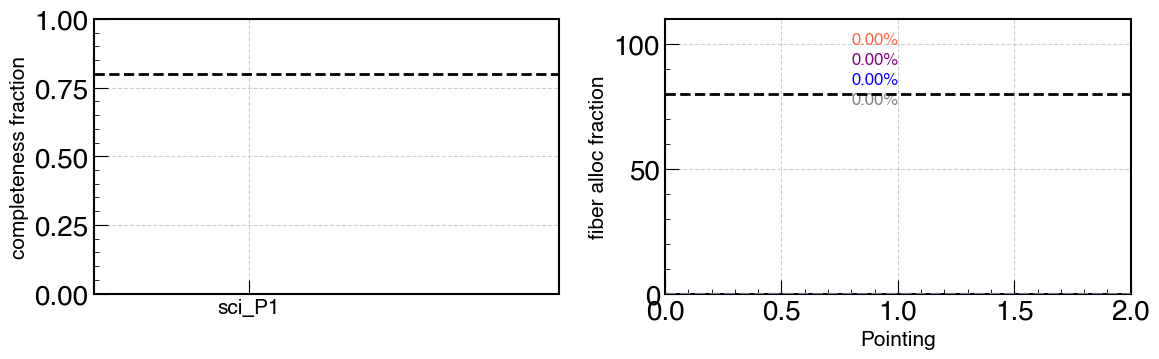

comp_out_tmp1 =  {'cal': 0.0, 'sci_P1': 0.0, 'sky': 0.0}
3070.478513 secs passed after the visits done.


/var/folders/y2/dt99qz312w97s6rx30gms2jm0000gn/T/ipykernel_3685/79039579.py:38: UserWarning: loadtxt: input contained no data: "../output/test/cosmology_region3_3h_output_v1_ra330.68_dec-0.52.txt"
  tgt_id_done = np.loadtxt(outdir + outfn, usecols=(0, ), unpack=True, dtype='str')
/var/folders/y2/dt99qz312w97s6rx30gms2jm0000gn/T/ipykernel_3685/2123539643.py:7: UserWarning: loadtxt: input contained no data: "../output/test/cosmology_region3_3h_output_v1_ra330.68_dec-0.52.txt"
  tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')


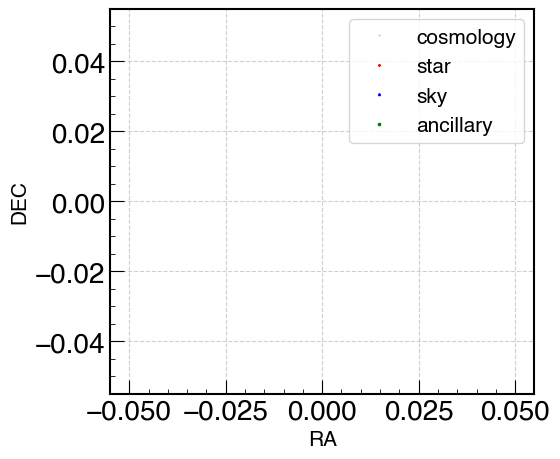

/var/folders/y2/dt99qz312w97s6rx30gms2jm0000gn/T/ipykernel_3685/2123539643.py:7: UserWarning: loadtxt: input contained no data: "../output/test/cosmology_region3_3h_output_v1_ra330.68_dec-0.52.txt"
  tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')


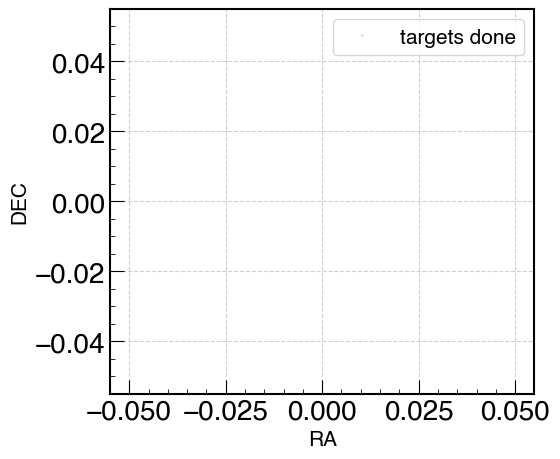

In [36]:
'''
Comment: no targets are assigned to the fibers
'''
bench, cobracoach = create_bench(layout="calibration_pfi_module")
collision_sim_version = 2
run_main(peaks, tgt, classdict, alreadyObserved, two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

In [10]:
#tclassdict = {'sci_P1' : 1, 'sky' : 2, 'cal' : 3}
#write_pfsDesign(outdir, 'pfsDesign_region3_3h_v1.txt', res, tpos, telescopes, tgt, classdict)

# TO-DO Lists
+ fix the problem of gurobi.lic in py_env_co_fa
+ update the target list after each observation
+ second visit, pointing center shift to avoid vignetting 
+ longer exposure option for second visit
+ (DONE!) remove the calibration targets in AlreadyObserved dict

+ (DONE!) CollisionSimulator versus SollisionSimulator2? 
+ cobra home position and collision simulator? 
+ generate 1h pfsDesign file using the code block above (CO will use first 6-8 hours)
+ (DONE!) (Q: iPS1 mag>18 is ok?) apply magnitude cut on bright stars
>>> Wanqiu: fainter than 16 (18 might be safer choice according to Andy)
+ (DONE) increase the sky/star fibers
>>> Masayuki - FLUXSTDs: 100-200 stars are good. Please distribute these stars uniformly across the field. 

+ fiberStatus? -- bad fibers and bad Cobra
+ apply bright star mask to sky/stars
+ generate uniform sky/star fiber assignment 
>>> Masato Onodera - I don't think I can put my script to check the uniformity of the distributions of sky and fluxstd objects against the home positions of science fibers. Please see the following gist how it's made. It uses dcor package for the comparsion, so making your own should be simple.
For the GA Fornax design, there is no configuration with p<0.05 (if my calculation is right).
https://gist.github.com/monodera/4c6fef2ce6a8370338250cd78ac78f26

>>> refer GA group code -
https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/nb/examples/netflow/8_cobra_groups.ipynb



# check list for the observatory Target Uploader
+ CO netflow output targets all get a fiber assigned (test myself - use output as an input, all targets have the same cost)
+ two stage == different cost (same sky coverage)?
+ CO needs to track the status of the target list and instrument
+ if different otime is used, how many targets (sci, sky, star separately) will be missed? (test myself - use output as an input)

